In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=1024
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=20
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv='clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

num_features=2124
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']###rename and retrain C8
training_sample_X='logminmax'
switchFreq=100
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_01_dca_advControl'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,len(training_samples))
    loss_adv=optimizer.optimizer_CEclf
    

if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr, weight_decay=weight_decay)    


In [7]:
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(1230)+'.pt')))
 
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv:
        modelAdv.eval()
        advOut=modelAdv(z)
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
#     loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv:
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv:
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    loss_val = loss_x_val+loss_a_val
#     loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv:
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
#           'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
#           'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
    else:
        return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val)        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()
for ep in range(1231,epochs):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv:
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 1231 loss_train: 3.5260 loss_kl_train: 0.1846 loss_x_train: 1.3267 loss_a_train: 2.0147 loss_val: 15.9481 loss_x_val: 1.3473 loss_a_val: 14.6008 time: 0.8864s
control13 Epoch: 1232 loss_train: 16.1673 loss_kl_train: 0.1899 loss_x_train: 1.3369 loss_a_train: 14.6405 loss_val: 2.2646 loss_x_val: 1.3398 loss_a_val: 0.9248 time: 0.4869s
control13 Epoch: 1233 loss_train: 3.6758 loss_kl_train: 0.1892 loss_x_train: 1.3320 loss_a_train: 2.1546 loss_val: 2.2138 loss_x_val: 1.3410 loss_a_val: 0.8728 time: 0.4828s
control13 Epoch: 1234 loss_train: 3.6165 loss_kl_train: 0.1914 loss_x_train: 1.3335 loss_a_train: 2.0916 loss_val: 2.6011 loss_x_val: 1.3416 loss_a_val: 1.2595 time: 0.4827s
control13 Epoch: 1235 loss_train: 3.7766 loss_kl_train: 0.1937 loss_x_train: 1.3333 loss_a_train: 2.2496 loss_val: 2.3995 loss_x_val: 1.3406 loss_a_val: 1.0589 time: 0.4788s
control13 Epoch: 1236 loss_train: 3.6461 loss_kl_train: 0.1955 loss_x_train: 1.3317 loss_a_train: 2.1189 loss_val: 2.2500 loss

control13 Epoch: 1279 loss_train: 2.8877 loss_kl_train: 0.2231 loss_x_train: 1.3241 loss_a_train: 1.3404 loss_val: 2.1774 loss_x_val: 1.3337 loss_a_val: 0.8437 time: 0.4850s
control13 Epoch: 1280 loss_train: 2.8673 loss_kl_train: 0.2234 loss_x_train: 1.3241 loss_a_train: 1.3197 loss_val: 2.1743 loss_x_val: 1.3333 loss_a_val: 0.8409 time: 0.4845s
control13 Epoch: 1281 loss_train: 2.8441 loss_kl_train: 0.2238 loss_x_train: 1.3238 loss_a_train: 1.2964 loss_val: 2.1581 loss_x_val: 1.3336 loss_a_val: 0.8245 time: 0.4805s
control13 Epoch: 1282 loss_train: 2.8324 loss_kl_train: 0.2241 loss_x_train: 1.3239 loss_a_train: 1.2844 loss_val: 2.1432 loss_x_val: 1.3333 loss_a_val: 0.8099 time: 0.4840s
control13 Epoch: 1283 loss_train: 2.8064 loss_kl_train: 0.2246 loss_x_train: 1.3237 loss_a_train: 1.2581 loss_val: 2.1253 loss_x_val: 1.3332 loss_a_val: 0.7921 time: 0.4837s
control13 Epoch: 1284 loss_train: 2.7786 loss_kl_train: 0.2250 loss_x_train: 1.3236 loss_a_train: 1.2300 loss_val: 2.1090 loss_x_v

disease13 Epoch: 1327 loss_train: 2.4854 loss_kl_train: 0.2150 loss_x_train: 1.4622 loss_a_train: 0.8082 loss_val: 2.1273 loss_x_val: 1.4766 loss_a_val: 0.6507 time: 0.7356s
disease13 Epoch: 1328 loss_train: 2.4768 loss_kl_train: 0.2148 loss_x_train: 1.4622 loss_a_train: 0.7999 loss_val: 2.1251 loss_x_val: 1.4766 loss_a_val: 0.6485 time: 0.7412s
disease13 Epoch: 1329 loss_train: 2.4780 loss_kl_train: 0.2146 loss_x_train: 1.4622 loss_a_train: 0.8011 loss_val: 2.1254 loss_x_val: 1.4765 loss_a_val: 0.6489 time: 0.7432s
disease13 Epoch: 1330 loss_train: 2.4755 loss_kl_train: 0.2144 loss_x_train: 1.4620 loss_a_train: 0.7990 loss_val: 2.1279 loss_x_val: 1.4765 loss_a_val: 0.6515 time: 0.7418s
disease13 Epoch: 1331 loss_train: 2.4691 loss_kl_train: 0.2143 loss_x_train: 1.4620 loss_a_train: 0.7928 loss_val: 2.1259 loss_x_val: 1.4764 loss_a_val: 0.6495 time: 0.7347s
disease13 Epoch: 1332 loss_train: 2.4653 loss_kl_train: 0.2142 loss_x_train: 1.4618 loss_a_train: 0.7893 loss_val: 2.1161 loss_x_v

disease13 Epoch: 1375 loss_train: 2.3451 loss_kl_train: 0.2128 loss_x_train: 1.4597 loss_a_train: 0.6726 loss_val: 2.0414 loss_x_val: 1.4737 loss_a_val: 0.5677 time: 0.7477s
disease13 Epoch: 1376 loss_train: 2.3433 loss_kl_train: 0.2129 loss_x_train: 1.4596 loss_a_train: 0.6708 loss_val: 2.0455 loss_x_val: 1.4737 loss_a_val: 0.5718 time: 0.7458s
disease13 Epoch: 1377 loss_train: 2.3405 loss_kl_train: 0.2129 loss_x_train: 1.4596 loss_a_train: 0.6680 loss_val: 2.0433 loss_x_val: 1.4737 loss_a_val: 0.5696 time: 0.7478s
disease13 Epoch: 1378 loss_train: 2.3378 loss_kl_train: 0.2129 loss_x_train: 1.4596 loss_a_train: 0.6652 loss_val: 2.0435 loss_x_val: 1.4737 loss_a_val: 0.5698 time: 0.7446s
disease13 Epoch: 1379 loss_train: 2.3376 loss_kl_train: 0.2131 loss_x_train: 1.4597 loss_a_train: 0.6649 loss_val: 2.0427 loss_x_val: 1.4736 loss_a_val: 0.5691 time: 0.7456s
disease13 Epoch: 1380 loss_train: 2.3357 loss_kl_train: 0.2131 loss_x_train: 1.4596 loss_a_train: 0.6631 loss_val: 2.0354 loss_x_v

disease8 Epoch: 1423 loss_train: 2.3331 loss_kl_train: 0.2639 loss_x_train: 1.2691 loss_a_train: 0.8001 loss_val: 1.9580 loss_x_val: 1.2636 loss_a_val: 0.6944 time: 0.4415s
disease8 Epoch: 1424 loss_train: 2.3257 loss_kl_train: 0.2646 loss_x_train: 1.2691 loss_a_train: 0.7920 loss_val: 1.9587 loss_x_val: 1.2636 loss_a_val: 0.6951 time: 0.4414s
disease8 Epoch: 1425 loss_train: 2.3236 loss_kl_train: 0.2652 loss_x_train: 1.2690 loss_a_train: 0.7894 loss_val: 1.9656 loss_x_val: 1.2634 loss_a_val: 0.7022 time: 0.4408s
disease8 Epoch: 1426 loss_train: 2.3236 loss_kl_train: 0.2660 loss_x_train: 1.2691 loss_a_train: 0.7886 loss_val: 1.9547 loss_x_val: 1.2633 loss_a_val: 0.6913 time: 0.4401s
disease8 Epoch: 1427 loss_train: 2.3199 loss_kl_train: 0.2667 loss_x_train: 1.2691 loss_a_train: 0.7842 loss_val: 1.9452 loss_x_val: 1.2633 loss_a_val: 0.6819 time: 0.4417s
disease8 Epoch: 1428 loss_train: 2.3181 loss_kl_train: 0.2673 loss_x_train: 1.2689 loss_a_train: 0.7818 loss_val: 1.9482 loss_x_val: 1.

disease8 Epoch: 1471 loss_train: 2.2033 loss_kl_train: 0.2736 loss_x_train: 1.2674 loss_a_train: 0.6623 loss_val: 1.8456 loss_x_val: 1.2621 loss_a_val: 0.5835 time: 0.4403s
disease8 Epoch: 1472 loss_train: 2.2052 loss_kl_train: 0.2737 loss_x_train: 1.2673 loss_a_train: 0.6641 loss_val: 1.8474 loss_x_val: 1.2621 loss_a_val: 0.5853 time: 0.4400s
disease8 Epoch: 1473 loss_train: 2.2004 loss_kl_train: 0.2738 loss_x_train: 1.2674 loss_a_train: 0.6593 loss_val: 1.8477 loss_x_val: 1.2621 loss_a_val: 0.5856 time: 0.4424s
disease8 Epoch: 1474 loss_train: 2.2009 loss_kl_train: 0.2737 loss_x_train: 1.2674 loss_a_train: 0.6599 loss_val: 1.8358 loss_x_val: 1.2621 loss_a_val: 0.5737 time: 0.4457s
disease8 Epoch: 1475 loss_train: 2.1979 loss_kl_train: 0.2737 loss_x_train: 1.2673 loss_a_train: 0.6570 loss_val: 1.8579 loss_x_val: 1.2620 loss_a_val: 0.5959 time: 0.4417s
disease8 Epoch: 1476 loss_train: 2.1979 loss_kl_train: 0.2737 loss_x_train: 1.2673 loss_a_train: 0.6569 loss_val: 1.8350 loss_x_val: 1.

control8 Epoch: 1519 loss_train: 2.6439 loss_kl_train: 0.2812 loss_x_train: 1.4169 loss_a_train: 0.9458 loss_val: 2.3667 loss_x_val: 1.4245 loss_a_val: 0.9422 time: 0.5163s
control8 Epoch: 1520 loss_train: 2.6661 loss_kl_train: 0.2801 loss_x_train: 1.4164 loss_a_train: 0.9695 loss_val: 2.3481 loss_x_val: 1.4246 loss_a_val: 0.9235 time: 0.5194s
control8 Epoch: 1521 loss_train: 2.6410 loss_kl_train: 0.2788 loss_x_train: 1.4161 loss_a_train: 0.9462 loss_val: 2.3528 loss_x_val: 1.4238 loss_a_val: 0.9290 time: 0.5140s
control8 Epoch: 1522 loss_train: 2.6580 loss_kl_train: 0.2777 loss_x_train: 1.4157 loss_a_train: 0.9646 loss_val: 2.3479 loss_x_val: 1.4235 loss_a_val: 0.9244 time: 0.5168s
control8 Epoch: 1523 loss_train: 2.6453 loss_kl_train: 0.2762 loss_x_train: 1.4157 loss_a_train: 0.9534 loss_val: 2.3410 loss_x_val: 1.4235 loss_a_val: 0.9175 time: 0.5139s
control8 Epoch: 1524 loss_train: 2.6379 loss_kl_train: 0.2753 loss_x_train: 1.4157 loss_a_train: 0.9469 loss_val: 2.3347 loss_x_val: 1.

control8 Epoch: 1567 loss_train: 2.4169 loss_kl_train: 0.2535 loss_x_train: 1.4129 loss_a_train: 0.7506 loss_val: 2.1359 loss_x_val: 1.4205 loss_a_val: 0.7154 time: 0.5178s
control8 Epoch: 1568 loss_train: 2.4164 loss_kl_train: 0.2535 loss_x_train: 1.4128 loss_a_train: 0.7500 loss_val: 2.1339 loss_x_val: 1.4204 loss_a_val: 0.7134 time: 0.5152s
control8 Epoch: 1569 loss_train: 2.4115 loss_kl_train: 0.2535 loss_x_train: 1.4128 loss_a_train: 0.7452 loss_val: 2.1306 loss_x_val: 1.4204 loss_a_val: 0.7102 time: 0.5179s
control8 Epoch: 1570 loss_train: 2.4143 loss_kl_train: 0.2536 loss_x_train: 1.4127 loss_a_train: 0.7479 loss_val: 2.1352 loss_x_val: 1.4204 loss_a_val: 0.7148 time: 0.5134s
control8 Epoch: 1571 loss_train: 2.4070 loss_kl_train: 0.2537 loss_x_train: 1.4129 loss_a_train: 0.7404 loss_val: 2.1206 loss_x_val: 1.4203 loss_a_val: 0.7003 time: 0.5137s
control8 Epoch: 1572 loss_train: 2.4034 loss_kl_train: 0.2536 loss_x_train: 1.4126 loss_a_train: 0.7372 loss_val: 2.1200 loss_x_val: 1.

control13 Epoch: 1615 loss_train: 2.5590 loss_kl_train: 0.2439 loss_x_train: 1.3207 loss_a_train: 0.9943 loss_val: 2.2349 loss_x_val: 1.3273 loss_a_val: 0.9076 time: 0.4853s
control13 Epoch: 1616 loss_train: 2.5496 loss_kl_train: 0.2450 loss_x_train: 1.3206 loss_a_train: 0.9841 loss_val: 2.2211 loss_x_val: 1.3273 loss_a_val: 0.8938 time: 0.4924s
control13 Epoch: 1617 loss_train: 2.5382 loss_kl_train: 0.2461 loss_x_train: 1.3205 loss_a_train: 0.9716 loss_val: 2.2082 loss_x_val: 1.3273 loss_a_val: 0.8808 time: 0.4892s
control13 Epoch: 1618 loss_train: 2.5202 loss_kl_train: 0.2471 loss_x_train: 1.3203 loss_a_train: 0.9529 loss_val: 2.1949 loss_x_val: 1.3273 loss_a_val: 0.8676 time: 0.4874s
control13 Epoch: 1619 loss_train: 2.5121 loss_kl_train: 0.2480 loss_x_train: 1.3203 loss_a_train: 0.9438 loss_val: 2.1839 loss_x_val: 1.3272 loss_a_val: 0.8567 time: 0.4877s
control13 Epoch: 1620 loss_train: 2.4973 loss_kl_train: 0.2487 loss_x_train: 1.3202 loss_a_train: 0.9283 loss_val: 2.1728 loss_x_v

control13 Epoch: 1663 loss_train: 2.2662 loss_kl_train: 0.2619 loss_x_train: 1.3183 loss_a_train: 0.6860 loss_val: 1.9732 loss_x_val: 1.3262 loss_a_val: 0.6470 time: 0.4882s
control13 Epoch: 1664 loss_train: 2.2618 loss_kl_train: 0.2620 loss_x_train: 1.3182 loss_a_train: 0.6816 loss_val: 1.9709 loss_x_val: 1.3262 loss_a_val: 0.6447 time: 0.4911s
control13 Epoch: 1665 loss_train: 2.2643 loss_kl_train: 0.2621 loss_x_train: 1.3182 loss_a_train: 0.6839 loss_val: 1.9655 loss_x_val: 1.3262 loss_a_val: 0.6393 time: 0.4874s
control13 Epoch: 1666 loss_train: 2.2610 loss_kl_train: 0.2619 loss_x_train: 1.3183 loss_a_train: 0.6807 loss_val: 1.9583 loss_x_val: 1.3262 loss_a_val: 0.6321 time: 0.4882s
control13 Epoch: 1667 loss_train: 2.2637 loss_kl_train: 0.2622 loss_x_train: 1.3181 loss_a_train: 0.6834 loss_val: 1.9656 loss_x_val: 1.3262 loss_a_val: 0.6395 time: 0.4851s
control13 Epoch: 1668 loss_train: 2.2582 loss_kl_train: 0.2622 loss_x_train: 1.3182 loss_a_train: 0.6778 loss_val: 1.9607 loss_x_v

disease13 Epoch: 1711 loss_train: 2.4473 loss_kl_train: 0.2409 loss_x_train: 1.4605 loss_a_train: 0.7459 loss_val: 2.2007 loss_x_val: 1.4725 loss_a_val: 0.7281 time: 0.7484s
disease13 Epoch: 1712 loss_train: 2.4459 loss_kl_train: 0.2402 loss_x_train: 1.4598 loss_a_train: 0.7459 loss_val: 2.1987 loss_x_val: 1.4726 loss_a_val: 0.7261 time: 0.7512s
disease13 Epoch: 1713 loss_train: 2.4421 loss_kl_train: 0.2395 loss_x_train: 1.4601 loss_a_train: 0.7425 loss_val: 2.1935 loss_x_val: 1.4723 loss_a_val: 0.7213 time: 0.7524s
disease13 Epoch: 1714 loss_train: 2.4409 loss_kl_train: 0.2386 loss_x_train: 1.4600 loss_a_train: 0.7423 loss_val: 2.2091 loss_x_val: 1.4722 loss_a_val: 0.7369 time: 0.7467s
disease13 Epoch: 1715 loss_train: 2.4340 loss_kl_train: 0.2378 loss_x_train: 1.4596 loss_a_train: 0.7366 loss_val: 2.1939 loss_x_val: 1.4722 loss_a_val: 0.7217 time: 0.7464s
disease13 Epoch: 1716 loss_train: 2.4281 loss_kl_train: 0.2372 loss_x_train: 1.4592 loss_a_train: 0.7317 loss_val: 2.1748 loss_x_v

disease13 Epoch: 1759 loss_train: 2.2670 loss_kl_train: 0.2196 loss_x_train: 1.4566 loss_a_train: 0.5907 loss_val: 2.0259 loss_x_val: 1.4705 loss_a_val: 0.5555 time: 0.7443s
disease13 Epoch: 1760 loss_train: 2.2652 loss_kl_train: 0.2195 loss_x_train: 1.4567 loss_a_train: 0.5891 loss_val: 2.0180 loss_x_val: 1.4705 loss_a_val: 0.5475 time: 0.7487s
disease13 Epoch: 1761 loss_train: 2.2646 loss_kl_train: 0.2196 loss_x_train: 1.4566 loss_a_train: 0.5884 loss_val: 2.0131 loss_x_val: 1.4704 loss_a_val: 0.5427 time: 0.7413s
disease13 Epoch: 1762 loss_train: 2.2648 loss_kl_train: 0.2194 loss_x_train: 1.4565 loss_a_train: 0.5889 loss_val: 2.0171 loss_x_val: 1.4704 loss_a_val: 0.5467 time: 0.7474s
disease13 Epoch: 1763 loss_train: 2.2605 loss_kl_train: 0.2194 loss_x_train: 1.4565 loss_a_train: 0.5846 loss_val: 2.0185 loss_x_val: 1.4703 loss_a_val: 0.5482 time: 0.7521s
disease13 Epoch: 1764 loss_train: 2.2586 loss_kl_train: 0.2192 loss_x_train: 1.4565 loss_a_train: 0.5829 loss_val: 2.0158 loss_x_v

disease8 Epoch: 1807 loss_train: 2.2392 loss_kl_train: 0.2534 loss_x_train: 1.2690 loss_a_train: 0.7168 loss_val: 1.9445 loss_x_val: 1.2619 loss_a_val: 0.6827 time: 0.4425s
disease8 Epoch: 1808 loss_train: 2.2404 loss_kl_train: 0.2548 loss_x_train: 1.2682 loss_a_train: 0.7174 loss_val: 1.9476 loss_x_val: 1.2621 loss_a_val: 0.6855 time: 0.4432s
disease8 Epoch: 1809 loss_train: 2.2418 loss_kl_train: 0.2560 loss_x_train: 1.2682 loss_a_train: 0.7176 loss_val: 1.9400 loss_x_val: 1.2617 loss_a_val: 0.6783 time: 0.4445s
disease8 Epoch: 1810 loss_train: 2.2409 loss_kl_train: 0.2573 loss_x_train: 1.2680 loss_a_train: 0.7156 loss_val: 1.9397 loss_x_val: 1.2617 loss_a_val: 0.6781 time: 0.4413s
disease8 Epoch: 1811 loss_train: 2.2428 loss_kl_train: 0.2584 loss_x_train: 1.2679 loss_a_train: 0.7164 loss_val: 1.9366 loss_x_val: 1.2616 loss_a_val: 0.6750 time: 0.4407s
disease8 Epoch: 1812 loss_train: 2.2436 loss_kl_train: 0.2598 loss_x_train: 1.2676 loss_a_train: 0.7162 loss_val: 1.9394 loss_x_val: 1.

disease8 Epoch: 1855 loss_train: 2.1472 loss_kl_train: 0.2763 loss_x_train: 1.2655 loss_a_train: 0.6053 loss_val: 1.8185 loss_x_val: 1.2604 loss_a_val: 0.5581 time: 0.4436s
disease8 Epoch: 1856 loss_train: 2.1422 loss_kl_train: 0.2763 loss_x_train: 1.2655 loss_a_train: 0.6004 loss_val: 1.8078 loss_x_val: 1.2604 loss_a_val: 0.5474 time: 0.4432s
disease8 Epoch: 1857 loss_train: 2.1448 loss_kl_train: 0.2762 loss_x_train: 1.2655 loss_a_train: 0.6031 loss_val: 1.8188 loss_x_val: 1.2603 loss_a_val: 0.5585 time: 0.4417s
disease8 Epoch: 1858 loss_train: 2.1428 loss_kl_train: 0.2762 loss_x_train: 1.2655 loss_a_train: 0.6011 loss_val: 1.8059 loss_x_val: 1.2604 loss_a_val: 0.5455 time: 0.4419s
disease8 Epoch: 1859 loss_train: 2.1382 loss_kl_train: 0.2762 loss_x_train: 1.2654 loss_a_train: 0.5966 loss_val: 1.8031 loss_x_val: 1.2604 loss_a_val: 0.5427 time: 0.4429s
disease8 Epoch: 1860 loss_train: 2.1379 loss_kl_train: 0.2761 loss_x_train: 1.2654 loss_a_train: 0.5965 loss_val: 1.8200 loss_x_val: 1.

control8 Epoch: 1903 loss_train: 2.3614 loss_kl_train: 0.2963 loss_x_train: 1.4183 loss_a_train: 0.6468 loss_val: 2.0884 loss_x_val: 1.4241 loss_a_val: 0.6643 time: 0.5136s
control8 Epoch: 1904 loss_train: 2.3457 loss_kl_train: 0.2960 loss_x_train: 1.4183 loss_a_train: 0.6314 loss_val: 2.1022 loss_x_val: 1.4229 loss_a_val: 0.6793 time: 0.5183s
control8 Epoch: 1905 loss_train: 2.3363 loss_kl_train: 0.2954 loss_x_train: 1.4172 loss_a_train: 0.6236 loss_val: 2.0812 loss_x_val: 1.4231 loss_a_val: 0.6581 time: 0.5140s
control8 Epoch: 1906 loss_train: 2.3316 loss_kl_train: 0.2948 loss_x_train: 1.4171 loss_a_train: 0.6196 loss_val: 2.0877 loss_x_val: 1.4235 loss_a_val: 0.6642 time: 0.5185s
control8 Epoch: 1907 loss_train: 2.3347 loss_kl_train: 0.2944 loss_x_train: 1.4173 loss_a_train: 0.6230 loss_val: 2.1233 loss_x_val: 1.4234 loss_a_val: 0.6999 time: 0.5157s
control8 Epoch: 1908 loss_train: 2.3388 loss_kl_train: 0.2936 loss_x_train: 1.4171 loss_a_train: 0.6281 loss_val: 2.0994 loss_x_val: 1.

control8 Epoch: 1951 loss_train: 2.3257 loss_kl_train: 0.2576 loss_x_train: 1.4117 loss_a_train: 0.6564 loss_val: 2.0561 loss_x_val: 1.4193 loss_a_val: 0.6368 time: 0.5189s
control8 Epoch: 1952 loss_train: 2.3259 loss_kl_train: 0.2580 loss_x_train: 1.4116 loss_a_train: 0.6563 loss_val: 2.0895 loss_x_val: 1.4193 loss_a_val: 0.6701 time: 0.5139s
control8 Epoch: 1953 loss_train: 2.3259 loss_kl_train: 0.2579 loss_x_train: 1.4119 loss_a_train: 0.6561 loss_val: 2.0773 loss_x_val: 1.4193 loss_a_val: 0.6580 time: 0.5165s
control8 Epoch: 1954 loss_train: 2.3241 loss_kl_train: 0.2577 loss_x_train: 1.4117 loss_a_train: 0.6546 loss_val: 2.0550 loss_x_val: 1.4193 loss_a_val: 0.6357 time: 0.5180s
control8 Epoch: 1955 loss_train: 2.3221 loss_kl_train: 0.2580 loss_x_train: 1.4115 loss_a_train: 0.6525 loss_val: 2.0685 loss_x_val: 1.4193 loss_a_val: 0.6492 time: 0.5198s
control8 Epoch: 1956 loss_train: 2.3153 loss_kl_train: 0.2580 loss_x_train: 1.4117 loss_a_train: 0.6456 loss_val: 2.0628 loss_x_val: 1.

control8 Epoch: 1999 loss_train: 2.2620 loss_kl_train: 0.2536 loss_x_train: 1.4105 loss_a_train: 0.5979 loss_val: 1.9850 loss_x_val: 1.4187 loss_a_val: 0.5663 time: 0.5157s
control13 Epoch: 2000 loss_train: 2.5324 loss_kl_train: 0.2198 loss_x_train: 1.3218 loss_a_train: 0.9908 loss_val: 2.0540 loss_x_val: 1.3277 loss_a_val: 0.7264 time: 0.4889s
control13 Epoch: 2001 loss_train: 2.2940 loss_kl_train: 0.2201 loss_x_train: 1.3216 loss_a_train: 0.7523 loss_val: 2.0519 loss_x_val: 1.3282 loss_a_val: 0.7236 time: 0.4892s
control13 Epoch: 2002 loss_train: 2.3034 loss_kl_train: 0.2217 loss_x_train: 1.3214 loss_a_train: 0.7603 loss_val: 2.0636 loss_x_val: 1.3278 loss_a_val: 0.7359 time: 0.4854s
control13 Epoch: 2003 loss_train: 2.3257 loss_kl_train: 0.2232 loss_x_train: 1.3210 loss_a_train: 0.7816 loss_val: 2.0797 loss_x_val: 1.3284 loss_a_val: 0.7513 time: 0.4883s
control13 Epoch: 2004 loss_train: 2.3425 loss_kl_train: 0.2250 loss_x_train: 1.3212 loss_a_train: 0.7963 loss_val: 2.0804 loss_x_va

control13 Epoch: 2047 loss_train: 2.2054 loss_kl_train: 0.2575 loss_x_train: 1.3171 loss_a_train: 0.6308 loss_val: 1.9020 loss_x_val: 1.3251 loss_a_val: 0.5768 time: 0.4886s
control13 Epoch: 2048 loss_train: 2.2025 loss_kl_train: 0.2576 loss_x_train: 1.3171 loss_a_train: 0.6277 loss_val: 1.9036 loss_x_val: 1.3251 loss_a_val: 0.5784 time: 0.4914s
control13 Epoch: 2049 loss_train: 2.1981 loss_kl_train: 0.2577 loss_x_train: 1.3170 loss_a_train: 0.6233 loss_val: 1.9051 loss_x_val: 1.3251 loss_a_val: 0.5800 time: 0.4866s
control13 Epoch: 2050 loss_train: 2.1973 loss_kl_train: 0.2579 loss_x_train: 1.3170 loss_a_train: 0.6224 loss_val: 1.8895 loss_x_val: 1.3251 loss_a_val: 0.5644 time: 0.4889s
control13 Epoch: 2051 loss_train: 2.1918 loss_kl_train: 0.2579 loss_x_train: 1.3170 loss_a_train: 0.6170 loss_val: 1.8941 loss_x_val: 1.3250 loss_a_val: 0.5690 time: 0.4875s
control13 Epoch: 2052 loss_train: 2.1909 loss_kl_train: 0.2581 loss_x_train: 1.3170 loss_a_train: 0.6158 loss_val: 1.8932 loss_x_v

control13 Epoch: 2095 loss_train: 2.1302 loss_kl_train: 0.2614 loss_x_train: 1.3163 loss_a_train: 0.5526 loss_val: 1.8337 loss_x_val: 1.3247 loss_a_val: 0.5090 time: 0.4884s
control13 Epoch: 2096 loss_train: 2.1315 loss_kl_train: 0.2614 loss_x_train: 1.3164 loss_a_train: 0.5537 loss_val: 1.8162 loss_x_val: 1.3247 loss_a_val: 0.4914 time: 0.4856s
control13 Epoch: 2097 loss_train: 2.1287 loss_kl_train: 0.2615 loss_x_train: 1.3163 loss_a_train: 0.5509 loss_val: 1.8141 loss_x_val: 1.3248 loss_a_val: 0.4894 time: 0.4886s
control13 Epoch: 2098 loss_train: 2.1263 loss_kl_train: 0.2616 loss_x_train: 1.3163 loss_a_train: 0.5485 loss_val: 1.8277 loss_x_val: 1.3247 loss_a_val: 0.5030 time: 0.4880s
control13 Epoch: 2099 loss_train: 2.1297 loss_kl_train: 0.2614 loss_x_train: 1.3163 loss_a_train: 0.5520 loss_val: 1.8161 loss_x_val: 1.3247 loss_a_val: 0.4914 time: 0.4878s
disease13 Epoch: 2100 loss_train: 2.3879 loss_kl_train: 0.2476 loss_x_train: 1.4665 loss_a_train: 0.6738 loss_val: 2.1481 loss_x_v

disease13 Epoch: 2143 loss_train: 2.2424 loss_kl_train: 0.2188 loss_x_train: 1.4559 loss_a_train: 0.5677 loss_val: 2.0047 loss_x_val: 1.4695 loss_a_val: 0.5352 time: 0.7364s
disease13 Epoch: 2144 loss_train: 2.2394 loss_kl_train: 0.2185 loss_x_train: 1.4559 loss_a_train: 0.5650 loss_val: 1.9915 loss_x_val: 1.4695 loss_a_val: 0.5221 time: 0.7429s
disease13 Epoch: 2145 loss_train: 2.2352 loss_kl_train: 0.2182 loss_x_train: 1.4558 loss_a_train: 0.5612 loss_val: 1.9932 loss_x_val: 1.4695 loss_a_val: 0.5237 time: 0.7398s
disease13 Epoch: 2146 loss_train: 2.2307 loss_kl_train: 0.2179 loss_x_train: 1.4557 loss_a_train: 0.5570 loss_val: 1.9893 loss_x_val: 1.4695 loss_a_val: 0.5198 time: 0.7419s
disease13 Epoch: 2147 loss_train: 2.2289 loss_kl_train: 0.2176 loss_x_train: 1.4557 loss_a_train: 0.5556 loss_val: 1.9865 loss_x_val: 1.4695 loss_a_val: 0.5170 time: 0.7438s
disease13 Epoch: 2148 loss_train: 2.2265 loss_kl_train: 0.2174 loss_x_train: 1.4557 loss_a_train: 0.5535 loss_val: 1.9888 loss_x_v

disease13 Epoch: 2191 loss_train: 2.1864 loss_kl_train: 0.2162 loss_x_train: 1.4550 loss_a_train: 0.5152 loss_val: 1.9405 loss_x_val: 1.4692 loss_a_val: 0.4712 time: 0.7375s
disease13 Epoch: 2192 loss_train: 2.1848 loss_kl_train: 0.2162 loss_x_train: 1.4549 loss_a_train: 0.5137 loss_val: 1.9531 loss_x_val: 1.4692 loss_a_val: 0.4838 time: 0.7419s
disease13 Epoch: 2193 loss_train: 2.1850 loss_kl_train: 0.2161 loss_x_train: 1.4551 loss_a_train: 0.5138 loss_val: 1.9345 loss_x_val: 1.4693 loss_a_val: 0.4652 time: 0.7358s
disease13 Epoch: 2194 loss_train: 2.1872 loss_kl_train: 0.2161 loss_x_train: 1.4549 loss_a_train: 0.5163 loss_val: 1.9572 loss_x_val: 1.4692 loss_a_val: 0.4880 time: 0.7421s
disease13 Epoch: 2195 loss_train: 2.1860 loss_kl_train: 0.2161 loss_x_train: 1.4550 loss_a_train: 0.5149 loss_val: 1.9327 loss_x_val: 1.4693 loss_a_val: 0.4634 time: 0.7420s
disease13 Epoch: 2196 loss_train: 2.1857 loss_kl_train: 0.2161 loss_x_train: 1.4549 loss_a_train: 0.5147 loss_val: 1.9442 loss_x_v

disease8 Epoch: 2239 loss_train: 2.2185 loss_kl_train: 0.2744 loss_x_train: 1.2658 loss_a_train: 0.6784 loss_val: 1.9000 loss_x_val: 1.2602 loss_a_val: 0.6398 time: 0.4425s
disease8 Epoch: 2240 loss_train: 2.2168 loss_kl_train: 0.2743 loss_x_train: 1.2658 loss_a_train: 0.6767 loss_val: 1.9053 loss_x_val: 1.2602 loss_a_val: 0.6451 time: 0.4426s
disease8 Epoch: 2241 loss_train: 2.2084 loss_kl_train: 0.2741 loss_x_train: 1.2657 loss_a_train: 0.6686 loss_val: 1.9022 loss_x_val: 1.2602 loss_a_val: 0.6420 time: 0.4419s
disease8 Epoch: 2242 loss_train: 2.2052 loss_kl_train: 0.2740 loss_x_train: 1.2656 loss_a_train: 0.6657 loss_val: 1.8937 loss_x_val: 1.2601 loss_a_val: 0.6336 time: 0.4448s
disease8 Epoch: 2243 loss_train: 2.2034 loss_kl_train: 0.2737 loss_x_train: 1.2655 loss_a_train: 0.6641 loss_val: 1.8892 loss_x_val: 1.2601 loss_a_val: 0.6291 time: 0.4421s
disease8 Epoch: 2244 loss_train: 2.1969 loss_kl_train: 0.2735 loss_x_train: 1.2655 loss_a_train: 0.6579 loss_val: 1.8892 loss_x_val: 1.

disease8 Epoch: 2287 loss_train: 2.0772 loss_kl_train: 0.2716 loss_x_train: 1.2642 loss_a_train: 0.5414 loss_val: 1.7536 loss_x_val: 1.2596 loss_a_val: 0.4939 time: 0.4425s
disease8 Epoch: 2288 loss_train: 2.0754 loss_kl_train: 0.2716 loss_x_train: 1.2643 loss_a_train: 0.5396 loss_val: 1.7477 loss_x_val: 1.2596 loss_a_val: 0.4881 time: 0.4449s
disease8 Epoch: 2289 loss_train: 2.0746 loss_kl_train: 0.2716 loss_x_train: 1.2641 loss_a_train: 0.5389 loss_val: 1.7484 loss_x_val: 1.2596 loss_a_val: 0.4888 time: 0.4440s
disease8 Epoch: 2290 loss_train: 2.0754 loss_kl_train: 0.2715 loss_x_train: 1.2643 loss_a_train: 0.5396 loss_val: 1.7453 loss_x_val: 1.2596 loss_a_val: 0.4856 time: 0.4425s
disease8 Epoch: 2291 loss_train: 2.0721 loss_kl_train: 0.2717 loss_x_train: 1.2642 loss_a_train: 0.5362 loss_val: 1.7509 loss_x_val: 1.2597 loss_a_val: 0.4912 time: 0.4407s
disease8 Epoch: 2292 loss_train: 2.0723 loss_kl_train: 0.2717 loss_x_train: 1.2642 loss_a_train: 0.5365 loss_val: 1.7453 loss_x_val: 1.

control8 Epoch: 2335 loss_train: 2.4563 loss_kl_train: 0.2599 loss_x_train: 1.4115 loss_a_train: 0.7848 loss_val: 2.1791 loss_x_val: 1.4187 loss_a_val: 0.7605 time: 0.5172s
control8 Epoch: 2336 loss_train: 2.4495 loss_kl_train: 0.2588 loss_x_train: 1.4116 loss_a_train: 0.7791 loss_val: 2.1723 loss_x_val: 1.4185 loss_a_val: 0.7538 time: 0.5197s
control8 Epoch: 2337 loss_train: 2.4448 loss_kl_train: 0.2575 loss_x_train: 1.4114 loss_a_train: 0.7759 loss_val: 2.1710 loss_x_val: 1.4185 loss_a_val: 0.7525 time: 0.5143s
control8 Epoch: 2338 loss_train: 2.4416 loss_kl_train: 0.2564 loss_x_train: 1.4113 loss_a_train: 0.7739 loss_val: 2.1681 loss_x_val: 1.4185 loss_a_val: 0.7497 time: 0.5171s
control8 Epoch: 2339 loss_train: 2.4444 loss_kl_train: 0.2551 loss_x_train: 1.4113 loss_a_train: 0.7780 loss_val: 2.1676 loss_x_val: 1.4185 loss_a_val: 0.7491 time: 0.5126s
control8 Epoch: 2340 loss_train: 2.4363 loss_kl_train: 0.2540 loss_x_train: 1.4113 loss_a_train: 0.7710 loss_val: 2.1630 loss_x_val: 1.

control8 Epoch: 2383 loss_train: 2.2229 loss_kl_train: 0.2464 loss_x_train: 1.4099 loss_a_train: 0.5666 loss_val: 1.9501 loss_x_val: 1.4179 loss_a_val: 0.5321 time: 0.5191s
control8 Epoch: 2384 loss_train: 2.2197 loss_kl_train: 0.2465 loss_x_train: 1.4098 loss_a_train: 0.5634 loss_val: 1.9458 loss_x_val: 1.4179 loss_a_val: 0.5278 time: 0.5178s
control8 Epoch: 2385 loss_train: 2.2194 loss_kl_train: 0.2467 loss_x_train: 1.4098 loss_a_train: 0.5629 loss_val: 1.9475 loss_x_val: 1.4179 loss_a_val: 0.5295 time: 0.5192s
control8 Epoch: 2386 loss_train: 2.2153 loss_kl_train: 0.2468 loss_x_train: 1.4098 loss_a_train: 0.5587 loss_val: 1.9467 loss_x_val: 1.4180 loss_a_val: 0.5288 time: 0.5138s
control8 Epoch: 2387 loss_train: 2.2160 loss_kl_train: 0.2469 loss_x_train: 1.4098 loss_a_train: 0.5593 loss_val: 1.9455 loss_x_val: 1.4180 loss_a_val: 0.5275 time: 0.5294s
control8 Epoch: 2388 loss_train: 2.2195 loss_kl_train: 0.2472 loss_x_train: 1.4098 loss_a_train: 0.5626 loss_val: 1.9516 loss_x_val: 1.

control13 Epoch: 2431 loss_train: 2.1992 loss_kl_train: 0.2516 loss_x_train: 1.3169 loss_a_train: 0.6307 loss_val: 1.8813 loss_x_val: 1.3245 loss_a_val: 0.5567 time: 0.4863s
control13 Epoch: 2432 loss_train: 2.1971 loss_kl_train: 0.2520 loss_x_train: 1.3168 loss_a_train: 0.6283 loss_val: 1.8798 loss_x_val: 1.3245 loss_a_val: 0.5553 time: 0.4882s
control13 Epoch: 2433 loss_train: 2.1954 loss_kl_train: 0.2525 loss_x_train: 1.3168 loss_a_train: 0.6261 loss_val: 1.8781 loss_x_val: 1.3245 loss_a_val: 0.5537 time: 0.4886s
control13 Epoch: 2434 loss_train: 2.1904 loss_kl_train: 0.2528 loss_x_train: 1.3167 loss_a_train: 0.6209 loss_val: 1.8766 loss_x_val: 1.3244 loss_a_val: 0.5521 time: 0.4886s
control13 Epoch: 2435 loss_train: 2.1880 loss_kl_train: 0.2532 loss_x_train: 1.3167 loss_a_train: 0.6180 loss_val: 1.8692 loss_x_val: 1.3244 loss_a_val: 0.5447 time: 0.4888s
control13 Epoch: 2436 loss_train: 2.1851 loss_kl_train: 0.2536 loss_x_train: 1.3166 loss_a_train: 0.6149 loss_val: 1.8690 loss_x_v

control13 Epoch: 2479 loss_train: 2.1045 loss_kl_train: 0.2570 loss_x_train: 1.3159 loss_a_train: 0.5316 loss_val: 1.7960 loss_x_val: 1.3241 loss_a_val: 0.4718 time: 0.4885s
control13 Epoch: 2480 loss_train: 2.1016 loss_kl_train: 0.2571 loss_x_train: 1.3159 loss_a_train: 0.5286 loss_val: 1.7909 loss_x_val: 1.3242 loss_a_val: 0.4667 time: 0.4893s
control13 Epoch: 2481 loss_train: 2.1031 loss_kl_train: 0.2570 loss_x_train: 1.3159 loss_a_train: 0.5302 loss_val: 1.7976 loss_x_val: 1.3242 loss_a_val: 0.4734 time: 0.4877s
control13 Epoch: 2482 loss_train: 2.1012 loss_kl_train: 0.2572 loss_x_train: 1.3159 loss_a_train: 0.5281 loss_val: 1.7887 loss_x_val: 1.3242 loss_a_val: 0.4645 time: 0.4891s
control13 Epoch: 2483 loss_train: 2.1002 loss_kl_train: 0.2573 loss_x_train: 1.3157 loss_a_train: 0.5272 loss_val: 1.7931 loss_x_val: 1.3241 loss_a_val: 0.4689 time: 0.4899s
control13 Epoch: 2484 loss_train: 2.1002 loss_kl_train: 0.2574 loss_x_train: 1.3158 loss_a_train: 0.5271 loss_val: 1.7901 loss_x_v

disease13 Epoch: 2527 loss_train: 2.2476 loss_kl_train: 0.2251 loss_x_train: 1.4560 loss_a_train: 0.5666 loss_val: 2.0090 loss_x_val: 1.4694 loss_a_val: 0.5395 time: 0.7518s
disease13 Epoch: 2528 loss_train: 2.2439 loss_kl_train: 0.2244 loss_x_train: 1.4560 loss_a_train: 0.5636 loss_val: 1.9988 loss_x_val: 1.4695 loss_a_val: 0.5294 time: 0.7509s
disease13 Epoch: 2529 loss_train: 2.2403 loss_kl_train: 0.2236 loss_x_train: 1.4558 loss_a_train: 0.5609 loss_val: 1.9909 loss_x_val: 1.4697 loss_a_val: 0.5212 time: 0.7503s
disease13 Epoch: 2530 loss_train: 2.2366 loss_kl_train: 0.2228 loss_x_train: 1.4558 loss_a_train: 0.5580 loss_val: 1.9994 loss_x_val: 1.4697 loss_a_val: 0.5297 time: 0.7466s
disease13 Epoch: 2531 loss_train: 2.2322 loss_kl_train: 0.2222 loss_x_train: 1.4558 loss_a_train: 0.5541 loss_val: 1.9818 loss_x_val: 1.4697 loss_a_val: 0.5120 time: 0.7380s
disease13 Epoch: 2532 loss_train: 2.2278 loss_kl_train: 0.2216 loss_x_train: 1.4557 loss_a_train: 0.5506 loss_val: 1.9804 loss_x_v

disease13 Epoch: 2575 loss_train: 2.1679 loss_kl_train: 0.2124 loss_x_train: 1.4545 loss_a_train: 0.5010 loss_val: 1.9234 loss_x_val: 1.4688 loss_a_val: 0.4546 time: 0.7450s
disease13 Epoch: 2576 loss_train: 2.1666 loss_kl_train: 0.2124 loss_x_train: 1.4544 loss_a_train: 0.4998 loss_val: 1.9255 loss_x_val: 1.4688 loss_a_val: 0.4567 time: 0.7367s
disease13 Epoch: 2577 loss_train: 2.1676 loss_kl_train: 0.2123 loss_x_train: 1.4545 loss_a_train: 0.5008 loss_val: 1.9191 loss_x_val: 1.4688 loss_a_val: 0.4503 time: 0.7427s
disease13 Epoch: 2578 loss_train: 2.1672 loss_kl_train: 0.2123 loss_x_train: 1.4545 loss_a_train: 0.5005 loss_val: 1.9290 loss_x_val: 1.4688 loss_a_val: 0.4602 time: 0.7428s
disease13 Epoch: 2579 loss_train: 2.1643 loss_kl_train: 0.2124 loss_x_train: 1.4544 loss_a_train: 0.4975 loss_val: 1.9185 loss_x_val: 1.4688 loss_a_val: 0.4496 time: 0.7442s
disease13 Epoch: 2580 loss_train: 2.1654 loss_kl_train: 0.2125 loss_x_train: 1.4544 loss_a_train: 0.4986 loss_val: 1.9196 loss_x_v

disease8 Epoch: 2623 loss_train: 2.3011 loss_kl_train: 0.2688 loss_x_train: 1.2661 loss_a_train: 0.7662 loss_val: 1.9906 loss_x_val: 1.2603 loss_a_val: 0.7303 time: 0.4412s
disease8 Epoch: 2624 loss_train: 2.2914 loss_kl_train: 0.2689 loss_x_train: 1.2661 loss_a_train: 0.7564 loss_val: 1.9778 loss_x_val: 1.2603 loss_a_val: 0.7175 time: 0.4432s
disease8 Epoch: 2625 loss_train: 2.2860 loss_kl_train: 0.2688 loss_x_train: 1.2661 loss_a_train: 0.7510 loss_val: 1.9669 loss_x_val: 1.2603 loss_a_val: 0.7066 time: 0.4444s
disease8 Epoch: 2626 loss_train: 2.2714 loss_kl_train: 0.2687 loss_x_train: 1.2660 loss_a_train: 0.7367 loss_val: 1.9546 loss_x_val: 1.2603 loss_a_val: 0.6942 time: 0.4449s
disease8 Epoch: 2627 loss_train: 2.2595 loss_kl_train: 0.2686 loss_x_train: 1.2659 loss_a_train: 0.7250 loss_val: 1.9514 loss_x_val: 1.2605 loss_a_val: 0.6909 time: 0.4438s
disease8 Epoch: 2628 loss_train: 2.2557 loss_kl_train: 0.2685 loss_x_train: 1.2659 loss_a_train: 0.7213 loss_val: 1.9463 loss_x_val: 1.

disease8 Epoch: 2671 loss_train: 2.0692 loss_kl_train: 0.2681 loss_x_train: 1.2641 loss_a_train: 0.5371 loss_val: 1.7374 loss_x_val: 1.2594 loss_a_val: 0.4780 time: 0.4439s
disease8 Epoch: 2672 loss_train: 2.0690 loss_kl_train: 0.2683 loss_x_train: 1.2640 loss_a_train: 0.5367 loss_val: 1.7357 loss_x_val: 1.2594 loss_a_val: 0.4763 time: 0.4459s
disease8 Epoch: 2673 loss_train: 2.0674 loss_kl_train: 0.2683 loss_x_train: 1.2641 loss_a_train: 0.5350 loss_val: 1.7345 loss_x_val: 1.2595 loss_a_val: 0.4750 time: 0.4438s
disease8 Epoch: 2674 loss_train: 2.0652 loss_kl_train: 0.2683 loss_x_train: 1.2640 loss_a_train: 0.5329 loss_val: 1.7325 loss_x_val: 1.2596 loss_a_val: 0.4729 time: 0.4434s
disease8 Epoch: 2675 loss_train: 2.0646 loss_kl_train: 0.2685 loss_x_train: 1.2640 loss_a_train: 0.5321 loss_val: 1.7349 loss_x_val: 1.2596 loss_a_val: 0.4753 time: 0.4452s
disease8 Epoch: 2676 loss_train: 2.0639 loss_kl_train: 0.2686 loss_x_train: 1.2640 loss_a_train: 0.5313 loss_val: 1.7300 loss_x_val: 1.

control8 Epoch: 2719 loss_train: 2.2896 loss_kl_train: 0.2739 loss_x_train: 1.4116 loss_a_train: 0.6042 loss_val: 2.0131 loss_x_val: 1.4185 loss_a_val: 0.5946 time: 0.5198s
control8 Epoch: 2720 loss_train: 2.2912 loss_kl_train: 0.2722 loss_x_train: 1.4115 loss_a_train: 0.6075 loss_val: 2.0181 loss_x_val: 1.4183 loss_a_val: 0.5998 time: 0.5153s
control8 Epoch: 2721 loss_train: 2.2816 loss_kl_train: 0.2708 loss_x_train: 1.4112 loss_a_train: 0.5996 loss_val: 2.0190 loss_x_val: 1.4183 loss_a_val: 0.6007 time: 0.5161s
control8 Epoch: 2722 loss_train: 2.2831 loss_kl_train: 0.2693 loss_x_train: 1.4112 loss_a_train: 0.6026 loss_val: 2.0067 loss_x_val: 1.4185 loss_a_val: 0.5882 time: 0.5186s
control8 Epoch: 2723 loss_train: 2.2797 loss_kl_train: 0.2678 loss_x_train: 1.4112 loss_a_train: 0.6007 loss_val: 2.0031 loss_x_val: 1.4185 loss_a_val: 0.5846 time: 0.5188s
control8 Epoch: 2724 loss_train: 2.2758 loss_kl_train: 0.2664 loss_x_train: 1.4110 loss_a_train: 0.5985 loss_val: 2.0065 loss_x_val: 1.

control8 Epoch: 2767 loss_train: 2.1644 loss_kl_train: 0.2456 loss_x_train: 1.4094 loss_a_train: 0.5095 loss_val: 1.8905 loss_x_val: 1.4178 loss_a_val: 0.4726 time: 0.5206s
control8 Epoch: 2768 loss_train: 2.1657 loss_kl_train: 0.2457 loss_x_train: 1.4093 loss_a_train: 0.5106 loss_val: 1.8882 loss_x_val: 1.4178 loss_a_val: 0.4704 time: 0.5173s
control8 Epoch: 2769 loss_train: 2.1620 loss_kl_train: 0.2458 loss_x_train: 1.4093 loss_a_train: 0.5069 loss_val: 1.8956 loss_x_val: 1.4177 loss_a_val: 0.4779 time: 0.5180s
control8 Epoch: 2770 loss_train: 2.1643 loss_kl_train: 0.2460 loss_x_train: 1.4094 loss_a_train: 0.5090 loss_val: 1.8818 loss_x_val: 1.4178 loss_a_val: 0.4640 time: 0.5133s
control8 Epoch: 2771 loss_train: 2.1603 loss_kl_train: 0.2462 loss_x_train: 1.4092 loss_a_train: 0.5050 loss_val: 1.8944 loss_x_val: 1.4178 loss_a_val: 0.4766 time: 0.5178s
control8 Epoch: 2772 loss_train: 2.1598 loss_kl_train: 0.2465 loss_x_train: 1.4092 loss_a_train: 0.5040 loss_val: 1.8857 loss_x_val: 1.

control13 Epoch: 2815 loss_train: 2.2809 loss_kl_train: 0.2394 loss_x_train: 1.3176 loss_a_train: 0.7239 loss_val: 1.9627 loss_x_val: 1.3247 loss_a_val: 0.6380 time: 0.4899s
control13 Epoch: 2816 loss_train: 2.2717 loss_kl_train: 0.2407 loss_x_train: 1.3176 loss_a_train: 0.7135 loss_val: 1.9603 loss_x_val: 1.3246 loss_a_val: 0.6357 time: 0.4872s
control13 Epoch: 2817 loss_train: 2.2648 loss_kl_train: 0.2417 loss_x_train: 1.3174 loss_a_train: 0.7057 loss_val: 1.9535 loss_x_val: 1.3246 loss_a_val: 0.6289 time: 0.4939s
control13 Epoch: 2818 loss_train: 2.2536 loss_kl_train: 0.2424 loss_x_train: 1.3173 loss_a_train: 0.6939 loss_val: 1.9310 loss_x_val: 1.3246 loss_a_val: 0.6064 time: 0.4900s
control13 Epoch: 2819 loss_train: 2.2409 loss_kl_train: 0.2433 loss_x_train: 1.3172 loss_a_train: 0.6803 loss_val: 1.9349 loss_x_val: 1.3245 loss_a_val: 0.6104 time: 0.4869s
control13 Epoch: 2820 loss_train: 2.2514 loss_kl_train: 0.2440 loss_x_train: 1.3171 loss_a_train: 0.6903 loss_val: 1.9119 loss_x_v

control13 Epoch: 2863 loss_train: 2.0997 loss_kl_train: 0.2523 loss_x_train: 1.3155 loss_a_train: 0.5319 loss_val: 1.7953 loss_x_val: 1.3239 loss_a_val: 0.4714 time: 0.4904s
control13 Epoch: 2864 loss_train: 2.0971 loss_kl_train: 0.2524 loss_x_train: 1.3156 loss_a_train: 0.5292 loss_val: 1.7875 loss_x_val: 1.3239 loss_a_val: 0.4636 time: 0.4858s
control13 Epoch: 2865 loss_train: 2.0965 loss_kl_train: 0.2526 loss_x_train: 1.3155 loss_a_train: 0.5284 loss_val: 1.7830 loss_x_val: 1.3239 loss_a_val: 0.4591 time: 0.4913s
control13 Epoch: 2866 loss_train: 2.0963 loss_kl_train: 0.2530 loss_x_train: 1.3155 loss_a_train: 0.5278 loss_val: 1.7914 loss_x_val: 1.3239 loss_a_val: 0.4675 time: 0.4912s
control13 Epoch: 2867 loss_train: 2.0934 loss_kl_train: 0.2530 loss_x_train: 1.3155 loss_a_train: 0.5249 loss_val: 1.7880 loss_x_val: 1.3239 loss_a_val: 0.4641 time: 0.4870s
control13 Epoch: 2868 loss_train: 2.0943 loss_kl_train: 0.2531 loss_x_train: 1.3155 loss_a_train: 0.5257 loss_val: 1.7782 loss_x_v

disease13 Epoch: 2911 loss_train: 2.2535 loss_kl_train: 0.2390 loss_x_train: 1.4583 loss_a_train: 0.5562 loss_val: 2.0108 loss_x_val: 1.4719 loss_a_val: 0.5389 time: 0.7512s
disease13 Epoch: 2912 loss_train: 2.2518 loss_kl_train: 0.2380 loss_x_train: 1.4587 loss_a_train: 0.5552 loss_val: 2.0043 loss_x_val: 1.4715 loss_a_val: 0.5328 time: 0.7452s
disease13 Epoch: 2913 loss_train: 2.2512 loss_kl_train: 0.2368 loss_x_train: 1.4579 loss_a_train: 0.5565 loss_val: 2.0060 loss_x_val: 1.4704 loss_a_val: 0.5356 time: 0.7500s
disease13 Epoch: 2914 loss_train: 2.2458 loss_kl_train: 0.2354 loss_x_train: 1.4571 loss_a_train: 0.5533 loss_val: 2.0005 loss_x_val: 1.4704 loss_a_val: 0.5302 time: 0.7515s
disease13 Epoch: 2915 loss_train: 2.2477 loss_kl_train: 0.2342 loss_x_train: 1.4574 loss_a_train: 0.5561 loss_val: 1.9989 loss_x_val: 1.4703 loss_a_val: 0.5286 time: 0.7522s
disease13 Epoch: 2916 loss_train: 2.2452 loss_kl_train: 0.2328 loss_x_train: 1.4572 loss_a_train: 0.5553 loss_val: 1.9967 loss_x_v

disease13 Epoch: 2959 loss_train: 2.1507 loss_kl_train: 0.2100 loss_x_train: 1.4542 loss_a_train: 0.4865 loss_val: 1.9077 loss_x_val: 1.4686 loss_a_val: 0.4391 time: 0.7452s
disease13 Epoch: 2960 loss_train: 2.1512 loss_kl_train: 0.2101 loss_x_train: 1.4541 loss_a_train: 0.4870 loss_val: 1.9116 loss_x_val: 1.4686 loss_a_val: 0.4431 time: 0.7401s
disease13 Epoch: 2961 loss_train: 2.1498 loss_kl_train: 0.2102 loss_x_train: 1.4542 loss_a_train: 0.4854 loss_val: 1.9092 loss_x_val: 1.4685 loss_a_val: 0.4407 time: 0.7426s
disease13 Epoch: 2962 loss_train: 2.1484 loss_kl_train: 0.2102 loss_x_train: 1.4542 loss_a_train: 0.4840 loss_val: 1.9075 loss_x_val: 1.4685 loss_a_val: 0.4390 time: 0.7463s
disease13 Epoch: 2963 loss_train: 2.1481 loss_kl_train: 0.2103 loss_x_train: 1.4542 loss_a_train: 0.4836 loss_val: 1.9094 loss_x_val: 1.4685 loss_a_val: 0.4409 time: 0.7495s
disease13 Epoch: 2964 loss_train: 2.1481 loss_kl_train: 0.2103 loss_x_train: 1.4541 loss_a_train: 0.4837 loss_val: 1.9068 loss_x_v

disease8 Epoch: 3007 loss_train: 2.3360 loss_kl_train: 0.2498 loss_x_train: 1.2679 loss_a_train: 0.8183 loss_val: 2.0360 loss_x_val: 1.2614 loss_a_val: 0.7746 time: 0.4445s
disease8 Epoch: 3008 loss_train: 2.3319 loss_kl_train: 0.2527 loss_x_train: 1.2675 loss_a_train: 0.8117 loss_val: 2.0243 loss_x_val: 1.2608 loss_a_val: 0.7634 time: 0.4449s
disease8 Epoch: 3009 loss_train: 2.3436 loss_kl_train: 0.2555 loss_x_train: 1.2670 loss_a_train: 0.8211 loss_val: 2.0427 loss_x_val: 1.2609 loss_a_val: 0.7818 time: 0.4411s
disease8 Epoch: 3010 loss_train: 2.3642 loss_kl_train: 0.2581 loss_x_train: 1.2672 loss_a_train: 0.8388 loss_val: 2.0584 loss_x_val: 1.2610 loss_a_val: 0.7974 time: 0.4411s
disease8 Epoch: 3011 loss_train: 2.3791 loss_kl_train: 0.2606 loss_x_train: 1.2671 loss_a_train: 0.8514 loss_val: 2.0655 loss_x_val: 1.2605 loss_a_val: 0.8050 time: 0.4446s
disease8 Epoch: 3012 loss_train: 2.3854 loss_kl_train: 0.2626 loss_x_train: 1.2667 loss_a_train: 0.8561 loss_val: 2.0723 loss_x_val: 1.

disease8 Epoch: 3055 loss_train: 2.1038 loss_kl_train: 0.2592 loss_x_train: 1.2640 loss_a_train: 0.5806 loss_val: 1.7676 loss_x_val: 1.2593 loss_a_val: 0.5083 time: 0.4424s
disease8 Epoch: 3056 loss_train: 2.1022 loss_kl_train: 0.2595 loss_x_train: 1.2640 loss_a_train: 0.5787 loss_val: 1.7701 loss_x_val: 1.2593 loss_a_val: 0.5108 time: 0.4421s
disease8 Epoch: 3057 loss_train: 2.0961 loss_kl_train: 0.2594 loss_x_train: 1.2640 loss_a_train: 0.5728 loss_val: 1.7640 loss_x_val: 1.2593 loss_a_val: 0.5047 time: 0.4405s
disease8 Epoch: 3058 loss_train: 2.0957 loss_kl_train: 0.2597 loss_x_train: 1.2640 loss_a_train: 0.5721 loss_val: 1.7687 loss_x_val: 1.2594 loss_a_val: 0.5093 time: 0.4420s
disease8 Epoch: 3059 loss_train: 2.0937 loss_kl_train: 0.2599 loss_x_train: 1.2640 loss_a_train: 0.5699 loss_val: 1.7595 loss_x_val: 1.2594 loss_a_val: 0.5001 time: 0.4436s
disease8 Epoch: 3060 loss_train: 2.0901 loss_kl_train: 0.2602 loss_x_train: 1.2639 loss_a_train: 0.5659 loss_val: 1.7543 loss_x_val: 1.

control8 Epoch: 3103 loss_train: 2.2951 loss_kl_train: 0.2886 loss_x_train: 1.4158 loss_a_train: 0.5906 loss_val: 2.0882 loss_x_val: 1.4222 loss_a_val: 0.6660 time: 0.5163s
control8 Epoch: 3104 loss_train: 2.3457 loss_kl_train: 0.2888 loss_x_train: 1.4165 loss_a_train: 0.6403 loss_val: 2.0420 loss_x_val: 1.4215 loss_a_val: 0.6205 time: 0.5190s
control8 Epoch: 3105 loss_train: 2.3125 loss_kl_train: 0.2890 loss_x_train: 1.4154 loss_a_train: 0.6081 loss_val: 2.0304 loss_x_val: 1.4217 loss_a_val: 0.6087 time: 0.5154s
control8 Epoch: 3106 loss_train: 2.3187 loss_kl_train: 0.2887 loss_x_train: 1.4150 loss_a_train: 0.6150 loss_val: 2.0199 loss_x_val: 1.4216 loss_a_val: 0.5982 time: 0.5178s
control8 Epoch: 3107 loss_train: 2.3089 loss_kl_train: 0.2883 loss_x_train: 1.4151 loss_a_train: 0.6055 loss_val: 2.0356 loss_x_val: 1.4211 loss_a_val: 0.6145 time: 0.5146s
control8 Epoch: 3108 loss_train: 2.3205 loss_kl_train: 0.2878 loss_x_train: 1.4149 loss_a_train: 0.6179 loss_val: 2.0475 loss_x_val: 1.

control8 Epoch: 3151 loss_train: 2.1765 loss_kl_train: 0.2382 loss_x_train: 1.4093 loss_a_train: 0.5290 loss_val: 1.8929 loss_x_val: 1.4178 loss_a_val: 0.4751 time: 0.5144s
control8 Epoch: 3152 loss_train: 2.1730 loss_kl_train: 0.2382 loss_x_train: 1.4092 loss_a_train: 0.5256 loss_val: 1.8921 loss_x_val: 1.4178 loss_a_val: 0.4743 time: 0.5193s
control8 Epoch: 3153 loss_train: 2.1700 loss_kl_train: 0.2386 loss_x_train: 1.4093 loss_a_train: 0.5222 loss_val: 1.8900 loss_x_val: 1.4178 loss_a_val: 0.4722 time: 0.5173s
control8 Epoch: 3154 loss_train: 2.1691 loss_kl_train: 0.2387 loss_x_train: 1.4092 loss_a_train: 0.5212 loss_val: 1.8905 loss_x_val: 1.4178 loss_a_val: 0.4726 time: 0.5181s
control8 Epoch: 3155 loss_train: 2.1686 loss_kl_train: 0.2390 loss_x_train: 1.4092 loss_a_train: 0.5204 loss_val: 1.8858 loss_x_val: 1.4178 loss_a_val: 0.4679 time: 0.5155s
control8 Epoch: 3156 loss_train: 2.1657 loss_kl_train: 0.2391 loss_x_train: 1.4091 loss_a_train: 0.5175 loss_val: 1.8860 loss_x_val: 1.

control8 Epoch: 3199 loss_train: 2.1339 loss_kl_train: 0.2449 loss_x_train: 1.4083 loss_a_train: 0.4807 loss_val: 1.8626 loss_x_val: 1.4176 loss_a_val: 0.4451 time: 0.5128s
control13 Epoch: 3200 loss_train: 2.3283 loss_kl_train: 0.2104 loss_x_train: 1.3198 loss_a_train: 0.7981 loss_val: 1.9389 loss_x_val: 1.3261 loss_a_val: 0.6128 time: 0.4909s
control13 Epoch: 3201 loss_train: 2.2162 loss_kl_train: 0.2098 loss_x_train: 1.3205 loss_a_train: 0.6860 loss_val: 1.9227 loss_x_val: 1.3259 loss_a_val: 0.5968 time: 0.4882s
control13 Epoch: 3202 loss_train: 2.2096 loss_kl_train: 0.2110 loss_x_train: 1.3199 loss_a_train: 0.6786 loss_val: 1.9087 loss_x_val: 1.3263 loss_a_val: 0.5823 time: 0.4895s
control13 Epoch: 3203 loss_train: 2.2377 loss_kl_train: 0.2129 loss_x_train: 1.3195 loss_a_train: 0.7053 loss_val: 1.8967 loss_x_val: 1.3262 loss_a_val: 0.5705 time: 0.4876s
control13 Epoch: 3204 loss_train: 2.2114 loss_kl_train: 0.2147 loss_x_train: 1.3193 loss_a_train: 0.6774 loss_val: 1.9346 loss_x_va

control13 Epoch: 3247 loss_train: 2.0797 loss_kl_train: 0.2532 loss_x_train: 1.3155 loss_a_train: 0.5109 loss_val: 1.7691 loss_x_val: 1.3238 loss_a_val: 0.4453 time: 0.4872s
control13 Epoch: 3248 loss_train: 2.0794 loss_kl_train: 0.2533 loss_x_train: 1.3154 loss_a_train: 0.5106 loss_val: 1.7731 loss_x_val: 1.3238 loss_a_val: 0.4493 time: 0.4880s
control13 Epoch: 3249 loss_train: 2.0762 loss_kl_train: 0.2534 loss_x_train: 1.3155 loss_a_train: 0.5073 loss_val: 1.7675 loss_x_val: 1.3238 loss_a_val: 0.4437 time: 0.4905s
control13 Epoch: 3250 loss_train: 2.0757 loss_kl_train: 0.2534 loss_x_train: 1.3154 loss_a_train: 0.5069 loss_val: 1.7672 loss_x_val: 1.3238 loss_a_val: 0.4434 time: 0.4878s
control13 Epoch: 3251 loss_train: 2.0751 loss_kl_train: 0.2534 loss_x_train: 1.3155 loss_a_train: 0.5062 loss_val: 1.7690 loss_x_val: 1.3238 loss_a_val: 0.4452 time: 0.4900s
control13 Epoch: 3252 loss_train: 2.0727 loss_kl_train: 0.2537 loss_x_train: 1.3153 loss_a_train: 0.5037 loss_val: 1.7638 loss_x_v

control13 Epoch: 3295 loss_train: 2.0515 loss_kl_train: 0.2544 loss_x_train: 1.3147 loss_a_train: 0.4824 loss_val: 1.7476 loss_x_val: 1.3236 loss_a_val: 0.4241 time: 0.4878s
control13 Epoch: 3296 loss_train: 2.0510 loss_kl_train: 0.2545 loss_x_train: 1.3147 loss_a_train: 0.4818 loss_val: 1.7425 loss_x_val: 1.3236 loss_a_val: 0.4189 time: 0.4883s
control13 Epoch: 3297 loss_train: 2.0509 loss_kl_train: 0.2546 loss_x_train: 1.3147 loss_a_train: 0.4816 loss_val: 1.7410 loss_x_val: 1.3235 loss_a_val: 0.4175 time: 0.4892s
control13 Epoch: 3298 loss_train: 2.0494 loss_kl_train: 0.2544 loss_x_train: 1.3147 loss_a_train: 0.4803 loss_val: 1.7445 loss_x_val: 1.3235 loss_a_val: 0.4210 time: 0.4855s
control13 Epoch: 3299 loss_train: 2.0499 loss_kl_train: 0.2544 loss_x_train: 1.3147 loss_a_train: 0.4808 loss_val: 1.7435 loss_x_val: 1.3236 loss_a_val: 0.4200 time: 0.4928s
disease13 Epoch: 3300 loss_train: 2.2746 loss_kl_train: 0.2477 loss_x_train: 1.4660 loss_a_train: 0.5609 loss_val: 2.0098 loss_x_v

disease13 Epoch: 3343 loss_train: 2.1524 loss_kl_train: 0.2084 loss_x_train: 1.4542 loss_a_train: 0.4898 loss_val: 1.9095 loss_x_val: 1.4686 loss_a_val: 0.4410 time: 0.7437s
disease13 Epoch: 3344 loss_train: 2.1492 loss_kl_train: 0.2083 loss_x_train: 1.4541 loss_a_train: 0.4867 loss_val: 1.9075 loss_x_val: 1.4686 loss_a_val: 0.4389 time: 0.7408s
disease13 Epoch: 3345 loss_train: 2.1523 loss_kl_train: 0.2082 loss_x_train: 1.4541 loss_a_train: 0.4900 loss_val: 1.9141 loss_x_val: 1.4685 loss_a_val: 0.4456 time: 0.7433s
disease13 Epoch: 3346 loss_train: 2.1489 loss_kl_train: 0.2081 loss_x_train: 1.4542 loss_a_train: 0.4866 loss_val: 1.9082 loss_x_val: 1.4685 loss_a_val: 0.4397 time: 0.7461s
disease13 Epoch: 3347 loss_train: 2.1475 loss_kl_train: 0.2080 loss_x_train: 1.4541 loss_a_train: 0.4854 loss_val: 1.9066 loss_x_val: 1.4685 loss_a_val: 0.4381 time: 0.7504s
disease13 Epoch: 3348 loss_train: 2.1452 loss_kl_train: 0.2081 loss_x_train: 1.4540 loss_a_train: 0.4831 loss_val: 1.9092 loss_x_v

disease13 Epoch: 3391 loss_train: 2.1293 loss_kl_train: 0.2109 loss_x_train: 1.4534 loss_a_train: 0.4651 loss_val: 1.8945 loss_x_val: 1.4684 loss_a_val: 0.4261 time: 0.7523s
disease13 Epoch: 3392 loss_train: 2.1288 loss_kl_train: 0.2108 loss_x_train: 1.4534 loss_a_train: 0.4646 loss_val: 1.8881 loss_x_val: 1.4684 loss_a_val: 0.4197 time: 0.7508s
disease13 Epoch: 3393 loss_train: 2.1301 loss_kl_train: 0.2108 loss_x_train: 1.4533 loss_a_train: 0.4660 loss_val: 1.8919 loss_x_val: 1.4684 loss_a_val: 0.4236 time: 0.7509s
disease13 Epoch: 3394 loss_train: 2.1282 loss_kl_train: 0.2107 loss_x_train: 1.4534 loss_a_train: 0.4641 loss_val: 1.8902 loss_x_val: 1.4684 loss_a_val: 0.4218 time: 0.7514s
disease13 Epoch: 3395 loss_train: 2.1290 loss_kl_train: 0.2107 loss_x_train: 1.4534 loss_a_train: 0.4648 loss_val: 1.8875 loss_x_val: 1.4684 loss_a_val: 0.4191 time: 0.7502s
disease13 Epoch: 3396 loss_train: 2.1277 loss_kl_train: 0.2108 loss_x_train: 1.4533 loss_a_train: 0.4636 loss_val: 1.8879 loss_x_v

disease8 Epoch: 3439 loss_train: 2.0891 loss_kl_train: 0.2662 loss_x_train: 1.2643 loss_a_train: 0.5586 loss_val: 1.7747 loss_x_val: 1.2593 loss_a_val: 0.5154 time: 0.4431s
disease8 Epoch: 3440 loss_train: 2.0871 loss_kl_train: 0.2659 loss_x_train: 1.2643 loss_a_train: 0.5569 loss_val: 1.7709 loss_x_val: 1.2594 loss_a_val: 0.5115 time: 0.4435s
disease8 Epoch: 3441 loss_train: 2.0826 loss_kl_train: 0.2657 loss_x_train: 1.2642 loss_a_train: 0.5527 loss_val: 1.7639 loss_x_val: 1.2595 loss_a_val: 0.5044 time: 0.4425s
disease8 Epoch: 3442 loss_train: 2.0781 loss_kl_train: 0.2656 loss_x_train: 1.2642 loss_a_train: 0.5483 loss_val: 1.7586 loss_x_val: 1.2595 loss_a_val: 0.4991 time: 0.4439s
disease8 Epoch: 3443 loss_train: 2.0756 loss_kl_train: 0.2654 loss_x_train: 1.2642 loss_a_train: 0.5460 loss_val: 1.7532 loss_x_val: 1.2595 loss_a_val: 0.4938 time: 0.4416s
disease8 Epoch: 3444 loss_train: 2.0691 loss_kl_train: 0.2651 loss_x_train: 1.2642 loss_a_train: 0.5398 loss_val: 1.7435 loss_x_val: 1.

disease8 Epoch: 3487 loss_train: 2.0192 loss_kl_train: 0.2661 loss_x_train: 1.2630 loss_a_train: 0.4901 loss_val: 1.6935 loss_x_val: 1.2594 loss_a_val: 0.4341 time: 0.4423s
disease8 Epoch: 3488 loss_train: 2.0182 loss_kl_train: 0.2662 loss_x_train: 1.2630 loss_a_train: 0.4890 loss_val: 1.6919 loss_x_val: 1.2594 loss_a_val: 0.4325 time: 0.4439s
disease8 Epoch: 3489 loss_train: 2.0201 loss_kl_train: 0.2660 loss_x_train: 1.2629 loss_a_train: 0.4912 loss_val: 1.6915 loss_x_val: 1.2593 loss_a_val: 0.4322 time: 0.4449s
disease8 Epoch: 3490 loss_train: 2.0178 loss_kl_train: 0.2664 loss_x_train: 1.2630 loss_a_train: 0.4884 loss_val: 1.6913 loss_x_val: 1.2594 loss_a_val: 0.4319 time: 0.4426s
disease8 Epoch: 3491 loss_train: 2.0174 loss_kl_train: 0.2662 loss_x_train: 1.2629 loss_a_train: 0.4883 loss_val: 1.6916 loss_x_val: 1.2594 loss_a_val: 0.4322 time: 0.4411s
disease8 Epoch: 3492 loss_train: 2.0155 loss_kl_train: 0.2662 loss_x_train: 1.2629 loss_a_train: 0.4864 loss_val: 1.6919 loss_x_val: 1.

control8 Epoch: 3535 loss_train: 2.1804 loss_kl_train: 0.2390 loss_x_train: 1.4097 loss_a_train: 0.5317 loss_val: 1.8957 loss_x_val: 1.4176 loss_a_val: 0.4781 time: 0.5182s
control8 Epoch: 3536 loss_train: 2.1749 loss_kl_train: 0.2389 loss_x_train: 1.4096 loss_a_train: 0.5265 loss_val: 1.8920 loss_x_val: 1.4176 loss_a_val: 0.4744 time: 0.5152s
control8 Epoch: 3537 loss_train: 2.1729 loss_kl_train: 0.2384 loss_x_train: 1.4095 loss_a_train: 0.5249 loss_val: 1.8927 loss_x_val: 1.4175 loss_a_val: 0.4751 time: 0.5172s
control8 Epoch: 3538 loss_train: 2.1704 loss_kl_train: 0.2382 loss_x_train: 1.4095 loss_a_train: 0.5228 loss_val: 1.8882 loss_x_val: 1.4177 loss_a_val: 0.4705 time: 0.5152s
control8 Epoch: 3539 loss_train: 2.1669 loss_kl_train: 0.2378 loss_x_train: 1.4095 loss_a_train: 0.5196 loss_val: 1.8853 loss_x_val: 1.4178 loss_a_val: 0.4675 time: 0.5197s
control8 Epoch: 3540 loss_train: 2.1651 loss_kl_train: 0.2377 loss_x_train: 1.4095 loss_a_train: 0.5179 loss_val: 1.8864 loss_x_val: 1.

control8 Epoch: 3583 loss_train: 2.1213 loss_kl_train: 0.2441 loss_x_train: 1.4083 loss_a_train: 0.4689 loss_val: 1.8426 loss_x_val: 1.4175 loss_a_val: 0.4251 time: 0.5175s
control8 Epoch: 3584 loss_train: 2.1200 loss_kl_train: 0.2441 loss_x_train: 1.4083 loss_a_train: 0.4676 loss_val: 1.8423 loss_x_val: 1.4175 loss_a_val: 0.4248 time: 0.5207s
control8 Epoch: 3585 loss_train: 2.1214 loss_kl_train: 0.2437 loss_x_train: 1.4084 loss_a_train: 0.4693 loss_val: 1.8458 loss_x_val: 1.4175 loss_a_val: 0.4283 time: 0.5177s
control8 Epoch: 3586 loss_train: 2.1211 loss_kl_train: 0.2440 loss_x_train: 1.4082 loss_a_train: 0.4689 loss_val: 1.8443 loss_x_val: 1.4175 loss_a_val: 0.4268 time: 0.5196s
control8 Epoch: 3587 loss_train: 2.1201 loss_kl_train: 0.2440 loss_x_train: 1.4083 loss_a_train: 0.4679 loss_val: 1.8420 loss_x_val: 1.4175 loss_a_val: 0.4246 time: 0.5161s
control8 Epoch: 3588 loss_train: 2.1214 loss_kl_train: 0.2439 loss_x_train: 1.4082 loss_a_train: 0.4693 loss_val: 1.8454 loss_x_val: 1.

control13 Epoch: 3631 loss_train: 2.0982 loss_kl_train: 0.2509 loss_x_train: 1.3157 loss_a_train: 0.5316 loss_val: 1.7864 loss_x_val: 1.3238 loss_a_val: 0.4626 time: 0.4889s
control13 Epoch: 3632 loss_train: 2.0938 loss_kl_train: 0.2510 loss_x_train: 1.3156 loss_a_train: 0.5271 loss_val: 1.7810 loss_x_val: 1.3238 loss_a_val: 0.4572 time: 0.4888s
control13 Epoch: 3633 loss_train: 2.0919 loss_kl_train: 0.2512 loss_x_train: 1.3155 loss_a_train: 0.5252 loss_val: 1.7792 loss_x_val: 1.3237 loss_a_val: 0.4555 time: 0.4918s
control13 Epoch: 3634 loss_train: 2.0884 loss_kl_train: 0.2512 loss_x_train: 1.3155 loss_a_train: 0.5217 loss_val: 1.7793 loss_x_val: 1.3237 loss_a_val: 0.4556 time: 0.4892s
control13 Epoch: 3635 loss_train: 2.0863 loss_kl_train: 0.2513 loss_x_train: 1.3155 loss_a_train: 0.5196 loss_val: 1.7745 loss_x_val: 1.3237 loss_a_val: 0.4508 time: 0.4866s
control13 Epoch: 3636 loss_train: 2.0845 loss_kl_train: 0.2512 loss_x_train: 1.3155 loss_a_train: 0.5178 loss_val: 1.7708 loss_x_v

control13 Epoch: 3679 loss_train: 2.0425 loss_kl_train: 0.2518 loss_x_train: 1.3145 loss_a_train: 0.4763 loss_val: 1.7378 loss_x_val: 1.3234 loss_a_val: 0.4144 time: 0.4882s
control13 Epoch: 3680 loss_train: 2.0418 loss_kl_train: 0.2518 loss_x_train: 1.3146 loss_a_train: 0.4755 loss_val: 1.7332 loss_x_val: 1.3234 loss_a_val: 0.4098 time: 0.4891s
control13 Epoch: 3681 loss_train: 2.0421 loss_kl_train: 0.2518 loss_x_train: 1.3145 loss_a_train: 0.4758 loss_val: 1.7336 loss_x_val: 1.3234 loss_a_val: 0.4102 time: 0.4888s
control13 Epoch: 3682 loss_train: 2.0414 loss_kl_train: 0.2515 loss_x_train: 1.3145 loss_a_train: 0.4754 loss_val: 1.7350 loss_x_val: 1.3234 loss_a_val: 0.4116 time: 0.4883s
control13 Epoch: 3683 loss_train: 2.0410 loss_kl_train: 0.2516 loss_x_train: 1.3145 loss_a_train: 0.4749 loss_val: 1.7365 loss_x_val: 1.3234 loss_a_val: 0.4130 time: 0.4883s
control13 Epoch: 3684 loss_train: 2.0400 loss_kl_train: 0.2516 loss_x_train: 1.3145 loss_a_train: 0.4739 loss_val: 1.7365 loss_x_v

disease13 Epoch: 3727 loss_train: 2.1430 loss_kl_train: 0.2125 loss_x_train: 1.4547 loss_a_train: 0.4757 loss_val: 1.9016 loss_x_val: 1.4687 loss_a_val: 0.4329 time: 0.7434s
disease13 Epoch: 3728 loss_train: 2.1407 loss_kl_train: 0.2118 loss_x_train: 1.4544 loss_a_train: 0.4744 loss_val: 1.9031 loss_x_val: 1.4687 loss_a_val: 0.4344 time: 0.7458s
disease13 Epoch: 3729 loss_train: 2.1384 loss_kl_train: 0.2111 loss_x_train: 1.4545 loss_a_train: 0.4728 loss_val: 1.8990 loss_x_val: 1.4687 loss_a_val: 0.4302 time: 0.7439s
disease13 Epoch: 3730 loss_train: 2.1389 loss_kl_train: 0.2105 loss_x_train: 1.4545 loss_a_train: 0.4739 loss_val: 1.8993 loss_x_val: 1.4687 loss_a_val: 0.4307 time: 0.7483s
disease13 Epoch: 3731 loss_train: 2.1365 loss_kl_train: 0.2098 loss_x_train: 1.4544 loss_a_train: 0.4723 loss_val: 1.9003 loss_x_val: 1.4685 loss_a_val: 0.4318 time: 0.7507s
disease13 Epoch: 3732 loss_train: 2.1350 loss_kl_train: 0.2091 loss_x_train: 1.4542 loss_a_train: 0.4717 loss_val: 1.8988 loss_x_v

disease13 Epoch: 3775 loss_train: 2.1176 loss_kl_train: 0.2096 loss_x_train: 1.4532 loss_a_train: 0.4548 loss_val: 1.8805 loss_x_val: 1.4682 loss_a_val: 0.4123 time: 0.7459s
disease13 Epoch: 3776 loss_train: 2.1175 loss_kl_train: 0.2097 loss_x_train: 1.4532 loss_a_train: 0.4546 loss_val: 1.8852 loss_x_val: 1.4682 loss_a_val: 0.4170 time: 0.7485s
disease13 Epoch: 3777 loss_train: 2.1196 loss_kl_train: 0.2095 loss_x_train: 1.4532 loss_a_train: 0.4569 loss_val: 1.8783 loss_x_val: 1.4683 loss_a_val: 0.4100 time: 0.7469s
disease13 Epoch: 3778 loss_train: 2.1189 loss_kl_train: 0.2096 loss_x_train: 1.4531 loss_a_train: 0.4562 loss_val: 1.8789 loss_x_val: 1.4683 loss_a_val: 0.4106 time: 0.7434s
disease13 Epoch: 3779 loss_train: 2.1178 loss_kl_train: 0.2095 loss_x_train: 1.4531 loss_a_train: 0.4552 loss_val: 1.8829 loss_x_val: 1.4682 loss_a_val: 0.4147 time: 0.7442s
disease13 Epoch: 3780 loss_train: 2.1181 loss_kl_train: 0.2096 loss_x_train: 1.4531 loss_a_train: 0.4554 loss_val: 1.8777 loss_x_v

disease8 Epoch: 3823 loss_train: 2.0934 loss_kl_train: 0.2674 loss_x_train: 1.2646 loss_a_train: 0.5614 loss_val: 1.7782 loss_x_val: 1.2595 loss_a_val: 0.5187 time: 0.4415s
disease8 Epoch: 3824 loss_train: 2.0884 loss_kl_train: 0.2679 loss_x_train: 1.2645 loss_a_train: 0.5560 loss_val: 1.7763 loss_x_val: 1.2596 loss_a_val: 0.5166 time: 0.4414s
disease8 Epoch: 3825 loss_train: 2.0880 loss_kl_train: 0.2683 loss_x_train: 1.2645 loss_a_train: 0.5551 loss_val: 1.7729 loss_x_val: 1.2596 loss_a_val: 0.5134 time: 0.4429s
disease8 Epoch: 3826 loss_train: 2.0818 loss_kl_train: 0.2683 loss_x_train: 1.2644 loss_a_train: 0.5491 loss_val: 1.7650 loss_x_val: 1.2594 loss_a_val: 0.5055 time: 0.4436s
disease8 Epoch: 3827 loss_train: 2.0802 loss_kl_train: 0.2684 loss_x_train: 1.2643 loss_a_train: 0.5474 loss_val: 1.7622 loss_x_val: 1.2594 loss_a_val: 0.5027 time: 0.4427s
disease8 Epoch: 3828 loss_train: 2.0764 loss_kl_train: 0.2683 loss_x_train: 1.2643 loss_a_train: 0.5437 loss_val: 1.7559 loss_x_val: 1.

disease8 Epoch: 3871 loss_train: 2.0075 loss_kl_train: 0.2632 loss_x_train: 1.2629 loss_a_train: 0.4814 loss_val: 1.6860 loss_x_val: 1.2593 loss_a_val: 0.4267 time: 0.4420s
disease8 Epoch: 3872 loss_train: 2.0097 loss_kl_train: 0.2633 loss_x_train: 1.2629 loss_a_train: 0.4835 loss_val: 1.6845 loss_x_val: 1.2593 loss_a_val: 0.4251 time: 0.4465s
disease8 Epoch: 3873 loss_train: 2.0073 loss_kl_train: 0.2634 loss_x_train: 1.2628 loss_a_train: 0.4811 loss_val: 1.6845 loss_x_val: 1.2593 loss_a_val: 0.4252 time: 0.4429s
disease8 Epoch: 3874 loss_train: 2.0084 loss_kl_train: 0.2633 loss_x_train: 1.2628 loss_a_train: 0.4823 loss_val: 1.6851 loss_x_val: 1.2593 loss_a_val: 0.4258 time: 0.4433s
disease8 Epoch: 3875 loss_train: 2.0072 loss_kl_train: 0.2634 loss_x_train: 1.2628 loss_a_train: 0.4811 loss_val: 1.6841 loss_x_val: 1.2593 loss_a_val: 0.4248 time: 0.4413s
disease8 Epoch: 3876 loss_train: 2.0071 loss_kl_train: 0.2637 loss_x_train: 1.2628 loss_a_train: 0.4807 loss_val: 1.6818 loss_x_val: 1.

control8 Epoch: 3919 loss_train: 2.1921 loss_kl_train: 0.2530 loss_x_train: 1.4107 loss_a_train: 0.5284 loss_val: 1.9177 loss_x_val: 1.4183 loss_a_val: 0.4994 time: 0.5149s
control8 Epoch: 3920 loss_train: 2.1908 loss_kl_train: 0.2515 loss_x_train: 1.4108 loss_a_train: 0.5286 loss_val: 1.9139 loss_x_val: 1.4182 loss_a_val: 0.4958 time: 0.5198s
control8 Epoch: 3921 loss_train: 2.1875 loss_kl_train: 0.2499 loss_x_train: 1.4105 loss_a_train: 0.5271 loss_val: 1.9119 loss_x_val: 1.4179 loss_a_val: 0.4939 time: 0.5199s
control8 Epoch: 3922 loss_train: 2.1848 loss_kl_train: 0.2486 loss_x_train: 1.4102 loss_a_train: 0.5260 loss_val: 1.9104 loss_x_val: 1.4179 loss_a_val: 0.4925 time: 0.5165s
control8 Epoch: 3923 loss_train: 2.1821 loss_kl_train: 0.2471 loss_x_train: 1.4101 loss_a_train: 0.5249 loss_val: 1.9036 loss_x_val: 1.4179 loss_a_val: 0.4858 time: 0.5173s
control8 Epoch: 3924 loss_train: 2.1800 loss_kl_train: 0.2459 loss_x_train: 1.4101 loss_a_train: 0.5240 loss_val: 1.8980 loss_x_val: 1.

control8 Epoch: 3967 loss_train: 2.1178 loss_kl_train: 0.2405 loss_x_train: 1.4083 loss_a_train: 0.4691 loss_val: 1.8418 loss_x_val: 1.4176 loss_a_val: 0.4243 time: 0.5146s
control8 Epoch: 3968 loss_train: 2.1178 loss_kl_train: 0.2406 loss_x_train: 1.4082 loss_a_train: 0.4689 loss_val: 1.8386 loss_x_val: 1.4176 loss_a_val: 0.4210 time: 0.5183s
control8 Epoch: 3969 loss_train: 2.1171 loss_kl_train: 0.2408 loss_x_train: 1.4082 loss_a_train: 0.4681 loss_val: 1.8396 loss_x_val: 1.4176 loss_a_val: 0.4220 time: 0.5148s
control8 Epoch: 3970 loss_train: 2.1159 loss_kl_train: 0.2410 loss_x_train: 1.4082 loss_a_train: 0.4667 loss_val: 1.8421 loss_x_val: 1.4176 loss_a_val: 0.4245 time: 0.5159s
control8 Epoch: 3971 loss_train: 2.1158 loss_kl_train: 0.2411 loss_x_train: 1.4082 loss_a_train: 0.4665 loss_val: 1.8367 loss_x_val: 1.4177 loss_a_val: 0.4191 time: 0.5105s
control8 Epoch: 3972 loss_train: 2.1163 loss_kl_train: 0.2412 loss_x_train: 1.4081 loss_a_train: 0.4670 loss_val: 1.8377 loss_x_val: 1.

control13 Epoch: 4015 loss_train: 2.1214 loss_kl_train: 0.2396 loss_x_train: 1.3166 loss_a_train: 0.5652 loss_val: 1.8111 loss_x_val: 1.3240 loss_a_val: 0.4871 time: 0.4889s
control13 Epoch: 4016 loss_train: 2.1200 loss_kl_train: 0.2419 loss_x_train: 1.3164 loss_a_train: 0.5617 loss_val: 1.8081 loss_x_val: 1.3240 loss_a_val: 0.4842 time: 0.4888s
control13 Epoch: 4017 loss_train: 2.1179 loss_kl_train: 0.2439 loss_x_train: 1.3164 loss_a_train: 0.5576 loss_val: 1.8070 loss_x_val: 1.3239 loss_a_val: 0.4831 time: 0.4879s
control13 Epoch: 4018 loss_train: 2.1146 loss_kl_train: 0.2456 loss_x_train: 1.3165 loss_a_train: 0.5526 loss_val: 1.8022 loss_x_val: 1.3239 loss_a_val: 0.4783 time: 0.4874s
control13 Epoch: 4019 loss_train: 2.1113 loss_kl_train: 0.2472 loss_x_train: 1.3162 loss_a_train: 0.5479 loss_val: 1.7986 loss_x_val: 1.3238 loss_a_val: 0.4749 time: 0.4882s
control13 Epoch: 4020 loss_train: 2.1087 loss_kl_train: 0.2483 loss_x_train: 1.3160 loss_a_train: 0.5444 loss_val: 1.7958 loss_x_v

control13 Epoch: 4063 loss_train: 2.0364 loss_kl_train: 0.2487 loss_x_train: 1.3145 loss_a_train: 0.4732 loss_val: 1.7304 loss_x_val: 1.3233 loss_a_val: 0.4071 time: 0.4883s
control13 Epoch: 4064 loss_train: 2.0365 loss_kl_train: 0.2487 loss_x_train: 1.3146 loss_a_train: 0.4731 loss_val: 1.7320 loss_x_val: 1.3233 loss_a_val: 0.4087 time: 0.4894s
control13 Epoch: 4065 loss_train: 2.0373 loss_kl_train: 0.2487 loss_x_train: 1.3146 loss_a_train: 0.4740 loss_val: 1.7321 loss_x_val: 1.3233 loss_a_val: 0.4088 time: 0.4843s
control13 Epoch: 4066 loss_train: 2.0362 loss_kl_train: 0.2490 loss_x_train: 1.3145 loss_a_train: 0.4727 loss_val: 1.7306 loss_x_val: 1.3233 loss_a_val: 0.4073 time: 0.4914s
control13 Epoch: 4067 loss_train: 2.0336 loss_kl_train: 0.2491 loss_x_train: 1.3145 loss_a_train: 0.4701 loss_val: 1.7294 loss_x_val: 1.3233 loss_a_val: 0.4061 time: 0.4865s
control13 Epoch: 4068 loss_train: 2.0339 loss_kl_train: 0.2491 loss_x_train: 1.3143 loss_a_train: 0.4705 loss_val: 1.7288 loss_x_v

disease13 Epoch: 4111 loss_train: 2.1959 loss_kl_train: 0.2291 loss_x_train: 1.4572 loss_a_train: 0.5096 loss_val: 1.9523 loss_x_val: 1.4701 loss_a_val: 0.4822 time: 0.7520s
disease13 Epoch: 4112 loss_train: 2.1932 loss_kl_train: 0.2274 loss_x_train: 1.4567 loss_a_train: 0.5091 loss_val: 1.9465 loss_x_val: 1.4707 loss_a_val: 0.4758 time: 0.7486s
disease13 Epoch: 4113 loss_train: 2.1953 loss_kl_train: 0.2256 loss_x_train: 1.4569 loss_a_train: 0.5128 loss_val: 1.9525 loss_x_val: 1.4705 loss_a_val: 0.4820 time: 0.7520s
disease13 Epoch: 4114 loss_train: 2.1882 loss_kl_train: 0.2239 loss_x_train: 1.4570 loss_a_train: 0.5072 loss_val: 1.9541 loss_x_val: 1.4699 loss_a_val: 0.4843 time: 0.7449s
disease13 Epoch: 4115 loss_train: 2.1887 loss_kl_train: 0.2219 loss_x_train: 1.4566 loss_a_train: 0.5102 loss_val: 1.9451 loss_x_val: 1.4691 loss_a_val: 0.4760 time: 0.7476s
disease13 Epoch: 4116 loss_train: 2.1870 loss_kl_train: 0.2200 loss_x_train: 1.4559 loss_a_train: 0.5111 loss_val: 1.9411 loss_x_v

disease13 Epoch: 4159 loss_train: 2.1150 loss_kl_train: 0.2069 loss_x_train: 1.4532 loss_a_train: 0.4549 loss_val: 1.8789 loss_x_val: 1.4682 loss_a_val: 0.4107 time: 0.7416s
disease13 Epoch: 4160 loss_train: 2.1140 loss_kl_train: 0.2071 loss_x_train: 1.4532 loss_a_train: 0.4537 loss_val: 1.8769 loss_x_val: 1.4682 loss_a_val: 0.4087 time: 0.7413s
disease13 Epoch: 4161 loss_train: 2.1141 loss_kl_train: 0.2074 loss_x_train: 1.4532 loss_a_train: 0.4535 loss_val: 1.8769 loss_x_val: 1.4682 loss_a_val: 0.4087 time: 0.7454s
disease13 Epoch: 4162 loss_train: 2.1139 loss_kl_train: 0.2075 loss_x_train: 1.4532 loss_a_train: 0.4531 loss_val: 1.8779 loss_x_val: 1.4682 loss_a_val: 0.4097 time: 0.7502s
disease13 Epoch: 4163 loss_train: 2.1138 loss_kl_train: 0.2076 loss_x_train: 1.4532 loss_a_train: 0.4531 loss_val: 1.8771 loss_x_val: 1.4682 loss_a_val: 0.4089 time: 0.7522s
disease13 Epoch: 4164 loss_train: 2.1130 loss_kl_train: 0.2077 loss_x_train: 1.4531 loss_a_train: 0.4522 loss_val: 1.8763 loss_x_v

disease8 Epoch: 4207 loss_train: 2.1538 loss_kl_train: 0.2465 loss_x_train: 1.2668 loss_a_train: 0.6405 loss_val: 1.8243 loss_x_val: 1.2615 loss_a_val: 0.5627 time: 0.4435s
disease8 Epoch: 4208 loss_train: 2.1505 loss_kl_train: 0.2501 loss_x_train: 1.2667 loss_a_train: 0.6338 loss_val: 1.8107 loss_x_val: 1.2608 loss_a_val: 0.5500 time: 0.4429s
disease8 Epoch: 4209 loss_train: 2.1364 loss_kl_train: 0.2533 loss_x_train: 1.2660 loss_a_train: 0.6170 loss_val: 1.8192 loss_x_val: 1.2604 loss_a_val: 0.5588 time: 0.4443s
disease8 Epoch: 4210 loss_train: 2.1330 loss_kl_train: 0.2563 loss_x_train: 1.2661 loss_a_train: 0.6106 loss_val: 1.8281 loss_x_val: 1.2603 loss_a_val: 0.5678 time: 0.4465s
disease8 Epoch: 4211 loss_train: 2.1327 loss_kl_train: 0.2592 loss_x_train: 1.2661 loss_a_train: 0.6074 loss_val: 1.8178 loss_x_val: 1.2599 loss_a_val: 0.5579 time: 0.4434s
disease8 Epoch: 4212 loss_train: 2.1283 loss_kl_train: 0.2616 loss_x_train: 1.2657 loss_a_train: 0.6010 loss_val: 1.8131 loss_x_val: 1.

disease8 Epoch: 4255 loss_train: 2.0155 loss_kl_train: 0.2578 loss_x_train: 1.2629 loss_a_train: 0.4948 loss_val: 1.6952 loss_x_val: 1.2593 loss_a_val: 0.4359 time: 0.4478s
disease8 Epoch: 4256 loss_train: 2.0142 loss_kl_train: 0.2578 loss_x_train: 1.2629 loss_a_train: 0.4934 loss_val: 1.6939 loss_x_val: 1.2593 loss_a_val: 0.4346 time: 0.4423s
disease8 Epoch: 4257 loss_train: 2.0124 loss_kl_train: 0.2580 loss_x_train: 1.2630 loss_a_train: 0.4915 loss_val: 1.6911 loss_x_val: 1.2593 loss_a_val: 0.4318 time: 0.4433s
disease8 Epoch: 4258 loss_train: 2.0125 loss_kl_train: 0.2582 loss_x_train: 1.2628 loss_a_train: 0.4915 loss_val: 1.6905 loss_x_val: 1.2593 loss_a_val: 0.4312 time: 0.4438s
disease8 Epoch: 4259 loss_train: 2.0112 loss_kl_train: 0.2583 loss_x_train: 1.2629 loss_a_train: 0.4900 loss_val: 1.6900 loss_x_val: 1.2593 loss_a_val: 0.4307 time: 0.4445s
disease8 Epoch: 4260 loss_train: 2.0113 loss_kl_train: 0.2584 loss_x_train: 1.2628 loss_a_train: 0.4902 loss_val: 1.6897 loss_x_val: 1.

control8 Epoch: 4303 loss_train: 2.2192 loss_kl_train: 0.2681 loss_x_train: 1.4150 loss_a_train: 0.5362 loss_val: 1.9519 loss_x_val: 1.4222 loss_a_val: 0.5296 time: 0.5193s
control8 Epoch: 4304 loss_train: 2.2096 loss_kl_train: 0.2685 loss_x_train: 1.4164 loss_a_train: 0.5247 loss_val: 1.9653 loss_x_val: 1.4214 loss_a_val: 0.5438 time: 0.5161s
control8 Epoch: 4305 loss_train: 2.2202 loss_kl_train: 0.2683 loss_x_train: 1.4154 loss_a_train: 0.5365 loss_val: 1.9270 loss_x_val: 1.4209 loss_a_val: 0.5060 time: 0.5169s
control8 Epoch: 4306 loss_train: 2.2020 loss_kl_train: 0.2671 loss_x_train: 1.4141 loss_a_train: 0.5209 loss_val: 1.9244 loss_x_val: 1.4212 loss_a_val: 0.5032 time: 0.5145s
control8 Epoch: 4307 loss_train: 2.1885 loss_kl_train: 0.2653 loss_x_train: 1.4140 loss_a_train: 0.5093 loss_val: 1.9367 loss_x_val: 1.4204 loss_a_val: 0.5164 time: 0.5199s
control8 Epoch: 4308 loss_train: 2.1913 loss_kl_train: 0.2636 loss_x_train: 1.4135 loss_a_train: 0.5142 loss_val: 1.9300 loss_x_val: 1.

control8 Epoch: 4351 loss_train: 2.1093 loss_kl_train: 0.2375 loss_x_train: 1.4082 loss_a_train: 0.4637 loss_val: 1.8332 loss_x_val: 1.4175 loss_a_val: 0.4157 time: 0.5174s
control8 Epoch: 4352 loss_train: 2.1089 loss_kl_train: 0.2377 loss_x_train: 1.4082 loss_a_train: 0.4631 loss_val: 1.8347 loss_x_val: 1.4175 loss_a_val: 0.4172 time: 0.5113s
control8 Epoch: 4353 loss_train: 2.1099 loss_kl_train: 0.2378 loss_x_train: 1.4083 loss_a_train: 0.4638 loss_val: 1.8321 loss_x_val: 1.4175 loss_a_val: 0.4146 time: 0.5174s
control8 Epoch: 4354 loss_train: 2.1086 loss_kl_train: 0.2382 loss_x_train: 1.4081 loss_a_train: 0.4622 loss_val: 1.8323 loss_x_val: 1.4174 loss_a_val: 0.4149 time: 0.5164s
control8 Epoch: 4355 loss_train: 2.1080 loss_kl_train: 0.2384 loss_x_train: 1.4082 loss_a_train: 0.4615 loss_val: 1.8328 loss_x_val: 1.4174 loss_a_val: 0.4154 time: 0.5219s
control8 Epoch: 4356 loss_train: 2.1085 loss_kl_train: 0.2386 loss_x_train: 1.4081 loss_a_train: 0.4619 loss_val: 1.8324 loss_x_val: 1.

control8 Epoch: 4399 loss_train: 2.0987 loss_kl_train: 0.2388 loss_x_train: 1.4073 loss_a_train: 0.4525 loss_val: 1.8225 loss_x_val: 1.4175 loss_a_val: 0.4050 time: 0.5180s
control13 Epoch: 4400 loss_train: 2.2160 loss_kl_train: 0.2148 loss_x_train: 1.3193 loss_a_train: 0.6818 loss_val: 1.8400 loss_x_val: 1.3256 loss_a_val: 0.5145 time: 0.4882s
control13 Epoch: 4401 loss_train: 2.1372 loss_kl_train: 0.2122 loss_x_train: 1.3200 loss_a_train: 0.6050 loss_val: 1.8580 loss_x_val: 1.3251 loss_a_val: 0.5330 time: 0.4896s
control13 Epoch: 4402 loss_train: 2.1512 loss_kl_train: 0.2113 loss_x_train: 1.3195 loss_a_train: 0.6204 loss_val: 1.8074 loss_x_val: 1.3249 loss_a_val: 0.4825 time: 0.4881s
control13 Epoch: 4403 loss_train: 2.1348 loss_kl_train: 0.2116 loss_x_train: 1.3188 loss_a_train: 0.6044 loss_val: 1.8051 loss_x_val: 1.3255 loss_a_val: 0.4796 time: 0.4933s
control13 Epoch: 4404 loss_train: 2.1416 loss_kl_train: 0.2130 loss_x_train: 1.3187 loss_a_train: 0.6099 loss_val: 1.7797 loss_x_va

control13 Epoch: 4447 loss_train: 2.0308 loss_kl_train: 0.2458 loss_x_train: 1.3146 loss_a_train: 0.4704 loss_val: 1.7279 loss_x_val: 1.3234 loss_a_val: 0.4045 time: 0.4866s
control13 Epoch: 4448 loss_train: 2.0298 loss_kl_train: 0.2455 loss_x_train: 1.3146 loss_a_train: 0.4697 loss_val: 1.7270 loss_x_val: 1.3234 loss_a_val: 0.4036 time: 0.4878s
control13 Epoch: 4449 loss_train: 2.0297 loss_kl_train: 0.2455 loss_x_train: 1.3146 loss_a_train: 0.4696 loss_val: 1.7277 loss_x_val: 1.3234 loss_a_val: 0.4043 time: 0.4892s
control13 Epoch: 4450 loss_train: 2.0297 loss_kl_train: 0.2454 loss_x_train: 1.3146 loss_a_train: 0.4697 loss_val: 1.7289 loss_x_val: 1.3234 loss_a_val: 0.4055 time: 0.4878s
control13 Epoch: 4451 loss_train: 2.0283 loss_kl_train: 0.2457 loss_x_train: 1.3145 loss_a_train: 0.4681 loss_val: 1.7276 loss_x_val: 1.3234 loss_a_val: 0.4042 time: 0.4906s
control13 Epoch: 4452 loss_train: 2.0279 loss_kl_train: 0.2455 loss_x_train: 1.3146 loss_a_train: 0.4678 loss_val: 1.7252 loss_x_v

control13 Epoch: 4495 loss_train: 2.0167 loss_kl_train: 0.2472 loss_x_train: 1.3138 loss_a_train: 0.4557 loss_val: 1.7159 loss_x_val: 1.3234 loss_a_val: 0.3926 time: 0.4885s
control13 Epoch: 4496 loss_train: 2.0154 loss_kl_train: 0.2474 loss_x_train: 1.3138 loss_a_train: 0.4543 loss_val: 1.7170 loss_x_val: 1.3234 loss_a_val: 0.3936 time: 0.4906s
control13 Epoch: 4497 loss_train: 2.0168 loss_kl_train: 0.2471 loss_x_train: 1.3138 loss_a_train: 0.4558 loss_val: 1.7172 loss_x_val: 1.3234 loss_a_val: 0.3939 time: 0.4862s
control13 Epoch: 4498 loss_train: 2.0175 loss_kl_train: 0.2472 loss_x_train: 1.3138 loss_a_train: 0.4565 loss_val: 1.7172 loss_x_val: 1.3234 loss_a_val: 0.3938 time: 0.4892s
control13 Epoch: 4499 loss_train: 2.0169 loss_kl_train: 0.2474 loss_x_train: 1.3138 loss_a_train: 0.4558 loss_val: 1.7168 loss_x_val: 1.3234 loss_a_val: 0.3934 time: 0.4900s
disease13 Epoch: 4500 loss_train: 2.2341 loss_kl_train: 0.2372 loss_x_train: 1.4666 loss_a_train: 0.5303 loss_val: 1.9592 loss_x_v

disease13 Epoch: 4543 loss_train: 2.1097 loss_kl_train: 0.2036 loss_x_train: 1.4534 loss_a_train: 0.4526 loss_val: 1.8725 loss_x_val: 1.4683 loss_a_val: 0.4042 time: 0.7527s
disease13 Epoch: 4544 loss_train: 2.1087 loss_kl_train: 0.2038 loss_x_train: 1.4534 loss_a_train: 0.4516 loss_val: 1.8726 loss_x_val: 1.4682 loss_a_val: 0.4044 time: 0.7466s
disease13 Epoch: 4545 loss_train: 2.1081 loss_kl_train: 0.2039 loss_x_train: 1.4533 loss_a_train: 0.4509 loss_val: 1.8708 loss_x_val: 1.4682 loss_a_val: 0.4027 time: 0.7484s
disease13 Epoch: 4546 loss_train: 2.1088 loss_kl_train: 0.2042 loss_x_train: 1.4533 loss_a_train: 0.4513 loss_val: 1.8713 loss_x_val: 1.4682 loss_a_val: 0.4031 time: 0.7469s
disease13 Epoch: 4547 loss_train: 2.1081 loss_kl_train: 0.2046 loss_x_train: 1.4532 loss_a_train: 0.4503 loss_val: 1.8724 loss_x_val: 1.4682 loss_a_val: 0.4042 time: 0.7477s
disease13 Epoch: 4548 loss_train: 2.1076 loss_kl_train: 0.2047 loss_x_train: 1.4532 loss_a_train: 0.4497 loss_val: 1.8705 loss_x_v

disease13 Epoch: 4591 loss_train: 2.1014 loss_kl_train: 0.2060 loss_x_train: 1.4525 loss_a_train: 0.4429 loss_val: 1.8667 loss_x_val: 1.4682 loss_a_val: 0.3985 time: 0.7474s
disease13 Epoch: 4592 loss_train: 2.1019 loss_kl_train: 0.2058 loss_x_train: 1.4524 loss_a_train: 0.4436 loss_val: 1.8669 loss_x_val: 1.4682 loss_a_val: 0.3988 time: 0.7510s
disease13 Epoch: 4593 loss_train: 2.1015 loss_kl_train: 0.2059 loss_x_train: 1.4525 loss_a_train: 0.4431 loss_val: 1.8661 loss_x_val: 1.4682 loss_a_val: 0.3980 time: 0.7470s
disease13 Epoch: 4594 loss_train: 2.1023 loss_kl_train: 0.2058 loss_x_train: 1.4525 loss_a_train: 0.4440 loss_val: 1.8665 loss_x_val: 1.4682 loss_a_val: 0.3984 time: 0.7551s
disease13 Epoch: 4595 loss_train: 2.1024 loss_kl_train: 0.2058 loss_x_train: 1.4525 loss_a_train: 0.4442 loss_val: 1.8668 loss_x_val: 1.4681 loss_a_val: 0.3987 time: 0.7528s
disease13 Epoch: 4596 loss_train: 2.1005 loss_kl_train: 0.2057 loss_x_train: 1.4525 loss_a_train: 0.4424 loss_val: 1.8664 loss_x_v

disease8 Epoch: 4639 loss_train: 2.0097 loss_kl_train: 0.2578 loss_x_train: 1.2632 loss_a_train: 0.4887 loss_val: 1.6903 loss_x_val: 1.2592 loss_a_val: 0.4311 time: 0.4435s
disease8 Epoch: 4640 loss_train: 2.0083 loss_kl_train: 0.2575 loss_x_train: 1.2631 loss_a_train: 0.4878 loss_val: 1.6890 loss_x_val: 1.2592 loss_a_val: 0.4299 time: 0.4428s
disease8 Epoch: 4641 loss_train: 2.0089 loss_kl_train: 0.2572 loss_x_train: 1.2631 loss_a_train: 0.4886 loss_val: 1.6869 loss_x_val: 1.2592 loss_a_val: 0.4277 time: 0.4425s
disease8 Epoch: 4642 loss_train: 2.0053 loss_kl_train: 0.2572 loss_x_train: 1.2630 loss_a_train: 0.4850 loss_val: 1.6873 loss_x_val: 1.2593 loss_a_val: 0.4281 time: 0.4440s
disease8 Epoch: 4643 loss_train: 2.0048 loss_kl_train: 0.2575 loss_x_train: 1.2630 loss_a_train: 0.4843 loss_val: 1.6877 loss_x_val: 1.2592 loss_a_val: 0.4285 time: 0.4444s
disease8 Epoch: 4644 loss_train: 2.0040 loss_kl_train: 0.2574 loss_x_train: 1.2629 loss_a_train: 0.4837 loss_val: 1.6872 loss_x_val: 1.

disease8 Epoch: 4687 loss_train: 1.9841 loss_kl_train: 0.2598 loss_x_train: 1.2620 loss_a_train: 0.4623 loss_val: 1.6639 loss_x_val: 1.2595 loss_a_val: 0.4044 time: 0.4427s
disease8 Epoch: 4688 loss_train: 1.9850 loss_kl_train: 0.2596 loss_x_train: 1.2621 loss_a_train: 0.4633 loss_val: 1.6627 loss_x_val: 1.2595 loss_a_val: 0.4032 time: 0.4442s
disease8 Epoch: 4689 loss_train: 1.9823 loss_kl_train: 0.2596 loss_x_train: 1.2620 loss_a_train: 0.4607 loss_val: 1.6634 loss_x_val: 1.2594 loss_a_val: 0.4040 time: 0.4437s
disease8 Epoch: 4690 loss_train: 1.9832 loss_kl_train: 0.2594 loss_x_train: 1.2620 loss_a_train: 0.4618 loss_val: 1.6639 loss_x_val: 1.2594 loss_a_val: 0.4045 time: 0.4442s
disease8 Epoch: 4691 loss_train: 1.9839 loss_kl_train: 0.2595 loss_x_train: 1.2620 loss_a_train: 0.4624 loss_val: 1.6630 loss_x_val: 1.2595 loss_a_val: 0.4036 time: 0.4424s
disease8 Epoch: 4692 loss_train: 1.9817 loss_kl_train: 0.2596 loss_x_train: 1.2621 loss_a_train: 0.4601 loss_val: 1.6631 loss_x_val: 1.

control8 Epoch: 4735 loss_train: 2.1114 loss_kl_train: 0.2324 loss_x_train: 1.4086 loss_a_train: 0.4703 loss_val: 1.8331 loss_x_val: 1.4175 loss_a_val: 0.4156 time: 0.5154s
control8 Epoch: 4736 loss_train: 2.1098 loss_kl_train: 0.2325 loss_x_train: 1.4086 loss_a_train: 0.4687 loss_val: 1.8334 loss_x_val: 1.4176 loss_a_val: 0.4158 time: 0.5196s
control8 Epoch: 4737 loss_train: 2.1094 loss_kl_train: 0.2328 loss_x_train: 1.4084 loss_a_train: 0.4682 loss_val: 1.8347 loss_x_val: 1.4175 loss_a_val: 0.4171 time: 0.5196s
control8 Epoch: 4738 loss_train: 2.1070 loss_kl_train: 0.2330 loss_x_train: 1.4084 loss_a_train: 0.4655 loss_val: 1.8337 loss_x_val: 1.4175 loss_a_val: 0.4161 time: 0.5142s
control8 Epoch: 4739 loss_train: 2.1068 loss_kl_train: 0.2334 loss_x_train: 1.4083 loss_a_train: 0.4651 loss_val: 1.8308 loss_x_val: 1.4175 loss_a_val: 0.4133 time: 0.5154s
control8 Epoch: 4740 loss_train: 2.1054 loss_kl_train: 0.2339 loss_x_train: 1.4083 loss_a_train: 0.4632 loss_val: 1.8287 loss_x_val: 1.

control8 Epoch: 4783 loss_train: 2.0914 loss_kl_train: 0.2371 loss_x_train: 1.4073 loss_a_train: 0.4471 loss_val: 1.8171 loss_x_val: 1.4177 loss_a_val: 0.3994 time: 0.5163s
control8 Epoch: 4784 loss_train: 2.0904 loss_kl_train: 0.2374 loss_x_train: 1.4073 loss_a_train: 0.4457 loss_val: 1.8174 loss_x_val: 1.4176 loss_a_val: 0.3998 time: 0.5173s
control8 Epoch: 4785 loss_train: 2.0915 loss_kl_train: 0.2372 loss_x_train: 1.4072 loss_a_train: 0.4471 loss_val: 1.8174 loss_x_val: 1.4176 loss_a_val: 0.3998 time: 0.5153s
control8 Epoch: 4786 loss_train: 2.0906 loss_kl_train: 0.2371 loss_x_train: 1.4072 loss_a_train: 0.4463 loss_val: 1.8165 loss_x_val: 1.4176 loss_a_val: 0.3988 time: 0.5193s
control8 Epoch: 4787 loss_train: 2.0913 loss_kl_train: 0.2369 loss_x_train: 1.4072 loss_a_train: 0.4471 loss_val: 1.8169 loss_x_val: 1.4176 loss_a_val: 0.3993 time: 0.5139s
control8 Epoch: 4788 loss_train: 2.0914 loss_kl_train: 0.2369 loss_x_train: 1.4072 loss_a_train: 0.4474 loss_val: 1.8172 loss_x_val: 1.

control13 Epoch: 4831 loss_train: 2.0324 loss_kl_train: 0.2505 loss_x_train: 1.3148 loss_a_train: 0.4671 loss_val: 1.7338 loss_x_val: 1.3235 loss_a_val: 0.4103 time: 0.4867s
control13 Epoch: 4832 loss_train: 2.0306 loss_kl_train: 0.2498 loss_x_train: 1.3149 loss_a_train: 0.4660 loss_val: 1.7310 loss_x_val: 1.3235 loss_a_val: 0.4075 time: 0.4880s
control13 Epoch: 4833 loss_train: 2.0309 loss_kl_train: 0.2489 loss_x_train: 1.3148 loss_a_train: 0.4673 loss_val: 1.7300 loss_x_val: 1.3235 loss_a_val: 0.4065 time: 0.4899s
control13 Epoch: 4834 loss_train: 2.0278 loss_kl_train: 0.2481 loss_x_train: 1.3147 loss_a_train: 0.4651 loss_val: 1.7289 loss_x_val: 1.3235 loss_a_val: 0.4055 time: 0.4888s
control13 Epoch: 4835 loss_train: 2.0258 loss_kl_train: 0.2473 loss_x_train: 1.3146 loss_a_train: 0.4638 loss_val: 1.7280 loss_x_val: 1.3235 loss_a_val: 0.4045 time: 0.4882s
control13 Epoch: 4836 loss_train: 2.0241 loss_kl_train: 0.2465 loss_x_train: 1.3146 loss_a_train: 0.4630 loss_val: 1.7276 loss_x_v

control13 Epoch: 4879 loss_train: 2.0110 loss_kl_train: 0.2453 loss_x_train: 1.3138 loss_a_train: 0.4519 loss_val: 1.7125 loss_x_val: 1.3234 loss_a_val: 0.3891 time: 0.4863s
control13 Epoch: 4880 loss_train: 2.0096 loss_kl_train: 0.2451 loss_x_train: 1.3138 loss_a_train: 0.4508 loss_val: 1.7116 loss_x_val: 1.3234 loss_a_val: 0.3882 time: 0.4907s
control13 Epoch: 4881 loss_train: 2.0094 loss_kl_train: 0.2452 loss_x_train: 1.3137 loss_a_train: 0.4505 loss_val: 1.7130 loss_x_val: 1.3233 loss_a_val: 0.3897 time: 0.4851s
control13 Epoch: 4882 loss_train: 2.0098 loss_kl_train: 0.2452 loss_x_train: 1.3137 loss_a_train: 0.4508 loss_val: 1.7145 loss_x_val: 1.3234 loss_a_val: 0.3912 time: 0.4878s
control13 Epoch: 4883 loss_train: 2.0096 loss_kl_train: 0.2452 loss_x_train: 1.3138 loss_a_train: 0.4506 loss_val: 1.7128 loss_x_val: 1.3233 loss_a_val: 0.3894 time: 0.4889s
control13 Epoch: 4884 loss_train: 2.0099 loss_kl_train: 0.2451 loss_x_train: 1.3137 loss_a_train: 0.4511 loss_val: 1.7118 loss_x_v

disease13 Epoch: 4927 loss_train: 2.1191 loss_kl_train: 0.1973 loss_x_train: 1.4542 loss_a_train: 0.4677 loss_val: 1.8830 loss_x_val: 1.4686 loss_a_val: 0.4145 time: 0.7445s
disease13 Epoch: 4928 loss_train: 2.1184 loss_kl_train: 0.1972 loss_x_train: 1.4541 loss_a_train: 0.4672 loss_val: 1.8816 loss_x_val: 1.4684 loss_a_val: 0.4132 time: 0.7461s
disease13 Epoch: 4929 loss_train: 2.1163 loss_kl_train: 0.1972 loss_x_train: 1.4539 loss_a_train: 0.4652 loss_val: 1.8792 loss_x_val: 1.4684 loss_a_val: 0.4108 time: 0.7466s
disease13 Epoch: 4930 loss_train: 2.1140 loss_kl_train: 0.1974 loss_x_train: 1.4537 loss_a_train: 0.4629 loss_val: 1.8782 loss_x_val: 1.4686 loss_a_val: 0.4097 time: 0.7443s
disease13 Epoch: 4931 loss_train: 2.1131 loss_kl_train: 0.1975 loss_x_train: 1.4538 loss_a_train: 0.4618 loss_val: 1.8780 loss_x_val: 1.4685 loss_a_val: 0.4095 time: 0.7487s
disease13 Epoch: 4932 loss_train: 2.1129 loss_kl_train: 0.1978 loss_x_train: 1.4538 loss_a_train: 0.4613 loss_val: 1.8764 loss_x_v

disease13 Epoch: 4975 loss_train: 2.0968 loss_kl_train: 0.2043 loss_x_train: 1.4524 loss_a_train: 0.4401 loss_val: 1.8633 loss_x_val: 1.4681 loss_a_val: 0.3952 time: 0.7436s
disease13 Epoch: 4976 loss_train: 2.0973 loss_kl_train: 0.2045 loss_x_train: 1.4525 loss_a_train: 0.4404 loss_val: 1.8643 loss_x_val: 1.4681 loss_a_val: 0.3963 time: 0.7352s
disease13 Epoch: 4977 loss_train: 2.0964 loss_kl_train: 0.2044 loss_x_train: 1.4524 loss_a_train: 0.4396 loss_val: 1.8624 loss_x_val: 1.4681 loss_a_val: 0.3943 time: 0.7423s
disease13 Epoch: 4978 loss_train: 2.0970 loss_kl_train: 0.2043 loss_x_train: 1.4524 loss_a_train: 0.4403 loss_val: 1.8623 loss_x_val: 1.4681 loss_a_val: 0.3942 time: 0.7423s
disease13 Epoch: 4979 loss_train: 2.0963 loss_kl_train: 0.2042 loss_x_train: 1.4524 loss_a_train: 0.4396 loss_val: 1.8635 loss_x_val: 1.4681 loss_a_val: 0.3955 time: 0.7388s
disease13 Epoch: 4980 loss_train: 2.0970 loss_kl_train: 0.2042 loss_x_train: 1.4524 loss_a_train: 0.4403 loss_val: 1.8623 loss_x_v

disease8 Epoch: 5023 loss_train: 2.0285 loss_kl_train: 0.2617 loss_x_train: 1.2638 loss_a_train: 0.5030 loss_val: 1.7167 loss_x_val: 1.2595 loss_a_val: 0.4572 time: 0.4415s
disease8 Epoch: 5024 loss_train: 2.0259 loss_kl_train: 0.2616 loss_x_train: 1.2638 loss_a_train: 0.5005 loss_val: 1.7135 loss_x_val: 1.2594 loss_a_val: 0.4540 time: 0.4399s
disease8 Epoch: 5025 loss_train: 2.0240 loss_kl_train: 0.2615 loss_x_train: 1.2638 loss_a_train: 0.4987 loss_val: 1.7089 loss_x_val: 1.2594 loss_a_val: 0.4495 time: 0.4431s
disease8 Epoch: 5026 loss_train: 2.0207 loss_kl_train: 0.2614 loss_x_train: 1.2637 loss_a_train: 0.4956 loss_val: 1.7054 loss_x_val: 1.2594 loss_a_val: 0.4461 time: 0.4446s
disease8 Epoch: 5027 loss_train: 2.0185 loss_kl_train: 0.2615 loss_x_train: 1.2635 loss_a_train: 0.4936 loss_val: 1.7027 loss_x_val: 1.2593 loss_a_val: 0.4434 time: 0.4437s
disease8 Epoch: 5028 loss_train: 2.0144 loss_kl_train: 0.2610 loss_x_train: 1.2635 loss_a_train: 0.4899 loss_val: 1.7007 loss_x_val: 1.

disease8 Epoch: 5071 loss_train: 1.9780 loss_kl_train: 0.2579 loss_x_train: 1.2620 loss_a_train: 0.4581 loss_val: 1.6610 loss_x_val: 1.2594 loss_a_val: 0.4016 time: 0.4392s
disease8 Epoch: 5072 loss_train: 1.9785 loss_kl_train: 0.2580 loss_x_train: 1.2620 loss_a_train: 0.4584 loss_val: 1.6624 loss_x_val: 1.2593 loss_a_val: 0.4031 time: 0.4442s
disease8 Epoch: 5073 loss_train: 1.9772 loss_kl_train: 0.2580 loss_x_train: 1.2620 loss_a_train: 0.4571 loss_val: 1.6617 loss_x_val: 1.2593 loss_a_val: 0.4023 time: 0.4429s
disease8 Epoch: 5074 loss_train: 1.9778 loss_kl_train: 0.2580 loss_x_train: 1.2619 loss_a_train: 0.4578 loss_val: 1.6593 loss_x_val: 1.2593 loss_a_val: 0.4000 time: 0.4431s
disease8 Epoch: 5075 loss_train: 1.9775 loss_kl_train: 0.2579 loss_x_train: 1.2620 loss_a_train: 0.4576 loss_val: 1.6587 loss_x_val: 1.2594 loss_a_val: 0.3993 time: 0.4430s
disease8 Epoch: 5076 loss_train: 1.9763 loss_kl_train: 0.2576 loss_x_train: 1.2619 loss_a_train: 0.4568 loss_val: 1.6601 loss_x_val: 1.

control8 Epoch: 5119 loss_train: 2.1276 loss_kl_train: 0.2352 loss_x_train: 1.4097 loss_a_train: 0.4826 loss_val: 1.8553 loss_x_val: 1.4182 loss_a_val: 0.4371 time: 0.5153s
control8 Epoch: 5120 loss_train: 2.1264 loss_kl_train: 0.2342 loss_x_train: 1.4098 loss_a_train: 0.4825 loss_val: 1.8549 loss_x_val: 1.4179 loss_a_val: 0.4370 time: 0.5186s
control8 Epoch: 5121 loss_train: 2.1255 loss_kl_train: 0.2331 loss_x_train: 1.4096 loss_a_train: 0.4828 loss_val: 1.8475 loss_x_val: 1.4179 loss_a_val: 0.4296 time: 0.5134s
control8 Epoch: 5122 loss_train: 2.1220 loss_kl_train: 0.2322 loss_x_train: 1.4093 loss_a_train: 0.4804 loss_val: 1.8472 loss_x_val: 1.4181 loss_a_val: 0.4291 time: 0.5178s
control8 Epoch: 5123 loss_train: 2.1223 loss_kl_train: 0.2317 loss_x_train: 1.4093 loss_a_train: 0.4813 loss_val: 1.8470 loss_x_val: 1.4180 loss_a_val: 0.4289 time: 0.5133s
control8 Epoch: 5124 loss_train: 2.1189 loss_kl_train: 0.2311 loss_x_train: 1.4094 loss_a_train: 0.4784 loss_val: 1.8470 loss_x_val: 1.

control8 Epoch: 5167 loss_train: 2.0873 loss_kl_train: 0.2358 loss_x_train: 1.4074 loss_a_train: 0.4441 loss_val: 1.8141 loss_x_val: 1.4176 loss_a_val: 0.3965 time: 0.5137s
control8 Epoch: 5168 loss_train: 2.0869 loss_kl_train: 0.2356 loss_x_train: 1.4073 loss_a_train: 0.4441 loss_val: 1.8128 loss_x_val: 1.4177 loss_a_val: 0.3951 time: 0.5173s
control8 Epoch: 5169 loss_train: 2.0869 loss_kl_train: 0.2358 loss_x_train: 1.4072 loss_a_train: 0.4440 loss_val: 1.8135 loss_x_val: 1.4176 loss_a_val: 0.3959 time: 0.5159s
control8 Epoch: 5170 loss_train: 2.0856 loss_kl_train: 0.2357 loss_x_train: 1.4073 loss_a_train: 0.4426 loss_val: 1.8155 loss_x_val: 1.4176 loss_a_val: 0.3979 time: 0.5183s
control8 Epoch: 5171 loss_train: 2.0853 loss_kl_train: 0.2355 loss_x_train: 1.4072 loss_a_train: 0.4426 loss_val: 1.8130 loss_x_val: 1.4176 loss_a_val: 0.3954 time: 0.5119s
control8 Epoch: 5172 loss_train: 2.0857 loss_kl_train: 0.2354 loss_x_train: 1.4071 loss_a_train: 0.4431 loss_val: 1.8122 loss_x_val: 1.

control13 Epoch: 5215 loss_train: 2.0429 loss_kl_train: 0.2470 loss_x_train: 1.3159 loss_a_train: 0.4799 loss_val: 1.7493 loss_x_val: 1.3237 loss_a_val: 0.4256 time: 0.4891s
control13 Epoch: 5216 loss_train: 2.0422 loss_kl_train: 0.2481 loss_x_train: 1.3158 loss_a_train: 0.4783 loss_val: 1.7423 loss_x_val: 1.3237 loss_a_val: 0.4186 time: 0.4856s
control13 Epoch: 5217 loss_train: 2.0395 loss_kl_train: 0.2491 loss_x_train: 1.3157 loss_a_train: 0.4748 loss_val: 1.7394 loss_x_val: 1.3238 loss_a_val: 0.4156 time: 0.4942s
control13 Epoch: 5218 loss_train: 2.0396 loss_kl_train: 0.2496 loss_x_train: 1.3156 loss_a_train: 0.4744 loss_val: 1.7391 loss_x_val: 1.3237 loss_a_val: 0.4153 time: 0.4879s
control13 Epoch: 5219 loss_train: 2.0351 loss_kl_train: 0.2501 loss_x_train: 1.3155 loss_a_train: 0.4694 loss_val: 1.7408 loss_x_val: 1.3236 loss_a_val: 0.4171 time: 0.4895s
control13 Epoch: 5220 loss_train: 2.0339 loss_kl_train: 0.2502 loss_x_train: 1.3154 loss_a_train: 0.4683 loss_val: 1.7388 loss_x_v

control13 Epoch: 5263 loss_train: 2.0043 loss_kl_train: 0.2432 loss_x_train: 1.3137 loss_a_train: 0.4473 loss_val: 1.7104 loss_x_val: 1.3233 loss_a_val: 0.3871 time: 0.4922s
control13 Epoch: 5264 loss_train: 2.0052 loss_kl_train: 0.2432 loss_x_train: 1.3137 loss_a_train: 0.4483 loss_val: 1.7091 loss_x_val: 1.3233 loss_a_val: 0.3858 time: 0.4900s
control13 Epoch: 5265 loss_train: 2.0051 loss_kl_train: 0.2432 loss_x_train: 1.3137 loss_a_train: 0.4483 loss_val: 1.7092 loss_x_val: 1.3233 loss_a_val: 0.3859 time: 0.4875s
control13 Epoch: 5266 loss_train: 2.0049 loss_kl_train: 0.2431 loss_x_train: 1.3137 loss_a_train: 0.4481 loss_val: 1.7110 loss_x_val: 1.3233 loss_a_val: 0.3877 time: 0.4894s
control13 Epoch: 5267 loss_train: 2.0042 loss_kl_train: 0.2431 loss_x_train: 1.3137 loss_a_train: 0.4473 loss_val: 1.7113 loss_x_val: 1.3233 loss_a_val: 0.3879 time: 0.4891s
control13 Epoch: 5268 loss_train: 2.0052 loss_kl_train: 0.2433 loss_x_train: 1.3137 loss_a_train: 0.4482 loss_val: 1.7094 loss_x_v

disease13 Epoch: 5311 loss_train: 2.1240 loss_kl_train: 0.2114 loss_x_train: 1.4565 loss_a_train: 0.4560 loss_val: 1.8871 loss_x_val: 1.4698 loss_a_val: 0.4173 time: 0.7483s
disease13 Epoch: 5312 loss_train: 2.1221 loss_kl_train: 0.2098 loss_x_train: 1.4560 loss_a_train: 0.4563 loss_val: 1.8833 loss_x_val: 1.4699 loss_a_val: 0.4133 time: 0.7506s
disease13 Epoch: 5313 loss_train: 2.1194 loss_kl_train: 0.2079 loss_x_train: 1.4560 loss_a_train: 0.4555 loss_val: 1.8828 loss_x_val: 1.4698 loss_a_val: 0.4130 time: 0.7451s
disease13 Epoch: 5314 loss_train: 2.1187 loss_kl_train: 0.2059 loss_x_train: 1.4560 loss_a_train: 0.4568 loss_val: 1.8824 loss_x_val: 1.4695 loss_a_val: 0.4129 time: 0.7435s
disease13 Epoch: 5315 loss_train: 2.1185 loss_kl_train: 0.2045 loss_x_train: 1.4557 loss_a_train: 0.4582 loss_val: 1.8823 loss_x_val: 1.4692 loss_a_val: 0.4131 time: 0.7451s
disease13 Epoch: 5316 loss_train: 2.1162 loss_kl_train: 0.2031 loss_x_train: 1.4553 loss_a_train: 0.4578 loss_val: 1.8819 loss_x_v

disease13 Epoch: 5359 loss_train: 2.0911 loss_kl_train: 0.2034 loss_x_train: 1.4525 loss_a_train: 0.4352 loss_val: 1.8591 loss_x_val: 1.4680 loss_a_val: 0.3911 time: 0.7541s
disease13 Epoch: 5360 loss_train: 2.0904 loss_kl_train: 0.2031 loss_x_train: 1.4525 loss_a_train: 0.4349 loss_val: 1.8588 loss_x_val: 1.4680 loss_a_val: 0.3908 time: 0.7490s
disease13 Epoch: 5361 loss_train: 2.0903 loss_kl_train: 0.2031 loss_x_train: 1.4525 loss_a_train: 0.4347 loss_val: 1.8585 loss_x_val: 1.4680 loss_a_val: 0.3905 time: 0.7392s
disease13 Epoch: 5362 loss_train: 2.0901 loss_kl_train: 0.2030 loss_x_train: 1.4524 loss_a_train: 0.4347 loss_val: 1.8591 loss_x_val: 1.4680 loss_a_val: 0.3911 time: 0.7390s
disease13 Epoch: 5363 loss_train: 2.0898 loss_kl_train: 0.2028 loss_x_train: 1.4524 loss_a_train: 0.4345 loss_val: 1.8591 loss_x_val: 1.4680 loss_a_val: 0.3911 time: 0.7431s
disease13 Epoch: 5364 loss_train: 2.0909 loss_kl_train: 0.2026 loss_x_train: 1.4524 loss_a_train: 0.4359 loss_val: 1.8576 loss_x_v

disease8 Epoch: 5407 loss_train: 2.0464 loss_kl_train: 0.2454 loss_x_train: 1.2660 loss_a_train: 0.5351 loss_val: 1.7672 loss_x_val: 1.2610 loss_a_val: 0.5063 time: 0.4453s
disease8 Epoch: 5408 loss_train: 2.0589 loss_kl_train: 0.2479 loss_x_train: 1.2661 loss_a_train: 0.5449 loss_val: 1.7921 loss_x_val: 1.2604 loss_a_val: 0.5316 time: 0.4419s
disease8 Epoch: 5409 loss_train: 2.0587 loss_kl_train: 0.2508 loss_x_train: 1.2656 loss_a_train: 0.5423 loss_val: 1.7654 loss_x_val: 1.2605 loss_a_val: 0.5049 time: 0.4429s
disease8 Epoch: 5410 loss_train: 2.0450 loss_kl_train: 0.2540 loss_x_train: 1.2654 loss_a_train: 0.5257 loss_val: 1.7382 loss_x_val: 1.2606 loss_a_val: 0.4775 time: 0.4423s
disease8 Epoch: 5411 loss_train: 2.0409 loss_kl_train: 0.2572 loss_x_train: 1.2650 loss_a_train: 0.5186 loss_val: 1.7176 loss_x_val: 1.2605 loss_a_val: 0.4571 time: 0.4428s
disease8 Epoch: 5412 loss_train: 2.0370 loss_kl_train: 0.2595 loss_x_train: 1.2649 loss_a_train: 0.5127 loss_val: 1.7196 loss_x_val: 1.

disease8 Epoch: 5455 loss_train: 1.9727 loss_kl_train: 0.2554 loss_x_train: 1.2620 loss_a_train: 0.4552 loss_val: 1.6567 loss_x_val: 1.2594 loss_a_val: 0.3974 time: 0.4439s
disease8 Epoch: 5456 loss_train: 1.9724 loss_kl_train: 0.2554 loss_x_train: 1.2621 loss_a_train: 0.4550 loss_val: 1.6582 loss_x_val: 1.2593 loss_a_val: 0.3988 time: 0.4431s
disease8 Epoch: 5457 loss_train: 1.9728 loss_kl_train: 0.2555 loss_x_train: 1.2621 loss_a_train: 0.4552 loss_val: 1.6579 loss_x_val: 1.2593 loss_a_val: 0.3985 time: 0.4432s
disease8 Epoch: 5458 loss_train: 1.9717 loss_kl_train: 0.2560 loss_x_train: 1.2620 loss_a_train: 0.4537 loss_val: 1.6564 loss_x_val: 1.2594 loss_a_val: 0.3971 time: 0.4437s
disease8 Epoch: 5459 loss_train: 1.9717 loss_kl_train: 0.2560 loss_x_train: 1.2619 loss_a_train: 0.4538 loss_val: 1.6555 loss_x_val: 1.2594 loss_a_val: 0.3961 time: 0.4452s
disease8 Epoch: 5460 loss_train: 1.9724 loss_kl_train: 0.2561 loss_x_train: 1.2619 loss_a_train: 0.4543 loss_val: 1.6556 loss_x_val: 1.

control8 Epoch: 5503 loss_train: 2.1532 loss_kl_train: 0.2456 loss_x_train: 1.4139 loss_a_train: 0.4937 loss_val: 1.8742 loss_x_val: 1.4229 loss_a_val: 0.4513 time: 0.5150s
control8 Epoch: 5504 loss_train: 2.1531 loss_kl_train: 0.2469 loss_x_train: 1.4152 loss_a_train: 0.4911 loss_val: 1.8875 loss_x_val: 1.4211 loss_a_val: 0.4664 time: 0.5199s
control8 Epoch: 5505 loss_train: 2.1506 loss_kl_train: 0.2473 loss_x_train: 1.4139 loss_a_train: 0.4894 loss_val: 1.8692 loss_x_val: 1.4207 loss_a_val: 0.4485 time: 0.5154s
control8 Epoch: 5506 loss_train: 2.1404 loss_kl_train: 0.2470 loss_x_train: 1.4131 loss_a_train: 0.4802 loss_val: 1.8583 loss_x_val: 1.4212 loss_a_val: 0.4371 time: 0.5149s
control8 Epoch: 5507 loss_train: 2.1352 loss_kl_train: 0.2461 loss_x_train: 1.4132 loss_a_train: 0.4759 loss_val: 1.8598 loss_x_val: 1.4206 loss_a_val: 0.4393 time: 0.5145s
control8 Epoch: 5508 loss_train: 2.1307 loss_kl_train: 0.2448 loss_x_train: 1.4129 loss_a_train: 0.4730 loss_val: 1.8528 loss_x_val: 1.

control8 Epoch: 5551 loss_train: 2.0812 loss_kl_train: 0.2341 loss_x_train: 1.4073 loss_a_train: 0.4398 loss_val: 1.8127 loss_x_val: 1.4176 loss_a_val: 0.3950 time: 0.5131s
control8 Epoch: 5552 loss_train: 2.0820 loss_kl_train: 0.2343 loss_x_train: 1.4073 loss_a_train: 0.4404 loss_val: 1.8113 loss_x_val: 1.4177 loss_a_val: 0.3936 time: 0.5145s
control8 Epoch: 5553 loss_train: 2.0821 loss_kl_train: 0.2341 loss_x_train: 1.4072 loss_a_train: 0.4408 loss_val: 1.8107 loss_x_val: 1.4176 loss_a_val: 0.3931 time: 0.5126s
control8 Epoch: 5554 loss_train: 2.0809 loss_kl_train: 0.2340 loss_x_train: 1.4072 loss_a_train: 0.4396 loss_val: 1.8116 loss_x_val: 1.4176 loss_a_val: 0.3939 time: 0.5195s
control8 Epoch: 5555 loss_train: 2.0818 loss_kl_train: 0.2339 loss_x_train: 1.4073 loss_a_train: 0.4406 loss_val: 1.8105 loss_x_val: 1.4177 loss_a_val: 0.3928 time: 0.5139s
control8 Epoch: 5556 loss_train: 2.0806 loss_kl_train: 0.2341 loss_x_train: 1.4072 loss_a_train: 0.4393 loss_val: 1.8101 loss_x_val: 1.

control8 Epoch: 5599 loss_train: 2.0759 loss_kl_train: 0.2329 loss_x_train: 1.4063 loss_a_train: 0.4366 loss_val: 1.8055 loss_x_val: 1.4175 loss_a_val: 0.3880 time: 0.5127s
control13 Epoch: 5600 loss_train: 2.1470 loss_kl_train: 0.2232 loss_x_train: 1.3191 loss_a_train: 0.6047 loss_val: 1.7977 loss_x_val: 1.3257 loss_a_val: 0.4720 time: 0.4918s
control13 Epoch: 5601 loss_train: 2.0775 loss_kl_train: 0.2198 loss_x_train: 1.3198 loss_a_train: 0.5379 loss_val: 1.8318 loss_x_val: 1.3254 loss_a_val: 0.5064 time: 0.4882s
control13 Epoch: 5602 loss_train: 2.1033 loss_kl_train: 0.2176 loss_x_train: 1.3194 loss_a_train: 0.5663 loss_val: 1.7883 loss_x_val: 1.3248 loss_a_val: 0.4634 time: 0.4877s
control13 Epoch: 5603 loss_train: 2.0834 loss_kl_train: 0.2171 loss_x_train: 1.3187 loss_a_train: 0.5475 loss_val: 1.7846 loss_x_val: 1.3252 loss_a_val: 0.4594 time: 0.4915s
control13 Epoch: 5604 loss_train: 2.0946 loss_kl_train: 0.2179 loss_x_train: 1.3182 loss_a_train: 0.5586 loss_val: 1.7649 loss_x_va

control13 Epoch: 5647 loss_train: 2.0015 loss_kl_train: 0.2398 loss_x_train: 1.3139 loss_a_train: 0.4478 loss_val: 1.7084 loss_x_val: 1.3233 loss_a_val: 0.3851 time: 0.4888s
control13 Epoch: 5648 loss_train: 2.0013 loss_kl_train: 0.2401 loss_x_train: 1.3139 loss_a_train: 0.4473 loss_val: 1.7081 loss_x_val: 1.3233 loss_a_val: 0.3848 time: 0.4853s
control13 Epoch: 5649 loss_train: 2.0010 loss_kl_train: 0.2405 loss_x_train: 1.3138 loss_a_train: 0.4467 loss_val: 1.7077 loss_x_val: 1.3233 loss_a_val: 0.3844 time: 0.4908s
control13 Epoch: 5650 loss_train: 1.9996 loss_kl_train: 0.2408 loss_x_train: 1.3138 loss_a_train: 0.4450 loss_val: 1.7079 loss_x_val: 1.3233 loss_a_val: 0.3846 time: 0.4913s
control13 Epoch: 5651 loss_train: 1.9998 loss_kl_train: 0.2408 loss_x_train: 1.3138 loss_a_train: 0.4452 loss_val: 1.7079 loss_x_val: 1.3233 loss_a_val: 0.3846 time: 0.4849s
control13 Epoch: 5652 loss_train: 2.0003 loss_kl_train: 0.2411 loss_x_train: 1.3138 loss_a_train: 0.4454 loss_val: 1.7073 loss_x_v

control13 Epoch: 5695 loss_train: 1.9945 loss_kl_train: 0.2403 loss_x_train: 1.3132 loss_a_train: 0.4410 loss_val: 1.7042 loss_x_val: 1.3235 loss_a_val: 0.3808 time: 0.4924s
control13 Epoch: 5696 loss_train: 1.9947 loss_kl_train: 0.2405 loss_x_train: 1.3132 loss_a_train: 0.4410 loss_val: 1.7033 loss_x_val: 1.3235 loss_a_val: 0.3799 time: 0.4921s
control13 Epoch: 5697 loss_train: 1.9952 loss_kl_train: 0.2403 loss_x_train: 1.3131 loss_a_train: 0.4418 loss_val: 1.7030 loss_x_val: 1.3235 loss_a_val: 0.3795 time: 0.4891s
control13 Epoch: 5698 loss_train: 1.9958 loss_kl_train: 0.2405 loss_x_train: 1.3131 loss_a_train: 0.4423 loss_val: 1.7037 loss_x_val: 1.3235 loss_a_val: 0.3802 time: 0.4859s
control13 Epoch: 5699 loss_train: 1.9949 loss_kl_train: 0.2405 loss_x_train: 1.3132 loss_a_train: 0.4412 loss_val: 1.7044 loss_x_val: 1.3234 loss_a_val: 0.3809 time: 0.4911s
disease13 Epoch: 5700 loss_train: 2.1919 loss_kl_train: 0.2156 loss_x_train: 1.4676 loss_a_train: 0.5087 loss_val: 1.9334 loss_x_v

disease13 Epoch: 5743 loss_train: 2.0873 loss_kl_train: 0.2018 loss_x_train: 1.4526 loss_a_train: 0.4329 loss_val: 1.8561 loss_x_val: 1.4680 loss_a_val: 0.3880 time: 0.7425s
disease13 Epoch: 5744 loss_train: 2.0865 loss_kl_train: 0.2019 loss_x_train: 1.4526 loss_a_train: 0.4320 loss_val: 1.8584 loss_x_val: 1.4680 loss_a_val: 0.3904 time: 0.7410s
disease13 Epoch: 5745 loss_train: 2.0864 loss_kl_train: 0.2017 loss_x_train: 1.4526 loss_a_train: 0.4321 loss_val: 1.8567 loss_x_val: 1.4681 loss_a_val: 0.3886 time: 0.7409s
disease13 Epoch: 5746 loss_train: 2.0862 loss_kl_train: 0.2017 loss_x_train: 1.4525 loss_a_train: 0.4320 loss_val: 1.8554 loss_x_val: 1.4681 loss_a_val: 0.3873 time: 0.7390s
disease13 Epoch: 5747 loss_train: 2.0866 loss_kl_train: 0.2017 loss_x_train: 1.4525 loss_a_train: 0.4325 loss_val: 1.8561 loss_x_val: 1.4681 loss_a_val: 0.3880 time: 0.7419s
disease13 Epoch: 5748 loss_train: 2.0866 loss_kl_train: 0.2015 loss_x_train: 1.4525 loss_a_train: 0.4326 loss_val: 1.8578 loss_x_v

disease13 Epoch: 5791 loss_train: 2.0822 loss_kl_train: 0.2004 loss_x_train: 1.4519 loss_a_train: 0.4299 loss_val: 1.8532 loss_x_val: 1.4681 loss_a_val: 0.3851 time: 0.7465s
disease13 Epoch: 5792 loss_train: 2.0820 loss_kl_train: 0.2003 loss_x_train: 1.4518 loss_a_train: 0.4299 loss_val: 1.8534 loss_x_val: 1.4681 loss_a_val: 0.3853 time: 0.7518s
disease13 Epoch: 5793 loss_train: 2.0816 loss_kl_train: 0.2002 loss_x_train: 1.4518 loss_a_train: 0.4297 loss_val: 1.8529 loss_x_val: 1.4681 loss_a_val: 0.3847 time: 0.7487s
disease13 Epoch: 5794 loss_train: 2.0823 loss_kl_train: 0.2000 loss_x_train: 1.4518 loss_a_train: 0.4305 loss_val: 1.8525 loss_x_val: 1.4681 loss_a_val: 0.3843 time: 0.7502s
disease13 Epoch: 5795 loss_train: 2.0824 loss_kl_train: 0.2001 loss_x_train: 1.4518 loss_a_train: 0.4305 loss_val: 1.8541 loss_x_val: 1.4681 loss_a_val: 0.3859 time: 0.7478s
disease13 Epoch: 5796 loss_train: 2.0820 loss_kl_train: 0.2001 loss_x_train: 1.4518 loss_a_train: 0.4301 loss_val: 1.8541 loss_x_v

disease8 Epoch: 5839 loss_train: 1.9791 loss_kl_train: 0.2488 loss_x_train: 1.2624 loss_a_train: 0.4678 loss_val: 1.6641 loss_x_val: 1.2594 loss_a_val: 0.4047 time: 0.4441s
disease8 Epoch: 5840 loss_train: 1.9782 loss_kl_train: 0.2493 loss_x_train: 1.2623 loss_a_train: 0.4666 loss_val: 1.6641 loss_x_val: 1.2593 loss_a_val: 0.4048 time: 0.4434s
disease8 Epoch: 5841 loss_train: 1.9782 loss_kl_train: 0.2496 loss_x_train: 1.2624 loss_a_train: 0.4663 loss_val: 1.6632 loss_x_val: 1.2594 loss_a_val: 0.4039 time: 0.4462s
disease8 Epoch: 5842 loss_train: 1.9761 loss_kl_train: 0.2503 loss_x_train: 1.2623 loss_a_train: 0.4636 loss_val: 1.6626 loss_x_val: 1.2593 loss_a_val: 0.4033 time: 0.4433s
disease8 Epoch: 5843 loss_train: 1.9763 loss_kl_train: 0.2508 loss_x_train: 1.2623 loss_a_train: 0.4633 loss_val: 1.6620 loss_x_val: 1.2593 loss_a_val: 0.4027 time: 0.4423s
disease8 Epoch: 5844 loss_train: 1.9752 loss_kl_train: 0.2512 loss_x_train: 1.2622 loss_a_train: 0.4618 loss_val: 1.6608 loss_x_val: 1.

disease8 Epoch: 5887 loss_train: 1.9622 loss_kl_train: 0.2520 loss_x_train: 1.2614 loss_a_train: 0.4488 loss_val: 1.6504 loss_x_val: 1.2595 loss_a_val: 0.3909 time: 0.4439s
disease8 Epoch: 5888 loss_train: 1.9634 loss_kl_train: 0.2520 loss_x_train: 1.2614 loss_a_train: 0.4501 loss_val: 1.6488 loss_x_val: 1.2595 loss_a_val: 0.3892 time: 0.4448s
disease8 Epoch: 5889 loss_train: 1.9629 loss_kl_train: 0.2521 loss_x_train: 1.2614 loss_a_train: 0.4494 loss_val: 1.6482 loss_x_val: 1.2596 loss_a_val: 0.3886 time: 0.4452s
disease8 Epoch: 5890 loss_train: 1.9624 loss_kl_train: 0.2519 loss_x_train: 1.2614 loss_a_train: 0.4492 loss_val: 1.6491 loss_x_val: 1.2596 loss_a_val: 0.3896 time: 0.4451s
disease8 Epoch: 5891 loss_train: 1.9622 loss_kl_train: 0.2520 loss_x_train: 1.2613 loss_a_train: 0.4488 loss_val: 1.6505 loss_x_val: 1.2595 loss_a_val: 0.3909 time: 0.4417s
disease8 Epoch: 5892 loss_train: 1.9622 loss_kl_train: 0.2523 loss_x_train: 1.2614 loss_a_train: 0.4486 loss_val: 1.6498 loss_x_val: 1.

control8 Epoch: 5935 loss_train: 2.0810 loss_kl_train: 0.2311 loss_x_train: 1.4076 loss_a_train: 0.4423 loss_val: 1.8124 loss_x_val: 1.4175 loss_a_val: 0.3949 time: 0.5127s
control8 Epoch: 5936 loss_train: 2.0796 loss_kl_train: 0.2310 loss_x_train: 1.4077 loss_a_train: 0.4408 loss_val: 1.8108 loss_x_val: 1.4176 loss_a_val: 0.3932 time: 0.5166s
control8 Epoch: 5937 loss_train: 2.0785 loss_kl_train: 0.2311 loss_x_train: 1.4076 loss_a_train: 0.4399 loss_val: 1.8099 loss_x_val: 1.4176 loss_a_val: 0.3923 time: 0.5144s
control8 Epoch: 5938 loss_train: 2.0800 loss_kl_train: 0.2310 loss_x_train: 1.4076 loss_a_train: 0.4414 loss_val: 1.8097 loss_x_val: 1.4176 loss_a_val: 0.3921 time: 0.5178s
control8 Epoch: 5939 loss_train: 2.0787 loss_kl_train: 0.2313 loss_x_train: 1.4075 loss_a_train: 0.4399 loss_val: 1.8105 loss_x_val: 1.4176 loss_a_val: 0.3929 time: 0.5144s
control8 Epoch: 5940 loss_train: 2.0784 loss_kl_train: 0.2315 loss_x_train: 1.4075 loss_a_train: 0.4394 loss_val: 1.8093 loss_x_val: 1.

control8 Epoch: 5983 loss_train: 2.0717 loss_kl_train: 0.2312 loss_x_train: 1.4064 loss_a_train: 0.4342 loss_val: 1.8029 loss_x_val: 1.4176 loss_a_val: 0.3853 time: 0.5146s
control8 Epoch: 5984 loss_train: 2.0716 loss_kl_train: 0.2312 loss_x_train: 1.4064 loss_a_train: 0.4339 loss_val: 1.8039 loss_x_val: 1.4175 loss_a_val: 0.3863 time: 0.5189s
control8 Epoch: 5985 loss_train: 2.0707 loss_kl_train: 0.2311 loss_x_train: 1.4064 loss_a_train: 0.4332 loss_val: 1.8045 loss_x_val: 1.4175 loss_a_val: 0.3870 time: 0.5137s
control8 Epoch: 5986 loss_train: 2.0711 loss_kl_train: 0.2313 loss_x_train: 1.4063 loss_a_train: 0.4335 loss_val: 1.8032 loss_x_val: 1.4176 loss_a_val: 0.3856 time: 0.5185s
control8 Epoch: 5987 loss_train: 2.0713 loss_kl_train: 0.2311 loss_x_train: 1.4062 loss_a_train: 0.4340 loss_val: 1.8031 loss_x_val: 1.4176 loss_a_val: 0.3855 time: 0.5175s
control8 Epoch: 5988 loss_train: 2.0711 loss_kl_train: 0.2311 loss_x_train: 1.4062 loss_a_train: 0.4338 loss_val: 1.8040 loss_x_val: 1.

control13 Epoch: 6031 loss_train: 2.0029 loss_kl_train: 0.2356 loss_x_train: 1.3143 loss_a_train: 0.4530 loss_val: 1.7100 loss_x_val: 1.3233 loss_a_val: 0.3866 time: 0.4853s
control13 Epoch: 6032 loss_train: 2.0016 loss_kl_train: 0.2356 loss_x_train: 1.3142 loss_a_train: 0.4517 loss_val: 1.7096 loss_x_val: 1.3233 loss_a_val: 0.3863 time: 0.4884s
control13 Epoch: 6033 loss_train: 2.0019 loss_kl_train: 0.2355 loss_x_train: 1.3143 loss_a_train: 0.4521 loss_val: 1.7103 loss_x_val: 1.3233 loss_a_val: 0.3870 time: 0.4910s
control13 Epoch: 6034 loss_train: 1.9999 loss_kl_train: 0.2356 loss_x_train: 1.3142 loss_a_train: 0.4501 loss_val: 1.7099 loss_x_val: 1.3233 loss_a_val: 0.3865 time: 0.4914s
control13 Epoch: 6035 loss_train: 2.0002 loss_kl_train: 0.2355 loss_x_train: 1.3142 loss_a_train: 0.4505 loss_val: 1.7087 loss_x_val: 1.3233 loss_a_val: 0.3854 time: 0.4891s
control13 Epoch: 6036 loss_train: 1.9993 loss_kl_train: 0.2359 loss_x_train: 1.3140 loss_a_train: 0.4494 loss_val: 1.7080 loss_x_v

control13 Epoch: 6079 loss_train: 1.9903 loss_kl_train: 0.2384 loss_x_train: 1.3131 loss_a_train: 0.4389 loss_val: 1.7007 loss_x_val: 1.3235 loss_a_val: 0.3773 time: 0.4882s
control13 Epoch: 6080 loss_train: 1.9900 loss_kl_train: 0.2388 loss_x_train: 1.3131 loss_a_train: 0.4382 loss_val: 1.7021 loss_x_val: 1.3234 loss_a_val: 0.3787 time: 0.4873s
control13 Epoch: 6081 loss_train: 1.9909 loss_kl_train: 0.2387 loss_x_train: 1.3132 loss_a_train: 0.4390 loss_val: 1.7016 loss_x_val: 1.3235 loss_a_val: 0.3781 time: 0.4880s
control13 Epoch: 6082 loss_train: 1.9902 loss_kl_train: 0.2386 loss_x_train: 1.3131 loss_a_train: 0.4385 loss_val: 1.7009 loss_x_val: 1.3235 loss_a_val: 0.3774 time: 0.4875s
control13 Epoch: 6083 loss_train: 1.9907 loss_kl_train: 0.2388 loss_x_train: 1.3131 loss_a_train: 0.4388 loss_val: 1.7011 loss_x_val: 1.3234 loss_a_val: 0.3776 time: 0.4939s
control13 Epoch: 6084 loss_train: 1.9894 loss_kl_train: 0.2391 loss_x_train: 1.3131 loss_a_train: 0.4372 loss_val: 1.7021 loss_x_v

disease13 Epoch: 6127 loss_train: 2.0891 loss_kl_train: 0.1966 loss_x_train: 1.4535 loss_a_train: 0.4390 loss_val: 1.8596 loss_x_val: 1.4682 loss_a_val: 0.3914 time: 0.7468s
disease13 Epoch: 6128 loss_train: 2.0883 loss_kl_train: 0.1972 loss_x_train: 1.4534 loss_a_train: 0.4377 loss_val: 1.8599 loss_x_val: 1.4683 loss_a_val: 0.3916 time: 0.7490s
disease13 Epoch: 6129 loss_train: 2.0877 loss_kl_train: 0.1979 loss_x_train: 1.4533 loss_a_train: 0.4365 loss_val: 1.8595 loss_x_val: 1.4683 loss_a_val: 0.3912 time: 0.7519s
disease13 Epoch: 6130 loss_train: 2.0865 loss_kl_train: 0.1983 loss_x_train: 1.4532 loss_a_train: 0.4350 loss_val: 1.8582 loss_x_val: 1.4683 loss_a_val: 0.3899 time: 0.7506s
disease13 Epoch: 6131 loss_train: 2.0860 loss_kl_train: 0.1987 loss_x_train: 1.4531 loss_a_train: 0.4341 loss_val: 1.8568 loss_x_val: 1.4684 loss_a_val: 0.3885 time: 0.7360s
disease13 Epoch: 6132 loss_train: 2.0858 loss_kl_train: 0.1991 loss_x_train: 1.4530 loss_a_train: 0.4337 loss_val: 1.8572 loss_x_v

disease13 Epoch: 6175 loss_train: 2.0772 loss_kl_train: 0.1985 loss_x_train: 1.4518 loss_a_train: 0.4269 loss_val: 1.8509 loss_x_val: 1.4680 loss_a_val: 0.3829 time: 0.7462s
disease13 Epoch: 6176 loss_train: 2.0769 loss_kl_train: 0.1985 loss_x_train: 1.4518 loss_a_train: 0.4265 loss_val: 1.8509 loss_x_val: 1.4680 loss_a_val: 0.3828 time: 0.7426s
disease13 Epoch: 6177 loss_train: 2.0779 loss_kl_train: 0.1986 loss_x_train: 1.4519 loss_a_train: 0.4275 loss_val: 1.8498 loss_x_val: 1.4680 loss_a_val: 0.3818 time: 0.7450s
disease13 Epoch: 6178 loss_train: 2.0779 loss_kl_train: 0.1987 loss_x_train: 1.4518 loss_a_train: 0.4274 loss_val: 1.8504 loss_x_val: 1.4680 loss_a_val: 0.3824 time: 0.7449s
disease13 Epoch: 6179 loss_train: 2.0768 loss_kl_train: 0.1985 loss_x_train: 1.4517 loss_a_train: 0.4265 loss_val: 1.8525 loss_x_val: 1.4680 loss_a_val: 0.3845 time: 0.7446s
disease13 Epoch: 6180 loss_train: 2.0775 loss_kl_train: 0.1985 loss_x_train: 1.4519 loss_a_train: 0.4271 loss_val: 1.8506 loss_x_v

disease8 Epoch: 6223 loss_train: 1.9848 loss_kl_train: 0.2487 loss_x_train: 1.2632 loss_a_train: 0.4729 loss_val: 1.6740 loss_x_val: 1.2595 loss_a_val: 0.4145 time: 0.4418s
disease8 Epoch: 6224 loss_train: 1.9847 loss_kl_train: 0.2485 loss_x_train: 1.2630 loss_a_train: 0.4732 loss_val: 1.6706 loss_x_val: 1.2595 loss_a_val: 0.4111 time: 0.4418s
disease8 Epoch: 6225 loss_train: 1.9835 loss_kl_train: 0.2483 loss_x_train: 1.2630 loss_a_train: 0.4721 loss_val: 1.6685 loss_x_val: 1.2595 loss_a_val: 0.4090 time: 0.4425s
disease8 Epoch: 6226 loss_train: 1.9806 loss_kl_train: 0.2480 loss_x_train: 1.2629 loss_a_train: 0.4697 loss_val: 1.6672 loss_x_val: 1.2595 loss_a_val: 0.4077 time: 0.4415s
disease8 Epoch: 6227 loss_train: 1.9801 loss_kl_train: 0.2476 loss_x_train: 1.2629 loss_a_train: 0.4696 loss_val: 1.6667 loss_x_val: 1.2594 loss_a_val: 0.4074 time: 0.4419s
disease8 Epoch: 6228 loss_train: 1.9783 loss_kl_train: 0.2471 loss_x_train: 1.2628 loss_a_train: 0.4684 loss_val: 1.6667 loss_x_val: 1.

disease8 Epoch: 6271 loss_train: 1.9571 loss_kl_train: 0.2500 loss_x_train: 1.2614 loss_a_train: 0.4456 loss_val: 1.6467 loss_x_val: 1.2595 loss_a_val: 0.3872 time: 0.4427s
disease8 Epoch: 6272 loss_train: 1.9573 loss_kl_train: 0.2499 loss_x_train: 1.2614 loss_a_train: 0.4460 loss_val: 1.6460 loss_x_val: 1.2595 loss_a_val: 0.3865 time: 0.4429s
disease8 Epoch: 6273 loss_train: 1.9572 loss_kl_train: 0.2500 loss_x_train: 1.2614 loss_a_train: 0.4458 loss_val: 1.6459 loss_x_val: 1.2595 loss_a_val: 0.3864 time: 0.4416s
disease8 Epoch: 6274 loss_train: 1.9580 loss_kl_train: 0.2502 loss_x_train: 1.2614 loss_a_train: 0.4465 loss_val: 1.6453 loss_x_val: 1.2595 loss_a_val: 0.3858 time: 0.4428s
disease8 Epoch: 6275 loss_train: 1.9571 loss_kl_train: 0.2503 loss_x_train: 1.2614 loss_a_train: 0.4454 loss_val: 1.6451 loss_x_val: 1.2596 loss_a_val: 0.3856 time: 0.4427s
disease8 Epoch: 6276 loss_train: 1.9567 loss_kl_train: 0.2502 loss_x_train: 1.2613 loss_a_train: 0.4451 loss_val: 1.6453 loss_x_val: 1.

control8 Epoch: 6319 loss_train: 2.0944 loss_kl_train: 0.2257 loss_x_train: 1.4091 loss_a_train: 0.4597 loss_val: 1.8237 loss_x_val: 1.4184 loss_a_val: 0.4053 time: 0.5194s
control8 Epoch: 6320 loss_train: 2.0917 loss_kl_train: 0.2258 loss_x_train: 1.4091 loss_a_train: 0.4568 loss_val: 1.8234 loss_x_val: 1.4182 loss_a_val: 0.4051 time: 0.5152s
control8 Epoch: 6321 loss_train: 2.0919 loss_kl_train: 0.2256 loss_x_train: 1.4089 loss_a_train: 0.4574 loss_val: 1.8232 loss_x_val: 1.4181 loss_a_val: 0.4051 time: 0.5147s
control8 Epoch: 6322 loss_train: 2.0888 loss_kl_train: 0.2253 loss_x_train: 1.4087 loss_a_train: 0.4547 loss_val: 1.8225 loss_x_val: 1.4182 loss_a_val: 0.4043 time: 0.5172s
control8 Epoch: 6323 loss_train: 2.0885 loss_kl_train: 0.2253 loss_x_train: 1.4088 loss_a_train: 0.4544 loss_val: 1.8203 loss_x_val: 1.4183 loss_a_val: 0.4021 time: 0.5168s
control8 Epoch: 6324 loss_train: 2.0876 loss_kl_train: 0.2255 loss_x_train: 1.4088 loss_a_train: 0.4533 loss_val: 1.8179 loss_x_val: 1.

control8 Epoch: 6367 loss_train: 2.0670 loss_kl_train: 0.2294 loss_x_train: 1.4065 loss_a_train: 0.4312 loss_val: 1.8010 loss_x_val: 1.4176 loss_a_val: 0.3833 time: 0.5186s
control8 Epoch: 6368 loss_train: 2.0670 loss_kl_train: 0.2294 loss_x_train: 1.4067 loss_a_train: 0.4309 loss_val: 1.8015 loss_x_val: 1.4176 loss_a_val: 0.3839 time: 0.5144s
control8 Epoch: 6369 loss_train: 2.0662 loss_kl_train: 0.2291 loss_x_train: 1.4065 loss_a_train: 0.4307 loss_val: 1.8008 loss_x_val: 1.4176 loss_a_val: 0.3832 time: 0.5164s
control8 Epoch: 6370 loss_train: 2.0659 loss_kl_train: 0.2291 loss_x_train: 1.4066 loss_a_train: 0.4303 loss_val: 1.8006 loss_x_val: 1.4176 loss_a_val: 0.3830 time: 0.5143s
control8 Epoch: 6371 loss_train: 2.0664 loss_kl_train: 0.2288 loss_x_train: 1.4065 loss_a_train: 0.4310 loss_val: 1.8006 loss_x_val: 1.4176 loss_a_val: 0.3830 time: 0.5169s
control8 Epoch: 6372 loss_train: 2.0660 loss_kl_train: 0.2293 loss_x_train: 1.4064 loss_a_train: 0.4303 loss_val: 1.8009 loss_x_val: 1.

control13 Epoch: 6415 loss_train: 2.0045 loss_kl_train: 0.2418 loss_x_train: 1.3153 loss_a_train: 0.4475 loss_val: 1.7160 loss_x_val: 1.3234 loss_a_val: 0.3926 time: 0.4874s
control13 Epoch: 6416 loss_train: 2.0039 loss_kl_train: 0.2419 loss_x_train: 1.3152 loss_a_train: 0.4467 loss_val: 1.7171 loss_x_val: 1.3234 loss_a_val: 0.3937 time: 0.4875s
control13 Epoch: 6417 loss_train: 2.0046 loss_kl_train: 0.2419 loss_x_train: 1.3151 loss_a_train: 0.4476 loss_val: 1.7132 loss_x_val: 1.3235 loss_a_val: 0.3897 time: 0.4889s
control13 Epoch: 6418 loss_train: 2.0022 loss_kl_train: 0.2421 loss_x_train: 1.3149 loss_a_train: 0.4452 loss_val: 1.7123 loss_x_val: 1.3236 loss_a_val: 0.3887 time: 0.4854s
control13 Epoch: 6419 loss_train: 2.0005 loss_kl_train: 0.2414 loss_x_train: 1.3148 loss_a_train: 0.4443 loss_val: 1.7133 loss_x_val: 1.3236 loss_a_val: 0.3897 time: 0.4864s
control13 Epoch: 6420 loss_train: 2.0015 loss_kl_train: 0.2406 loss_x_train: 1.3149 loss_a_train: 0.4461 loss_val: 1.7128 loss_x_v

control13 Epoch: 6463 loss_train: 1.9858 loss_kl_train: 0.2364 loss_x_train: 1.3132 loss_a_train: 0.4362 loss_val: 1.7000 loss_x_val: 1.3234 loss_a_val: 0.3766 time: 0.4880s
control13 Epoch: 6464 loss_train: 1.9855 loss_kl_train: 0.2361 loss_x_train: 1.3131 loss_a_train: 0.4363 loss_val: 1.7004 loss_x_val: 1.3234 loss_a_val: 0.3770 time: 0.4886s
control13 Epoch: 6465 loss_train: 1.9864 loss_kl_train: 0.2359 loss_x_train: 1.3132 loss_a_train: 0.4373 loss_val: 1.6988 loss_x_val: 1.3234 loss_a_val: 0.3754 time: 0.4887s
control13 Epoch: 6466 loss_train: 1.9853 loss_kl_train: 0.2362 loss_x_train: 1.3132 loss_a_train: 0.4360 loss_val: 1.6982 loss_x_val: 1.3234 loss_a_val: 0.3748 time: 0.4893s
control13 Epoch: 6467 loss_train: 1.9848 loss_kl_train: 0.2363 loss_x_train: 1.3130 loss_a_train: 0.4355 loss_val: 1.6984 loss_x_val: 1.3234 loss_a_val: 0.3749 time: 0.4872s
control13 Epoch: 6468 loss_train: 1.9851 loss_kl_train: 0.2366 loss_x_train: 1.3131 loss_a_train: 0.4354 loss_val: 1.6993 loss_x_v

disease13 Epoch: 6511 loss_train: 2.0943 loss_kl_train: 0.1989 loss_x_train: 1.4564 loss_a_train: 0.4391 loss_val: 1.8656 loss_x_val: 1.4695 loss_a_val: 0.3961 time: 0.7367s
disease13 Epoch: 6512 loss_train: 2.0917 loss_kl_train: 0.1978 loss_x_train: 1.4555 loss_a_train: 0.4384 loss_val: 1.8624 loss_x_val: 1.4695 loss_a_val: 0.3928 time: 0.7430s
disease13 Epoch: 6513 loss_train: 2.0893 loss_kl_train: 0.1971 loss_x_train: 1.4551 loss_a_train: 0.4371 loss_val: 1.8626 loss_x_val: 1.4699 loss_a_val: 0.3927 time: 0.7428s
disease13 Epoch: 6514 loss_train: 2.0895 loss_kl_train: 0.1963 loss_x_train: 1.4554 loss_a_train: 0.4379 loss_val: 1.8627 loss_x_val: 1.4699 loss_a_val: 0.3927 time: 0.7404s
disease13 Epoch: 6515 loss_train: 2.0883 loss_kl_train: 0.1953 loss_x_train: 1.4556 loss_a_train: 0.4375 loss_val: 1.8614 loss_x_val: 1.4692 loss_a_val: 0.3922 time: 0.7422s
disease13 Epoch: 6516 loss_train: 2.0885 loss_kl_train: 0.1945 loss_x_train: 1.4550 loss_a_train: 0.4390 loss_val: 1.8609 loss_x_v

disease13 Epoch: 6559 loss_train: 2.0728 loss_kl_train: 0.1964 loss_x_train: 1.4520 loss_a_train: 0.4245 loss_val: 1.8479 loss_x_val: 1.4681 loss_a_val: 0.3798 time: 0.7419s
disease13 Epoch: 6560 loss_train: 2.0725 loss_kl_train: 0.1964 loss_x_train: 1.4519 loss_a_train: 0.4242 loss_val: 1.8478 loss_x_val: 1.4680 loss_a_val: 0.3798 time: 0.7403s
disease13 Epoch: 6561 loss_train: 2.0717 loss_kl_train: 0.1963 loss_x_train: 1.4519 loss_a_train: 0.4234 loss_val: 1.8480 loss_x_val: 1.4680 loss_a_val: 0.3800 time: 0.7445s
disease13 Epoch: 6562 loss_train: 2.0716 loss_kl_train: 0.1965 loss_x_train: 1.4519 loss_a_train: 0.4232 loss_val: 1.8472 loss_x_val: 1.4680 loss_a_val: 0.3792 time: 0.7484s
disease13 Epoch: 6563 loss_train: 2.0716 loss_kl_train: 0.1965 loss_x_train: 1.4519 loss_a_train: 0.4232 loss_val: 1.8470 loss_x_val: 1.4680 loss_a_val: 0.3790 time: 0.7515s
disease13 Epoch: 6564 loss_train: 2.0719 loss_kl_train: 0.1965 loss_x_train: 1.4518 loss_a_train: 0.4236 loss_val: 1.8475 loss_x_v

disease8 Epoch: 6607 loss_train: 2.0097 loss_kl_train: 0.2417 loss_x_train: 1.2650 loss_a_train: 0.5030 loss_val: 1.7127 loss_x_val: 1.2607 loss_a_val: 0.4520 time: 0.4434s
disease8 Epoch: 6608 loss_train: 2.0039 loss_kl_train: 0.2413 loss_x_train: 1.2652 loss_a_train: 0.4974 loss_val: 1.7200 loss_x_val: 1.2603 loss_a_val: 0.4597 time: 0.4441s
disease8 Epoch: 6609 loss_train: 1.9977 loss_kl_train: 0.2426 loss_x_train: 1.2649 loss_a_train: 0.4902 loss_val: 1.7040 loss_x_val: 1.2605 loss_a_val: 0.4434 time: 0.4436s
disease8 Epoch: 6610 loss_train: 1.9945 loss_kl_train: 0.2450 loss_x_train: 1.2652 loss_a_train: 0.4843 loss_val: 1.6917 loss_x_val: 1.2604 loss_a_val: 0.4313 time: 0.4446s
disease8 Epoch: 6611 loss_train: 1.9945 loss_kl_train: 0.2472 loss_x_train: 1.2646 loss_a_train: 0.4827 loss_val: 1.6885 loss_x_val: 1.2602 loss_a_val: 0.4283 time: 0.4418s
disease8 Epoch: 6612 loss_train: 1.9940 loss_kl_train: 0.2486 loss_x_train: 1.2642 loss_a_train: 0.4812 loss_val: 1.6827 loss_x_val: 1.

control13 Epoch: 6811 loss_train: 2.0101 loss_kl_train: 0.2381 loss_x_train: 1.3159 loss_a_train: 0.4561 loss_val: 1.7258 loss_x_val: 1.3236 loss_a_val: 0.4021 time: 0.4865s
control13 Epoch: 6812 loss_train: 2.0068 loss_kl_train: 0.2392 loss_x_train: 1.3158 loss_a_train: 0.4517 loss_val: 1.7224 loss_x_val: 1.3235 loss_a_val: 0.3989 time: 0.4896s
control13 Epoch: 6813 loss_train: 2.0032 loss_kl_train: 0.2395 loss_x_train: 1.3155 loss_a_train: 0.4481 loss_val: 1.7217 loss_x_val: 1.3234 loss_a_val: 0.3983 time: 0.4878s
control13 Epoch: 6814 loss_train: 2.0054 loss_kl_train: 0.2400 loss_x_train: 1.3153 loss_a_train: 0.4500 loss_val: 1.7205 loss_x_val: 1.3234 loss_a_val: 0.3972 time: 0.4879s
control13 Epoch: 6815 loss_train: 2.0040 loss_kl_train: 0.2397 loss_x_train: 1.3153 loss_a_train: 0.4489 loss_val: 1.7169 loss_x_val: 1.3234 loss_a_val: 0.3935 time: 0.4889s
control13 Epoch: 6816 loss_train: 2.0019 loss_kl_train: 0.2393 loss_x_train: 1.3152 loss_a_train: 0.4474 loss_val: 1.7137 loss_x_v

control13 Epoch: 6859 loss_train: 1.9801 loss_kl_train: 0.2345 loss_x_train: 1.3132 loss_a_train: 0.4324 loss_val: 1.6968 loss_x_val: 1.3234 loss_a_val: 0.3733 time: 0.4898s
control13 Epoch: 6860 loss_train: 1.9817 loss_kl_train: 0.2346 loss_x_train: 1.3131 loss_a_train: 0.4339 loss_val: 1.6967 loss_x_val: 1.3235 loss_a_val: 0.3732 time: 0.4904s
control13 Epoch: 6861 loss_train: 1.9801 loss_kl_train: 0.2346 loss_x_train: 1.3131 loss_a_train: 0.4324 loss_val: 1.6962 loss_x_val: 1.3235 loss_a_val: 0.3727 time: 0.4852s
control13 Epoch: 6862 loss_train: 1.9810 loss_kl_train: 0.2344 loss_x_train: 1.3130 loss_a_train: 0.4335 loss_val: 1.6963 loss_x_val: 1.3235 loss_a_val: 0.3728 time: 0.4940s
control13 Epoch: 6863 loss_train: 1.9796 loss_kl_train: 0.2346 loss_x_train: 1.3131 loss_a_train: 0.4320 loss_val: 1.6966 loss_x_val: 1.3235 loss_a_val: 0.3731 time: 0.4908s
control13 Epoch: 6864 loss_train: 1.9801 loss_kl_train: 0.2346 loss_x_train: 1.3130 loss_a_train: 0.4324 loss_val: 1.6962 loss_x_v

disease13 Epoch: 6907 loss_train: 2.0924 loss_kl_train: 0.1993 loss_x_train: 1.4578 loss_a_train: 0.4353 loss_val: 1.8710 loss_x_val: 1.4707 loss_a_val: 0.4003 time: 0.7410s
disease13 Epoch: 6908 loss_train: 2.0923 loss_kl_train: 0.1989 loss_x_train: 1.4575 loss_a_train: 0.4359 loss_val: 1.8676 loss_x_val: 1.4711 loss_a_val: 0.3965 time: 0.7386s
disease13 Epoch: 6909 loss_train: 2.0944 loss_kl_train: 0.1985 loss_x_train: 1.4579 loss_a_train: 0.4380 loss_val: 1.8682 loss_x_val: 1.4710 loss_a_val: 0.3971 time: 0.7397s
disease13 Epoch: 6910 loss_train: 2.0909 loss_kl_train: 0.1984 loss_x_train: 1.4578 loss_a_train: 0.4348 loss_val: 1.8673 loss_x_val: 1.4704 loss_a_val: 0.3969 time: 0.7423s
disease13 Epoch: 6911 loss_train: 2.0908 loss_kl_train: 0.1977 loss_x_train: 1.4567 loss_a_train: 0.4364 loss_val: 1.8642 loss_x_val: 1.4697 loss_a_val: 0.3945 time: 0.7512s
disease13 Epoch: 6912 loss_train: 2.0874 loss_kl_train: 0.1965 loss_x_train: 1.4556 loss_a_train: 0.4352 loss_val: 1.8599 loss_x_v

disease13 Epoch: 6955 loss_train: 2.0672 loss_kl_train: 0.1945 loss_x_train: 1.4519 loss_a_train: 0.4208 loss_val: 1.8446 loss_x_val: 1.4681 loss_a_val: 0.3765 time: 0.7538s
disease13 Epoch: 6956 loss_train: 2.0670 loss_kl_train: 0.1944 loss_x_train: 1.4519 loss_a_train: 0.4207 loss_val: 1.8447 loss_x_val: 1.4680 loss_a_val: 0.3767 time: 0.7487s
disease13 Epoch: 6957 loss_train: 2.0665 loss_kl_train: 0.1945 loss_x_train: 1.4518 loss_a_train: 0.4202 loss_val: 1.8453 loss_x_val: 1.4680 loss_a_val: 0.3773 time: 0.7493s
disease13 Epoch: 6958 loss_train: 2.0670 loss_kl_train: 0.1945 loss_x_train: 1.4519 loss_a_train: 0.4206 loss_val: 1.8452 loss_x_val: 1.4680 loss_a_val: 0.3772 time: 0.7478s
disease13 Epoch: 6959 loss_train: 2.0671 loss_kl_train: 0.1946 loss_x_train: 1.4518 loss_a_train: 0.4207 loss_val: 1.8444 loss_x_val: 1.4681 loss_a_val: 0.3763 time: 0.7465s
disease13 Epoch: 6960 loss_train: 2.0662 loss_kl_train: 0.1945 loss_x_train: 1.4517 loss_a_train: 0.4200 loss_val: 1.8449 loss_x_v

disease8 Epoch: 7003 loss_train: 2.0417 loss_kl_train: 0.2544 loss_x_train: 1.2666 loss_a_train: 0.5207 loss_val: 1.7438 loss_x_val: 1.2607 loss_a_val: 0.4831 time: 0.4479s
disease8 Epoch: 7004 loss_train: 2.0129 loss_kl_train: 0.2501 loss_x_train: 1.2667 loss_a_train: 0.4961 loss_val: 1.7068 loss_x_val: 1.2614 loss_a_val: 0.4454 time: 0.4423s
disease8 Epoch: 7005 loss_train: 2.0007 loss_kl_train: 0.2451 loss_x_train: 1.2658 loss_a_train: 0.4897 loss_val: 1.6907 loss_x_val: 1.2612 loss_a_val: 0.4295 time: 0.4416s
disease8 Epoch: 7006 loss_train: 2.0015 loss_kl_train: 0.2415 loss_x_train: 1.2649 loss_a_train: 0.4951 loss_val: 1.6770 loss_x_val: 1.2607 loss_a_val: 0.4162 time: 0.4421s
disease8 Epoch: 7007 loss_train: 1.9898 loss_kl_train: 0.2388 loss_x_train: 1.2649 loss_a_train: 0.4862 loss_val: 1.6992 loss_x_val: 1.2606 loss_a_val: 0.4386 time: 0.4434s
disease8 Epoch: 7008 loss_train: 1.9843 loss_kl_train: 0.2378 loss_x_train: 1.2648 loss_a_train: 0.4817 loss_val: 1.7069 loss_x_val: 1.

disease8 Epoch: 7051 loss_train: 1.9460 loss_kl_train: 0.2456 loss_x_train: 1.2614 loss_a_train: 0.4390 loss_val: 1.6398 loss_x_val: 1.2595 loss_a_val: 0.3803 time: 0.4424s
disease8 Epoch: 7052 loss_train: 1.9449 loss_kl_train: 0.2459 loss_x_train: 1.2614 loss_a_train: 0.4377 loss_val: 1.6402 loss_x_val: 1.2595 loss_a_val: 0.3806 time: 0.4421s
disease8 Epoch: 7053 loss_train: 1.9455 loss_kl_train: 0.2458 loss_x_train: 1.2613 loss_a_train: 0.4383 loss_val: 1.6402 loss_x_val: 1.2595 loss_a_val: 0.3807 time: 0.4452s
disease8 Epoch: 7054 loss_train: 1.9446 loss_kl_train: 0.2461 loss_x_train: 1.2613 loss_a_train: 0.4372 loss_val: 1.6396 loss_x_val: 1.2595 loss_a_val: 0.3801 time: 0.4440s
disease8 Epoch: 7055 loss_train: 1.9445 loss_kl_train: 0.2460 loss_x_train: 1.2613 loss_a_train: 0.4372 loss_val: 1.6395 loss_x_val: 1.2595 loss_a_val: 0.3799 time: 0.4415s
disease8 Epoch: 7056 loss_train: 1.9442 loss_kl_train: 0.2458 loss_x_train: 1.2613 loss_a_train: 0.4371 loss_val: 1.6396 loss_x_val: 1.

disease8 Epoch: 7099 loss_train: 1.9415 loss_kl_train: 0.2454 loss_x_train: 1.2607 loss_a_train: 0.4353 loss_val: 1.6370 loss_x_val: 1.2599 loss_a_val: 0.3771 time: 0.4432s
control8 Epoch: 7100 loss_train: 2.1600 loss_kl_train: 0.2168 loss_x_train: 1.4238 loss_a_train: 0.5195 loss_val: 1.8632 loss_x_val: 1.4257 loss_a_val: 0.4375 time: 0.5141s
control8 Epoch: 7101 loss_train: 2.1209 loss_kl_train: 0.2181 loss_x_train: 1.4189 loss_a_train: 0.4839 loss_val: 1.8465 loss_x_val: 1.4202 loss_a_val: 0.4264 time: 0.5197s
control8 Epoch: 7102 loss_train: 2.1078 loss_kl_train: 0.2217 loss_x_train: 1.4127 loss_a_train: 0.4734 loss_val: 1.8346 loss_x_val: 1.4207 loss_a_val: 0.4140 time: 0.5160s
control8 Epoch: 7103 loss_train: 2.0928 loss_kl_train: 0.2259 loss_x_train: 1.4136 loss_a_train: 0.4534 loss_val: 1.8340 loss_x_val: 1.4215 loss_a_val: 0.4126 time: 0.5190s
control8 Epoch: 7104 loss_train: 2.0945 loss_kl_train: 0.2308 loss_x_train: 1.4142 loss_a_train: 0.4495 loss_val: 1.8340 loss_x_val: 1.

control8 Epoch: 7147 loss_train: 2.0573 loss_kl_train: 0.2254 loss_x_train: 1.4066 loss_a_train: 0.4253 loss_val: 1.7949 loss_x_val: 1.4175 loss_a_val: 0.3774 time: 0.5156s
control8 Epoch: 7148 loss_train: 2.0572 loss_kl_train: 0.2253 loss_x_train: 1.4066 loss_a_train: 0.4253 loss_val: 1.7948 loss_x_val: 1.4175 loss_a_val: 0.3772 time: 0.5199s
control8 Epoch: 7149 loss_train: 2.0570 loss_kl_train: 0.2253 loss_x_train: 1.4065 loss_a_train: 0.4252 loss_val: 1.7953 loss_x_val: 1.4175 loss_a_val: 0.3777 time: 0.5173s
control8 Epoch: 7150 loss_train: 2.0570 loss_kl_train: 0.2253 loss_x_train: 1.4065 loss_a_train: 0.4252 loss_val: 1.7956 loss_x_val: 1.4175 loss_a_val: 0.3780 time: 0.5173s
control8 Epoch: 7151 loss_train: 2.0565 loss_kl_train: 0.2253 loss_x_train: 1.4065 loss_a_train: 0.4248 loss_val: 1.7949 loss_x_val: 1.4175 loss_a_val: 0.3774 time: 0.5140s
control8 Epoch: 7152 loss_train: 2.0571 loss_kl_train: 0.2252 loss_x_train: 1.4064 loss_a_train: 0.4255 loss_val: 1.7942 loss_x_val: 1.

disease13 Epoch: 7386 loss_train: 2.0593 loss_kl_train: 0.1921 loss_x_train: 1.4513 loss_a_train: 0.4160 loss_val: 1.8409 loss_x_val: 1.4681 loss_a_val: 0.3728 time: 0.7500s
disease13 Epoch: 7387 loss_train: 2.0594 loss_kl_train: 0.1919 loss_x_train: 1.4513 loss_a_train: 0.4161 loss_val: 1.8411 loss_x_val: 1.4681 loss_a_val: 0.3729 time: 0.7458s
disease13 Epoch: 7388 loss_train: 2.0591 loss_kl_train: 0.1918 loss_x_train: 1.4512 loss_a_train: 0.4161 loss_val: 1.8419 loss_x_val: 1.4681 loss_a_val: 0.3738 time: 0.7440s
disease13 Epoch: 7389 loss_train: 2.0598 loss_kl_train: 0.1916 loss_x_train: 1.4513 loss_a_train: 0.4169 loss_val: 1.8408 loss_x_val: 1.4681 loss_a_val: 0.3726 time: 0.7447s
disease13 Epoch: 7390 loss_train: 2.0594 loss_kl_train: 0.1913 loss_x_train: 1.4512 loss_a_train: 0.4169 loss_val: 1.8404 loss_x_val: 1.4682 loss_a_val: 0.3722 time: 0.7459s
disease13 Epoch: 7391 loss_train: 2.0598 loss_kl_train: 0.1917 loss_x_train: 1.4512 loss_a_train: 0.4169 loss_val: 1.8410 loss_x_v

disease8 Epoch: 7434 loss_train: 1.9450 loss_kl_train: 0.2455 loss_x_train: 1.2618 loss_a_train: 0.4377 loss_val: 1.6413 loss_x_val: 1.2595 loss_a_val: 0.3818 time: 0.4428s
disease8 Epoch: 7435 loss_train: 1.9437 loss_kl_train: 0.2453 loss_x_train: 1.2617 loss_a_train: 0.4367 loss_val: 1.6404 loss_x_val: 1.2595 loss_a_val: 0.3808 time: 0.4421s
disease8 Epoch: 7436 loss_train: 1.9436 loss_kl_train: 0.2455 loss_x_train: 1.2616 loss_a_train: 0.4365 loss_val: 1.6403 loss_x_val: 1.2596 loss_a_val: 0.3807 time: 0.4435s
disease8 Epoch: 7437 loss_train: 1.9437 loss_kl_train: 0.2454 loss_x_train: 1.2616 loss_a_train: 0.4366 loss_val: 1.6402 loss_x_val: 1.2596 loss_a_val: 0.3806 time: 0.4434s
disease8 Epoch: 7438 loss_train: 1.9429 loss_kl_train: 0.2453 loss_x_train: 1.2616 loss_a_train: 0.4359 loss_val: 1.6399 loss_x_val: 1.2595 loss_a_val: 0.3803 time: 0.4435s
disease8 Epoch: 7439 loss_train: 1.9425 loss_kl_train: 0.2447 loss_x_train: 1.2616 loss_a_train: 0.4362 loss_val: 1.6395 loss_x_val: 1.

disease8 Epoch: 7482 loss_train: 1.9366 loss_kl_train: 0.2434 loss_x_train: 1.2607 loss_a_train: 0.4325 loss_val: 1.6347 loss_x_val: 1.2598 loss_a_val: 0.3749 time: 0.4437s
disease8 Epoch: 7483 loss_train: 1.9363 loss_kl_train: 0.2435 loss_x_train: 1.2608 loss_a_train: 0.4321 loss_val: 1.6346 loss_x_val: 1.2598 loss_a_val: 0.3748 time: 0.4438s
disease8 Epoch: 7484 loss_train: 1.9360 loss_kl_train: 0.2437 loss_x_train: 1.2607 loss_a_train: 0.4316 loss_val: 1.6347 loss_x_val: 1.2598 loss_a_val: 0.3748 time: 0.4426s
disease8 Epoch: 7485 loss_train: 1.9357 loss_kl_train: 0.2442 loss_x_train: 1.2607 loss_a_train: 0.4308 loss_val: 1.6348 loss_x_val: 1.2598 loss_a_val: 0.3750 time: 0.4439s
disease8 Epoch: 7486 loss_train: 1.9354 loss_kl_train: 0.2445 loss_x_train: 1.2607 loss_a_train: 0.4302 loss_val: 1.6346 loss_x_val: 1.2599 loss_a_val: 0.3747 time: 0.4412s
disease8 Epoch: 7487 loss_train: 1.9355 loss_kl_train: 0.2446 loss_x_train: 1.2607 loss_a_train: 0.4302 loss_val: 1.6342 loss_x_val: 1.

control8 Epoch: 7530 loss_train: 2.0562 loss_kl_train: 0.2219 loss_x_train: 1.4073 loss_a_train: 0.4270 loss_val: 1.7951 loss_x_val: 1.4177 loss_a_val: 0.3774 time: 0.5196s
control8 Epoch: 7531 loss_train: 2.0552 loss_kl_train: 0.2220 loss_x_train: 1.4073 loss_a_train: 0.4259 loss_val: 1.7947 loss_x_val: 1.4177 loss_a_val: 0.3770 time: 0.5168s
control8 Epoch: 7532 loss_train: 2.0549 loss_kl_train: 0.2221 loss_x_train: 1.4072 loss_a_train: 0.4256 loss_val: 1.7943 loss_x_val: 1.4176 loss_a_val: 0.3768 time: 0.5152s
control8 Epoch: 7533 loss_train: 2.0544 loss_kl_train: 0.2224 loss_x_train: 1.4070 loss_a_train: 0.4250 loss_val: 1.7944 loss_x_val: 1.4176 loss_a_val: 0.3768 time: 0.5224s
control8 Epoch: 7534 loss_train: 2.0543 loss_kl_train: 0.2230 loss_x_train: 1.4070 loss_a_train: 0.4243 loss_val: 1.7938 loss_x_val: 1.4176 loss_a_val: 0.3761 time: 0.5156s
control8 Epoch: 7535 loss_train: 2.0541 loss_kl_train: 0.2233 loss_x_train: 1.4070 loss_a_train: 0.4237 loss_val: 1.7933 loss_x_val: 1.

control8 Epoch: 7578 loss_train: 2.0490 loss_kl_train: 0.2232 loss_x_train: 1.4056 loss_a_train: 0.4203 loss_val: 1.7899 loss_x_val: 1.4174 loss_a_val: 0.3726 time: 0.5174s
control8 Epoch: 7579 loss_train: 2.0497 loss_kl_train: 0.2230 loss_x_train: 1.4055 loss_a_train: 0.4212 loss_val: 1.7901 loss_x_val: 1.4173 loss_a_val: 0.3728 time: 0.5172s
control8 Epoch: 7580 loss_train: 2.0499 loss_kl_train: 0.2233 loss_x_train: 1.4055 loss_a_train: 0.4211 loss_val: 1.7905 loss_x_val: 1.4173 loss_a_val: 0.3733 time: 0.5171s
control8 Epoch: 7581 loss_train: 2.0494 loss_kl_train: 0.2232 loss_x_train: 1.4055 loss_a_train: 0.4207 loss_val: 1.7904 loss_x_val: 1.4173 loss_a_val: 0.3731 time: 0.5123s
control8 Epoch: 7582 loss_train: 2.0490 loss_kl_train: 0.2232 loss_x_train: 1.4055 loss_a_train: 0.4203 loss_val: 1.7907 loss_x_val: 1.4173 loss_a_val: 0.3734 time: 0.5183s
control8 Epoch: 7583 loss_train: 2.0494 loss_kl_train: 0.2227 loss_x_train: 1.4056 loss_a_train: 0.4211 loss_val: 1.7906 loss_x_val: 1.

control13 Epoch: 7626 loss_train: 1.9763 loss_kl_train: 0.2323 loss_x_train: 1.3139 loss_a_train: 0.4301 loss_val: 1.6963 loss_x_val: 1.3237 loss_a_val: 0.3727 time: 0.4939s
control13 Epoch: 7627 loss_train: 1.9764 loss_kl_train: 0.2318 loss_x_train: 1.3139 loss_a_train: 0.4307 loss_val: 1.6962 loss_x_val: 1.3237 loss_a_val: 0.3726 time: 0.4882s
control13 Epoch: 7628 loss_train: 1.9761 loss_kl_train: 0.2310 loss_x_train: 1.3138 loss_a_train: 0.4313 loss_val: 1.6955 loss_x_val: 1.3237 loss_a_val: 0.3718 time: 0.4886s
control13 Epoch: 7629 loss_train: 1.9753 loss_kl_train: 0.2310 loss_x_train: 1.3138 loss_a_train: 0.4305 loss_val: 1.6947 loss_x_val: 1.3237 loss_a_val: 0.3710 time: 0.4903s
control13 Epoch: 7630 loss_train: 1.9751 loss_kl_train: 0.2312 loss_x_train: 1.3137 loss_a_train: 0.4303 loss_val: 1.6946 loss_x_val: 1.3238 loss_a_val: 0.3708 time: 0.4871s
control13 Epoch: 7631 loss_train: 1.9744 loss_kl_train: 0.2317 loss_x_train: 1.3136 loss_a_train: 0.4291 loss_val: 1.6948 loss_x_v

control13 Epoch: 7674 loss_train: 1.9697 loss_kl_train: 0.2314 loss_x_train: 1.3127 loss_a_train: 0.4256 loss_val: 1.6912 loss_x_val: 1.3238 loss_a_val: 0.3674 time: 0.4883s
control13 Epoch: 7675 loss_train: 1.9700 loss_kl_train: 0.2315 loss_x_train: 1.3126 loss_a_train: 0.4259 loss_val: 1.6912 loss_x_val: 1.3238 loss_a_val: 0.3674 time: 0.4877s
control13 Epoch: 7676 loss_train: 1.9696 loss_kl_train: 0.2314 loss_x_train: 1.3126 loss_a_train: 0.4255 loss_val: 1.6919 loss_x_val: 1.3238 loss_a_val: 0.3681 time: 0.4863s
control13 Epoch: 7677 loss_train: 1.9695 loss_kl_train: 0.2315 loss_x_train: 1.3126 loss_a_train: 0.4254 loss_val: 1.6924 loss_x_val: 1.3237 loss_a_val: 0.3687 time: 0.4892s
control13 Epoch: 7678 loss_train: 1.9691 loss_kl_train: 0.2314 loss_x_train: 1.3127 loss_a_train: 0.4251 loss_val: 1.6915 loss_x_val: 1.3237 loss_a_val: 0.3678 time: 0.4918s
control13 Epoch: 7679 loss_train: 1.9686 loss_kl_train: 0.2311 loss_x_train: 1.3126 loss_a_train: 0.4249 loss_val: 1.6911 loss_x_v

disease13 Epoch: 7722 loss_train: 2.0694 loss_kl_train: 0.1901 loss_x_train: 1.4537 loss_a_train: 0.4255 loss_val: 1.8499 loss_x_val: 1.4686 loss_a_val: 0.3813 time: 0.7418s
disease13 Epoch: 7723 loss_train: 2.0682 loss_kl_train: 0.1911 loss_x_train: 1.4535 loss_a_train: 0.4236 loss_val: 1.8483 loss_x_val: 1.4687 loss_a_val: 0.3796 time: 0.7413s
disease13 Epoch: 7724 loss_train: 2.0670 loss_kl_train: 0.1919 loss_x_train: 1.4532 loss_a_train: 0.4219 loss_val: 1.8483 loss_x_val: 1.4687 loss_a_val: 0.3796 time: 0.7409s
disease13 Epoch: 7725 loss_train: 2.0665 loss_kl_train: 0.1926 loss_x_train: 1.4530 loss_a_train: 0.4209 loss_val: 1.8479 loss_x_val: 1.4686 loss_a_val: 0.3793 time: 0.7427s
disease13 Epoch: 7726 loss_train: 2.0657 loss_kl_train: 0.1929 loss_x_train: 1.4530 loss_a_train: 0.4198 loss_val: 1.8477 loss_x_val: 1.4685 loss_a_val: 0.3792 time: 0.7372s
disease13 Epoch: 7727 loss_train: 2.0647 loss_kl_train: 0.1928 loss_x_train: 1.4529 loss_a_train: 0.4189 loss_val: 1.8463 loss_x_v

disease13 Epoch: 7770 loss_train: 2.0555 loss_kl_train: 0.1903 loss_x_train: 1.4513 loss_a_train: 0.4139 loss_val: 1.8389 loss_x_val: 1.4681 loss_a_val: 0.3708 time: 0.7489s
disease13 Epoch: 7771 loss_train: 2.0552 loss_kl_train: 0.1901 loss_x_train: 1.4513 loss_a_train: 0.4137 loss_val: 1.8387 loss_x_val: 1.4681 loss_a_val: 0.3706 time: 0.7400s
disease13 Epoch: 7772 loss_train: 2.0559 loss_kl_train: 0.1901 loss_x_train: 1.4514 loss_a_train: 0.4145 loss_val: 1.8387 loss_x_val: 1.4681 loss_a_val: 0.3705 time: 0.7407s
disease13 Epoch: 7773 loss_train: 2.0552 loss_kl_train: 0.1905 loss_x_train: 1.4514 loss_a_train: 0.4133 loss_val: 1.8384 loss_x_val: 1.4681 loss_a_val: 0.3703 time: 0.7398s
disease13 Epoch: 7774 loss_train: 2.0551 loss_kl_train: 0.1906 loss_x_train: 1.4513 loss_a_train: 0.4133 loss_val: 1.8383 loss_x_val: 1.4681 loss_a_val: 0.3702 time: 0.7387s
disease13 Epoch: 7775 loss_train: 2.0553 loss_kl_train: 0.1907 loss_x_train: 1.4513 loss_a_train: 0.4133 loss_val: 1.8384 loss_x_v

disease8 Epoch: 7818 loss_train: 1.9517 loss_kl_train: 0.2458 loss_x_train: 1.2627 loss_a_train: 0.4433 loss_val: 1.6506 loss_x_val: 1.2599 loss_a_val: 0.3907 time: 0.4454s
disease8 Epoch: 7819 loss_train: 1.9506 loss_kl_train: 0.2444 loss_x_train: 1.2628 loss_a_train: 0.4434 loss_val: 1.6505 loss_x_val: 1.2599 loss_a_val: 0.3906 time: 0.4450s
disease8 Epoch: 7820 loss_train: 1.9500 loss_kl_train: 0.2417 loss_x_train: 1.2627 loss_a_train: 0.4456 loss_val: 1.6497 loss_x_val: 1.2598 loss_a_val: 0.3899 time: 0.4463s
disease8 Epoch: 7821 loss_train: 1.9492 loss_kl_train: 0.2403 loss_x_train: 1.2626 loss_a_train: 0.4463 loss_val: 1.6466 loss_x_val: 1.2598 loss_a_val: 0.3867 time: 0.4430s
disease8 Epoch: 7822 loss_train: 1.9466 loss_kl_train: 0.2385 loss_x_train: 1.2625 loss_a_train: 0.4457 loss_val: 1.6444 loss_x_val: 1.2599 loss_a_val: 0.3845 time: 0.4431s
disease8 Epoch: 7823 loss_train: 1.9460 loss_kl_train: 0.2376 loss_x_train: 1.2624 loss_a_train: 0.4460 loss_val: 1.6441 loss_x_val: 1.

disease8 Epoch: 7866 loss_train: 1.9321 loss_kl_train: 0.2426 loss_x_train: 1.2608 loss_a_train: 0.4288 loss_val: 1.6336 loss_x_val: 1.2598 loss_a_val: 0.3738 time: 0.4441s
disease8 Epoch: 7867 loss_train: 1.9325 loss_kl_train: 0.2431 loss_x_train: 1.2609 loss_a_train: 0.4286 loss_val: 1.6334 loss_x_val: 1.2598 loss_a_val: 0.3736 time: 0.4450s
disease8 Epoch: 7868 loss_train: 1.9316 loss_kl_train: 0.2428 loss_x_train: 1.2607 loss_a_train: 0.4281 loss_val: 1.6327 loss_x_val: 1.2598 loss_a_val: 0.3729 time: 0.4452s
disease8 Epoch: 7869 loss_train: 1.9315 loss_kl_train: 0.2426 loss_x_train: 1.2607 loss_a_train: 0.4281 loss_val: 1.6325 loss_x_val: 1.2598 loss_a_val: 0.3727 time: 0.4451s
disease8 Epoch: 7870 loss_train: 1.9317 loss_kl_train: 0.2424 loss_x_train: 1.2608 loss_a_train: 0.4285 loss_val: 1.6329 loss_x_val: 1.2598 loss_a_val: 0.3731 time: 0.4446s
disease8 Epoch: 7871 loss_train: 1.9314 loss_kl_train: 0.2424 loss_x_train: 1.2608 loss_a_train: 0.4282 loss_val: 1.6332 loss_x_val: 1.

control8 Epoch: 7914 loss_train: 2.0658 loss_kl_train: 0.2151 loss_x_train: 1.4101 loss_a_train: 0.4406 loss_val: 1.8046 loss_x_val: 1.4192 loss_a_val: 0.3854 time: 0.5132s
control8 Epoch: 7915 loss_train: 2.0637 loss_kl_train: 0.2155 loss_x_train: 1.4099 loss_a_train: 0.4383 loss_val: 1.8036 loss_x_val: 1.4193 loss_a_val: 0.3843 time: 0.5176s
control8 Epoch: 7916 loss_train: 2.0624 loss_kl_train: 0.2172 loss_x_train: 1.4097 loss_a_train: 0.4355 loss_val: 1.8026 loss_x_val: 1.4192 loss_a_val: 0.3834 time: 0.5139s
control8 Epoch: 7917 loss_train: 2.0615 loss_kl_train: 0.2194 loss_x_train: 1.4097 loss_a_train: 0.4324 loss_val: 1.8009 loss_x_val: 1.4189 loss_a_val: 0.3821 time: 0.5191s
control8 Epoch: 7918 loss_train: 2.0609 loss_kl_train: 0.2219 loss_x_train: 1.4092 loss_a_train: 0.4298 loss_val: 1.7994 loss_x_val: 1.4186 loss_a_val: 0.3808 time: 0.5127s
control8 Epoch: 7919 loss_train: 2.0600 loss_kl_train: 0.2235 loss_x_train: 1.4088 loss_a_train: 0.4277 loss_val: 1.7984 loss_x_val: 1.

control8 Epoch: 7962 loss_train: 2.0464 loss_kl_train: 0.2225 loss_x_train: 1.4057 loss_a_train: 0.4182 loss_val: 1.7888 loss_x_val: 1.4173 loss_a_val: 0.3716 time: 0.5135s
control8 Epoch: 7963 loss_train: 2.0464 loss_kl_train: 0.2220 loss_x_train: 1.4058 loss_a_train: 0.4186 loss_val: 1.7884 loss_x_val: 1.4173 loss_a_val: 0.3711 time: 0.5183s
control8 Epoch: 7964 loss_train: 2.0459 loss_kl_train: 0.2217 loss_x_train: 1.4056 loss_a_train: 0.4186 loss_val: 1.7883 loss_x_val: 1.4173 loss_a_val: 0.3710 time: 0.5143s
control8 Epoch: 7965 loss_train: 2.0455 loss_kl_train: 0.2218 loss_x_train: 1.4056 loss_a_train: 0.4181 loss_val: 1.7885 loss_x_val: 1.4173 loss_a_val: 0.3712 time: 0.5203s
control8 Epoch: 7966 loss_train: 2.0462 loss_kl_train: 0.2217 loss_x_train: 1.4057 loss_a_train: 0.4188 loss_val: 1.7885 loss_x_val: 1.4173 loss_a_val: 0.3711 time: 0.5157s
control8 Epoch: 7967 loss_train: 2.0457 loss_kl_train: 0.2214 loss_x_train: 1.4056 loss_a_train: 0.4187 loss_val: 1.7883 loss_x_val: 1.

control13 Epoch: 8010 loss_train: 1.9806 loss_kl_train: 0.2339 loss_x_train: 1.3154 loss_a_train: 0.4313 loss_val: 1.7008 loss_x_val: 1.3239 loss_a_val: 0.3769 time: 0.4923s
control13 Epoch: 8011 loss_train: 1.9791 loss_kl_train: 0.2331 loss_x_train: 1.3153 loss_a_train: 0.4307 loss_val: 1.7010 loss_x_val: 1.3239 loss_a_val: 0.3771 time: 0.4880s
control13 Epoch: 8012 loss_train: 1.9797 loss_kl_train: 0.2311 loss_x_train: 1.3152 loss_a_train: 0.4334 loss_val: 1.7031 loss_x_val: 1.3238 loss_a_val: 0.3792 time: 0.4865s
control13 Epoch: 8013 loss_train: 1.9791 loss_kl_train: 0.2298 loss_x_train: 1.3152 loss_a_train: 0.4341 loss_val: 1.7025 loss_x_val: 1.3237 loss_a_val: 0.3789 time: 0.4909s
control13 Epoch: 8014 loss_train: 1.9772 loss_kl_train: 0.2297 loss_x_train: 1.3151 loss_a_train: 0.4324 loss_val: 1.7011 loss_x_val: 1.3236 loss_a_val: 0.3774 time: 0.4880s
control13 Epoch: 8015 loss_train: 1.9769 loss_kl_train: 0.2292 loss_x_train: 1.3149 loss_a_train: 0.4329 loss_val: 1.6972 loss_x_v

control13 Epoch: 8058 loss_train: 1.9659 loss_kl_train: 0.2299 loss_x_train: 1.3128 loss_a_train: 0.4232 loss_val: 1.6901 loss_x_val: 1.3237 loss_a_val: 0.3664 time: 0.4885s
control13 Epoch: 8059 loss_train: 1.9667 loss_kl_train: 0.2302 loss_x_train: 1.3128 loss_a_train: 0.4237 loss_val: 1.6906 loss_x_val: 1.3237 loss_a_val: 0.3669 time: 0.4878s
control13 Epoch: 8060 loss_train: 1.9658 loss_kl_train: 0.2303 loss_x_train: 1.3127 loss_a_train: 0.4228 loss_val: 1.6903 loss_x_val: 1.3237 loss_a_val: 0.3666 time: 0.4880s
control13 Epoch: 8061 loss_train: 1.9658 loss_kl_train: 0.2305 loss_x_train: 1.3127 loss_a_train: 0.4226 loss_val: 1.6898 loss_x_val: 1.3237 loss_a_val: 0.3661 time: 0.4890s
control13 Epoch: 8062 loss_train: 1.9658 loss_kl_train: 0.2305 loss_x_train: 1.3127 loss_a_train: 0.4227 loss_val: 1.6896 loss_x_val: 1.3237 loss_a_val: 0.3659 time: 0.4853s
control13 Epoch: 8063 loss_train: 1.9660 loss_kl_train: 0.2303 loss_x_train: 1.3126 loss_a_train: 0.4231 loss_val: 1.6901 loss_x_v

disease13 Epoch: 8106 loss_train: 2.0798 loss_kl_train: 0.2046 loss_x_train: 1.4604 loss_a_train: 0.4148 loss_val: 1.8569 loss_x_val: 1.4722 loss_a_val: 0.3847 time: 0.7466s
disease13 Epoch: 8107 loss_train: 2.0782 loss_kl_train: 0.2048 loss_x_train: 1.4580 loss_a_train: 0.4154 loss_val: 1.8555 loss_x_val: 1.4707 loss_a_val: 0.3849 time: 0.7439s
disease13 Epoch: 8108 loss_train: 2.0731 loss_kl_train: 0.2023 loss_x_train: 1.4569 loss_a_train: 0.4139 loss_val: 1.8581 loss_x_val: 1.4706 loss_a_val: 0.3875 time: 0.7447s
disease13 Epoch: 8109 loss_train: 2.0745 loss_kl_train: 0.1984 loss_x_train: 1.4571 loss_a_train: 0.4189 loss_val: 1.8551 loss_x_val: 1.4709 loss_a_val: 0.3842 time: 0.7472s
disease13 Epoch: 8110 loss_train: 2.0731 loss_kl_train: 0.1944 loss_x_train: 1.4574 loss_a_train: 0.4213 loss_val: 1.8510 loss_x_val: 1.4709 loss_a_val: 0.3801 time: 0.7444s
disease13 Epoch: 8111 loss_train: 2.0698 loss_kl_train: 0.1906 loss_x_train: 1.4570 loss_a_train: 0.4222 loss_val: 1.8520 loss_x_v

disease13 Epoch: 8154 loss_train: 2.0521 loss_kl_train: 0.1891 loss_x_train: 1.4516 loss_a_train: 0.4115 loss_val: 1.8370 loss_x_val: 1.4681 loss_a_val: 0.3689 time: 0.7510s
disease13 Epoch: 8155 loss_train: 2.0521 loss_kl_train: 0.1890 loss_x_train: 1.4515 loss_a_train: 0.4115 loss_val: 1.8371 loss_x_val: 1.4681 loss_a_val: 0.3690 time: 0.7447s
disease13 Epoch: 8156 loss_train: 2.0517 loss_kl_train: 0.1888 loss_x_train: 1.4515 loss_a_train: 0.4115 loss_val: 1.8370 loss_x_val: 1.4681 loss_a_val: 0.3689 time: 0.7487s
disease13 Epoch: 8157 loss_train: 2.0517 loss_kl_train: 0.1887 loss_x_train: 1.4514 loss_a_train: 0.4116 loss_val: 1.8374 loss_x_val: 1.4681 loss_a_val: 0.3693 time: 0.7465s
disease13 Epoch: 8158 loss_train: 2.0521 loss_kl_train: 0.1887 loss_x_train: 1.4515 loss_a_train: 0.4119 loss_val: 1.8372 loss_x_val: 1.4681 loss_a_val: 0.3692 time: 0.7425s
disease13 Epoch: 8159 loss_train: 2.0511 loss_kl_train: 0.1888 loss_x_train: 1.4515 loss_a_train: 0.4109 loss_val: 1.8370 loss_x_v

disease8 Epoch: 8202 loss_train: 1.9795 loss_kl_train: 0.2657 loss_x_train: 1.2660 loss_a_train: 0.4478 loss_val: 1.7254 loss_x_val: 1.2603 loss_a_val: 0.4651 time: 0.4421s
disease8 Epoch: 8203 loss_train: 1.9877 loss_kl_train: 0.2539 loss_x_train: 1.2660 loss_a_train: 0.4677 loss_val: 1.6804 loss_x_val: 1.2606 loss_a_val: 0.4199 time: 0.4432s
disease8 Epoch: 8204 loss_train: 1.9637 loss_kl_train: 0.2426 loss_x_train: 1.2658 loss_a_train: 0.4553 loss_val: 1.6680 loss_x_val: 1.2616 loss_a_val: 0.4064 time: 0.4436s
disease8 Epoch: 8205 loss_train: 1.9675 loss_kl_train: 0.2337 loss_x_train: 1.2655 loss_a_train: 0.4683 loss_val: 1.6613 loss_x_val: 1.2614 loss_a_val: 0.3999 time: 0.4434s
disease8 Epoch: 8206 loss_train: 1.9615 loss_kl_train: 0.2291 loss_x_train: 1.2647 loss_a_train: 0.4677 loss_val: 1.6584 loss_x_val: 1.2610 loss_a_val: 0.3974 time: 0.4422s
disease8 Epoch: 8207 loss_train: 1.9590 loss_kl_train: 0.2270 loss_x_train: 1.2647 loss_a_train: 0.4673 loss_val: 1.6607 loss_x_val: 1.

disease8 Epoch: 8250 loss_train: 1.9281 loss_kl_train: 0.2411 loss_x_train: 1.2610 loss_a_train: 0.4260 loss_val: 1.6319 loss_x_val: 1.2598 loss_a_val: 0.3721 time: 0.4424s
disease8 Epoch: 8251 loss_train: 1.9286 loss_kl_train: 0.2411 loss_x_train: 1.2610 loss_a_train: 0.4265 loss_val: 1.6316 loss_x_val: 1.2598 loss_a_val: 0.3718 time: 0.4430s
disease8 Epoch: 8252 loss_train: 1.9280 loss_kl_train: 0.2413 loss_x_train: 1.2610 loss_a_train: 0.4257 loss_val: 1.6309 loss_x_val: 1.2599 loss_a_val: 0.3710 time: 0.4449s
disease8 Epoch: 8253 loss_train: 1.9279 loss_kl_train: 0.2406 loss_x_train: 1.2609 loss_a_train: 0.4264 loss_val: 1.6307 loss_x_val: 1.2599 loss_a_val: 0.3708 time: 0.4420s
disease8 Epoch: 8254 loss_train: 1.9281 loss_kl_train: 0.2409 loss_x_train: 1.2609 loss_a_train: 0.4262 loss_val: 1.6309 loss_x_val: 1.2599 loss_a_val: 0.3710 time: 0.4415s
disease8 Epoch: 8255 loss_train: 1.9276 loss_kl_train: 0.2414 loss_x_train: 1.2609 loss_a_train: 0.4253 loss_val: 1.6310 loss_x_val: 1.

disease8 Epoch: 8298 loss_train: 1.9252 loss_kl_train: 0.2409 loss_x_train: 1.2603 loss_a_train: 0.4240 loss_val: 1.6292 loss_x_val: 1.2602 loss_a_val: 0.3689 time: 0.4450s
disease8 Epoch: 8299 loss_train: 1.9259 loss_kl_train: 0.2410 loss_x_train: 1.2603 loss_a_train: 0.4246 loss_val: 1.6294 loss_x_val: 1.2602 loss_a_val: 0.3692 time: 0.4455s
control8 Epoch: 8300 loss_train: 2.1204 loss_kl_train: 0.2041 loss_x_train: 1.4236 loss_a_train: 0.4927 loss_val: 1.8370 loss_x_val: 1.4258 loss_a_val: 0.4112 time: 0.5178s
control8 Epoch: 8301 loss_train: 2.0972 loss_kl_train: 0.2109 loss_x_train: 1.4184 loss_a_train: 0.4679 loss_val: 1.8264 loss_x_val: 1.4208 loss_a_val: 0.4055 time: 0.5124s
control8 Epoch: 8302 loss_train: 2.0782 loss_kl_train: 0.2200 loss_x_train: 1.4132 loss_a_train: 0.4449 loss_val: 1.8127 loss_x_val: 1.4193 loss_a_val: 0.3933 time: 0.5196s
control8 Epoch: 8303 loss_train: 2.0702 loss_kl_train: 0.2290 loss_x_train: 1.4120 loss_a_train: 0.4293 loss_val: 1.8185 loss_x_val: 1.

control8 Epoch: 8346 loss_train: 2.0440 loss_kl_train: 0.2212 loss_x_train: 1.4061 loss_a_train: 0.4167 loss_val: 1.7876 loss_x_val: 1.4174 loss_a_val: 0.3702 time: 0.5165s
control8 Epoch: 8347 loss_train: 2.0433 loss_kl_train: 0.2211 loss_x_train: 1.4061 loss_a_train: 0.4161 loss_val: 1.7873 loss_x_val: 1.4174 loss_a_val: 0.3699 time: 0.5182s
control8 Epoch: 8348 loss_train: 2.0433 loss_kl_train: 0.2209 loss_x_train: 1.4060 loss_a_train: 0.4163 loss_val: 1.7872 loss_x_val: 1.4175 loss_a_val: 0.3697 time: 0.5175s
control8 Epoch: 8349 loss_train: 2.0439 loss_kl_train: 0.2210 loss_x_train: 1.4060 loss_a_train: 0.4169 loss_val: 1.7871 loss_x_val: 1.4174 loss_a_val: 0.3696 time: 0.5169s
control8 Epoch: 8350 loss_train: 2.0435 loss_kl_train: 0.2209 loss_x_train: 1.4059 loss_a_train: 0.4167 loss_val: 1.7873 loss_x_val: 1.4174 loss_a_val: 0.3699 time: 0.5168s
control8 Epoch: 8351 loss_train: 2.0431 loss_kl_train: 0.2209 loss_x_train: 1.4059 loss_a_train: 0.4163 loss_val: 1.7875 loss_x_val: 1.

control8 Epoch: 8394 loss_train: 2.0408 loss_kl_train: 0.2203 loss_x_train: 1.4051 loss_a_train: 0.4153 loss_val: 1.7859 loss_x_val: 1.4175 loss_a_val: 0.3684 time: 0.5182s
control8 Epoch: 8395 loss_train: 2.0407 loss_kl_train: 0.2202 loss_x_train: 1.4051 loss_a_train: 0.4153 loss_val: 1.7860 loss_x_val: 1.4174 loss_a_val: 0.3685 time: 0.5167s
control8 Epoch: 8396 loss_train: 2.0405 loss_kl_train: 0.2206 loss_x_train: 1.4050 loss_a_train: 0.4149 loss_val: 1.7859 loss_x_val: 1.4174 loss_a_val: 0.3685 time: 0.5172s
control8 Epoch: 8397 loss_train: 2.0408 loss_kl_train: 0.2205 loss_x_train: 1.4050 loss_a_train: 0.4153 loss_val: 1.7858 loss_x_val: 1.4174 loss_a_val: 0.3684 time: 0.5150s
control8 Epoch: 8398 loss_train: 2.0407 loss_kl_train: 0.2205 loss_x_train: 1.4051 loss_a_train: 0.4151 loss_val: 1.7856 loss_x_val: 1.4175 loss_a_val: 0.3681 time: 0.5192s
control8 Epoch: 8399 loss_train: 2.0415 loss_kl_train: 0.2208 loss_x_train: 1.4051 loss_a_train: 0.4156 loss_val: 1.7857 loss_x_val: 1.

control13 Epoch: 8442 loss_train: 1.9646 loss_kl_train: 0.2293 loss_x_train: 1.3130 loss_a_train: 0.4223 loss_val: 1.6893 loss_x_val: 1.3237 loss_a_val: 0.3656 time: 0.4868s
control13 Epoch: 8443 loss_train: 1.9638 loss_kl_train: 0.2293 loss_x_train: 1.3130 loss_a_train: 0.4215 loss_val: 1.6894 loss_x_val: 1.3237 loss_a_val: 0.3657 time: 0.4859s
control13 Epoch: 8444 loss_train: 1.9632 loss_kl_train: 0.2296 loss_x_train: 1.3129 loss_a_train: 0.4207 loss_val: 1.6899 loss_x_val: 1.3237 loss_a_val: 0.3662 time: 0.4900s
control13 Epoch: 8445 loss_train: 1.9632 loss_kl_train: 0.2294 loss_x_train: 1.3130 loss_a_train: 0.4209 loss_val: 1.6898 loss_x_val: 1.3237 loss_a_val: 0.3660 time: 0.4889s
control13 Epoch: 8446 loss_train: 1.9631 loss_kl_train: 0.2293 loss_x_train: 1.3130 loss_a_train: 0.4208 loss_val: 1.6892 loss_x_val: 1.3237 loss_a_val: 0.3655 time: 0.4897s
control13 Epoch: 8447 loss_train: 1.9634 loss_kl_train: 0.2288 loss_x_train: 1.3129 loss_a_train: 0.4216 loss_val: 1.6893 loss_x_v

control13 Epoch: 8490 loss_train: 1.9608 loss_kl_train: 0.2283 loss_x_train: 1.3122 loss_a_train: 0.4204 loss_val: 1.6889 loss_x_val: 1.3239 loss_a_val: 0.3650 time: 0.4877s
control13 Epoch: 8491 loss_train: 1.9608 loss_kl_train: 0.2281 loss_x_train: 1.3122 loss_a_train: 0.4205 loss_val: 1.6885 loss_x_val: 1.3239 loss_a_val: 0.3646 time: 0.4861s
control13 Epoch: 8492 loss_train: 1.9601 loss_kl_train: 0.2282 loss_x_train: 1.3122 loss_a_train: 0.4197 loss_val: 1.6882 loss_x_val: 1.3239 loss_a_val: 0.3643 time: 0.4889s
control13 Epoch: 8493 loss_train: 1.9608 loss_kl_train: 0.2284 loss_x_train: 1.3122 loss_a_train: 0.4201 loss_val: 1.6884 loss_x_val: 1.3239 loss_a_val: 0.3645 time: 0.4882s
control13 Epoch: 8494 loss_train: 1.9604 loss_kl_train: 0.2290 loss_x_train: 1.3123 loss_a_train: 0.4191 loss_val: 1.6889 loss_x_val: 1.3239 loss_a_val: 0.3650 time: 0.4875s
control13 Epoch: 8495 loss_train: 1.9605 loss_kl_train: 0.2293 loss_x_train: 1.3122 loss_a_train: 0.4190 loss_val: 1.6890 loss_x_v

disease13 Epoch: 8538 loss_train: 2.0515 loss_kl_train: 0.1880 loss_x_train: 1.4519 loss_a_train: 0.4115 loss_val: 1.8372 loss_x_val: 1.4682 loss_a_val: 0.3691 time: 0.7487s
disease13 Epoch: 8539 loss_train: 2.0509 loss_kl_train: 0.1870 loss_x_train: 1.4520 loss_a_train: 0.4119 loss_val: 1.8371 loss_x_val: 1.4681 loss_a_val: 0.3689 time: 0.7524s
disease13 Epoch: 8540 loss_train: 2.0506 loss_kl_train: 0.1871 loss_x_train: 1.4519 loss_a_train: 0.4117 loss_val: 1.8373 loss_x_val: 1.4681 loss_a_val: 0.3691 time: 0.7512s
disease13 Epoch: 8541 loss_train: 2.0499 loss_kl_train: 0.1870 loss_x_train: 1.4519 loss_a_train: 0.4110 loss_val: 1.8371 loss_x_val: 1.4681 loss_a_val: 0.3691 time: 0.7425s
disease13 Epoch: 8542 loss_train: 2.0498 loss_kl_train: 0.1873 loss_x_train: 1.4519 loss_a_train: 0.4106 loss_val: 1.8367 loss_x_val: 1.4681 loss_a_val: 0.3686 time: 0.7426s
disease13 Epoch: 8543 loss_train: 2.0497 loss_kl_train: 0.1877 loss_x_train: 1.4518 loss_a_train: 0.4102 loss_val: 1.8363 loss_x_v

disease13 Epoch: 8586 loss_train: 2.0462 loss_kl_train: 0.1879 loss_x_train: 1.4509 loss_a_train: 0.4074 loss_val: 1.8346 loss_x_val: 1.4682 loss_a_val: 0.3663 time: 0.7483s
disease13 Epoch: 8587 loss_train: 2.0468 loss_kl_train: 0.1880 loss_x_train: 1.4510 loss_a_train: 0.4079 loss_val: 1.8348 loss_x_val: 1.4682 loss_a_val: 0.3666 time: 0.7502s
disease13 Epoch: 8588 loss_train: 2.0467 loss_kl_train: 0.1879 loss_x_train: 1.4510 loss_a_train: 0.4077 loss_val: 1.8348 loss_x_val: 1.4682 loss_a_val: 0.3666 time: 0.7497s
disease13 Epoch: 8589 loss_train: 2.0462 loss_kl_train: 0.1880 loss_x_train: 1.4509 loss_a_train: 0.4073 loss_val: 1.8348 loss_x_val: 1.4682 loss_a_val: 0.3666 time: 0.7490s
disease13 Epoch: 8590 loss_train: 2.0465 loss_kl_train: 0.1881 loss_x_train: 1.4509 loss_a_train: 0.4075 loss_val: 1.8346 loss_x_val: 1.4682 loss_a_val: 0.3664 time: 0.7505s
disease13 Epoch: 8591 loss_train: 2.0470 loss_kl_train: 0.1882 loss_x_train: 1.4509 loss_a_train: 0.4079 loss_val: 1.8347 loss_x_v

disease8 Epoch: 8634 loss_train: 1.9267 loss_kl_train: 0.2383 loss_x_train: 1.2614 loss_a_train: 0.4270 loss_val: 1.6305 loss_x_val: 1.2598 loss_a_val: 0.3707 time: 0.4412s
disease8 Epoch: 8635 loss_train: 1.9268 loss_kl_train: 0.2387 loss_x_train: 1.2613 loss_a_train: 0.4268 loss_val: 1.6304 loss_x_val: 1.2599 loss_a_val: 0.3706 time: 0.4428s
disease8 Epoch: 8636 loss_train: 1.9266 loss_kl_train: 0.2396 loss_x_train: 1.2613 loss_a_train: 0.4256 loss_val: 1.6305 loss_x_val: 1.2598 loss_a_val: 0.3707 time: 0.4478s
disease8 Epoch: 8637 loss_train: 1.9263 loss_kl_train: 0.2406 loss_x_train: 1.2612 loss_a_train: 0.4245 loss_val: 1.6306 loss_x_val: 1.2598 loss_a_val: 0.3708 time: 0.4435s
disease8 Epoch: 8638 loss_train: 1.9262 loss_kl_train: 0.2416 loss_x_train: 1.2612 loss_a_train: 0.4234 loss_val: 1.6307 loss_x_val: 1.2598 loss_a_val: 0.3708 time: 0.4441s
disease8 Epoch: 8639 loss_train: 1.9259 loss_kl_train: 0.2415 loss_x_train: 1.2612 loss_a_train: 0.4232 loss_val: 1.6306 loss_x_val: 1.

disease8 Epoch: 8682 loss_train: 1.9223 loss_kl_train: 0.2399 loss_x_train: 1.2603 loss_a_train: 0.4221 loss_val: 1.6281 loss_x_val: 1.2602 loss_a_val: 0.3679 time: 0.4440s
disease8 Epoch: 8683 loss_train: 1.9227 loss_kl_train: 0.2402 loss_x_train: 1.2603 loss_a_train: 0.4223 loss_val: 1.6282 loss_x_val: 1.2602 loss_a_val: 0.3680 time: 0.4430s
disease8 Epoch: 8684 loss_train: 1.9230 loss_kl_train: 0.2402 loss_x_train: 1.2604 loss_a_train: 0.4224 loss_val: 1.6280 loss_x_val: 1.2602 loss_a_val: 0.3678 time: 0.4418s
disease8 Epoch: 8685 loss_train: 1.9219 loss_kl_train: 0.2406 loss_x_train: 1.2604 loss_a_train: 0.4209 loss_val: 1.6278 loss_x_val: 1.2602 loss_a_val: 0.3676 time: 0.4415s
disease8 Epoch: 8686 loss_train: 1.9224 loss_kl_train: 0.2404 loss_x_train: 1.2603 loss_a_train: 0.4217 loss_val: 1.6277 loss_x_val: 1.2602 loss_a_val: 0.3675 time: 0.4431s
disease8 Epoch: 8687 loss_train: 1.9225 loss_kl_train: 0.2407 loss_x_train: 1.2602 loss_a_train: 0.4216 loss_val: 1.6279 loss_x_val: 1.

control8 Epoch: 8730 loss_train: 2.0436 loss_kl_train: 0.2201 loss_x_train: 1.4068 loss_a_train: 0.4167 loss_val: 1.7883 loss_x_val: 1.4176 loss_a_val: 0.3707 time: 0.5150s
control8 Epoch: 8731 loss_train: 2.0442 loss_kl_train: 0.2203 loss_x_train: 1.4068 loss_a_train: 0.4172 loss_val: 1.7886 loss_x_val: 1.4176 loss_a_val: 0.3709 time: 0.5145s
control8 Epoch: 8732 loss_train: 2.0435 loss_kl_train: 0.2200 loss_x_train: 1.4068 loss_a_train: 0.4167 loss_val: 1.7883 loss_x_val: 1.4177 loss_a_val: 0.3706 time: 0.5150s
control8 Epoch: 8733 loss_train: 2.0436 loss_kl_train: 0.2199 loss_x_train: 1.4067 loss_a_train: 0.4170 loss_val: 1.7877 loss_x_val: 1.4177 loss_a_val: 0.3700 time: 0.5120s
control8 Epoch: 8734 loss_train: 2.0430 loss_kl_train: 0.2191 loss_x_train: 1.4067 loss_a_train: 0.4173 loss_val: 1.7874 loss_x_val: 1.4176 loss_a_val: 0.3698 time: 0.5189s
control8 Epoch: 8735 loss_train: 2.0434 loss_kl_train: 0.2188 loss_x_train: 1.4065 loss_a_train: 0.4180 loss_val: 1.7875 loss_x_val: 1.

control8 Epoch: 8778 loss_train: 2.0390 loss_kl_train: 0.2198 loss_x_train: 1.4053 loss_a_train: 0.4138 loss_val: 1.7846 loss_x_val: 1.4173 loss_a_val: 0.3674 time: 0.5154s
control8 Epoch: 8779 loss_train: 2.0388 loss_kl_train: 0.2199 loss_x_train: 1.4052 loss_a_train: 0.4136 loss_val: 1.7845 loss_x_val: 1.4173 loss_a_val: 0.3672 time: 0.5182s
control8 Epoch: 8780 loss_train: 2.0386 loss_kl_train: 0.2200 loss_x_train: 1.4052 loss_a_train: 0.4134 loss_val: 1.7843 loss_x_val: 1.4174 loss_a_val: 0.3669 time: 0.5145s
control8 Epoch: 8781 loss_train: 2.0392 loss_kl_train: 0.2202 loss_x_train: 1.4052 loss_a_train: 0.4138 loss_val: 1.7842 loss_x_val: 1.4173 loss_a_val: 0.3668 time: 0.5132s
control8 Epoch: 8782 loss_train: 2.0385 loss_kl_train: 0.2198 loss_x_train: 1.4051 loss_a_train: 0.4135 loss_val: 1.7845 loss_x_val: 1.4173 loss_a_val: 0.3672 time: 0.5194s
control8 Epoch: 8783 loss_train: 2.0382 loss_kl_train: 0.2198 loss_x_train: 1.4051 loss_a_train: 0.4133 loss_val: 1.7847 loss_x_val: 1.

control13 Epoch: 8826 loss_train: 1.9625 loss_kl_train: 0.2293 loss_x_train: 1.3135 loss_a_train: 0.4198 loss_val: 1.6896 loss_x_val: 1.3238 loss_a_val: 0.3658 time: 0.4985s
control13 Epoch: 8827 loss_train: 1.9628 loss_kl_train: 0.2293 loss_x_train: 1.3134 loss_a_train: 0.4201 loss_val: 1.6897 loss_x_val: 1.3238 loss_a_val: 0.3660 time: 0.4891s
control13 Epoch: 8828 loss_train: 1.9619 loss_kl_train: 0.2288 loss_x_train: 1.3134 loss_a_train: 0.4197 loss_val: 1.6897 loss_x_val: 1.3237 loss_a_val: 0.3660 time: 0.4899s
control13 Epoch: 8829 loss_train: 1.9616 loss_kl_train: 0.2283 loss_x_train: 1.3133 loss_a_train: 0.4200 loss_val: 1.6895 loss_x_val: 1.3238 loss_a_val: 0.3657 time: 0.4924s
control13 Epoch: 8830 loss_train: 1.9627 loss_kl_train: 0.2274 loss_x_train: 1.3134 loss_a_train: 0.4220 loss_val: 1.6889 loss_x_val: 1.3238 loss_a_val: 0.3652 time: 0.4921s
control13 Epoch: 8831 loss_train: 1.9609 loss_kl_train: 0.2275 loss_x_train: 1.3133 loss_a_train: 0.4201 loss_val: 1.6891 loss_x_v

control13 Epoch: 8874 loss_train: 1.9577 loss_kl_train: 0.2284 loss_x_train: 1.3123 loss_a_train: 0.4170 loss_val: 1.6877 loss_x_val: 1.3239 loss_a_val: 0.3638 time: 0.4902s
control13 Epoch: 8875 loss_train: 1.9578 loss_kl_train: 0.2281 loss_x_train: 1.3123 loss_a_train: 0.4174 loss_val: 1.6877 loss_x_val: 1.3239 loss_a_val: 0.3638 time: 0.4868s
control13 Epoch: 8876 loss_train: 1.9578 loss_kl_train: 0.2277 loss_x_train: 1.3123 loss_a_train: 0.4178 loss_val: 1.6879 loss_x_val: 1.3239 loss_a_val: 0.3640 time: 0.4874s
control13 Epoch: 8877 loss_train: 1.9576 loss_kl_train: 0.2274 loss_x_train: 1.3124 loss_a_train: 0.4178 loss_val: 1.6878 loss_x_val: 1.3239 loss_a_val: 0.3639 time: 0.4887s
control13 Epoch: 8878 loss_train: 1.9578 loss_kl_train: 0.2271 loss_x_train: 1.3122 loss_a_train: 0.4185 loss_val: 1.6876 loss_x_val: 1.3240 loss_a_val: 0.3636 time: 0.4903s
control13 Epoch: 8879 loss_train: 1.9578 loss_kl_train: 0.2277 loss_x_train: 1.3123 loss_a_train: 0.4179 loss_val: 1.6873 loss_x_v

disease13 Epoch: 8922 loss_train: 2.0529 loss_kl_train: 0.1872 loss_x_train: 1.4530 loss_a_train: 0.4126 loss_val: 1.8398 loss_x_val: 1.4684 loss_a_val: 0.3714 time: 0.7463s
disease13 Epoch: 8923 loss_train: 2.0519 loss_kl_train: 0.1854 loss_x_train: 1.4531 loss_a_train: 0.4134 loss_val: 1.8383 loss_x_val: 1.4686 loss_a_val: 0.3697 time: 0.7504s
disease13 Epoch: 8924 loss_train: 2.0511 loss_kl_train: 0.1842 loss_x_train: 1.4531 loss_a_train: 0.4139 loss_val: 1.8383 loss_x_val: 1.4687 loss_a_val: 0.3696 time: 0.7485s
disease13 Epoch: 8925 loss_train: 2.0512 loss_kl_train: 0.1835 loss_x_train: 1.4529 loss_a_train: 0.4147 loss_val: 1.8380 loss_x_val: 1.4686 loss_a_val: 0.3694 time: 0.7492s
disease13 Epoch: 8926 loss_train: 2.0506 loss_kl_train: 0.1840 loss_x_train: 1.4528 loss_a_train: 0.4138 loss_val: 1.8377 loss_x_val: 1.4685 loss_a_val: 0.3692 time: 0.7453s
disease13 Epoch: 8927 loss_train: 2.0497 loss_kl_train: 0.1853 loss_x_train: 1.4526 loss_a_train: 0.4118 loss_val: 1.8378 loss_x_v

disease13 Epoch: 8970 loss_train: 2.0440 loss_kl_train: 0.1868 loss_x_train: 1.4511 loss_a_train: 0.4061 loss_val: 1.8339 loss_x_val: 1.4681 loss_a_val: 0.3657 time: 0.7521s
disease13 Epoch: 8971 loss_train: 2.0443 loss_kl_train: 0.1865 loss_x_train: 1.4511 loss_a_train: 0.4067 loss_val: 1.8338 loss_x_val: 1.4682 loss_a_val: 0.3656 time: 0.7400s
disease13 Epoch: 8972 loss_train: 2.0444 loss_kl_train: 0.1869 loss_x_train: 1.4511 loss_a_train: 0.4064 loss_val: 1.8332 loss_x_val: 1.4682 loss_a_val: 0.3650 time: 0.7397s
disease13 Epoch: 8973 loss_train: 2.0439 loss_kl_train: 0.1870 loss_x_train: 1.4510 loss_a_train: 0.4060 loss_val: 1.8333 loss_x_val: 1.4682 loss_a_val: 0.3651 time: 0.7397s
disease13 Epoch: 8974 loss_train: 2.0438 loss_kl_train: 0.1870 loss_x_train: 1.4510 loss_a_train: 0.4058 loss_val: 1.8337 loss_x_val: 1.4682 loss_a_val: 0.3655 time: 0.7415s
disease13 Epoch: 8975 loss_train: 2.0441 loss_kl_train: 0.1872 loss_x_train: 1.4511 loss_a_train: 0.4059 loss_val: 1.8335 loss_x_v

disease8 Epoch: 9018 loss_train: 1.9304 loss_kl_train: 0.2330 loss_x_train: 1.2623 loss_a_train: 0.4351 loss_val: 1.6335 loss_x_val: 1.2601 loss_a_val: 0.3735 time: 0.4440s
disease8 Epoch: 9019 loss_train: 1.9300 loss_kl_train: 0.2350 loss_x_train: 1.2622 loss_a_train: 0.4327 loss_val: 1.6334 loss_x_val: 1.2600 loss_a_val: 0.3734 time: 0.4446s
disease8 Epoch: 9020 loss_train: 1.9292 loss_kl_train: 0.2381 loss_x_train: 1.2621 loss_a_train: 0.4291 loss_val: 1.6339 loss_x_val: 1.2600 loss_a_val: 0.3740 time: 0.4456s
disease8 Epoch: 9021 loss_train: 1.9275 loss_kl_train: 0.2403 loss_x_train: 1.2620 loss_a_train: 0.4252 loss_val: 1.6346 loss_x_val: 1.2599 loss_a_val: 0.3747 time: 0.4432s
disease8 Epoch: 9022 loss_train: 1.9288 loss_kl_train: 0.2422 loss_x_train: 1.2619 loss_a_train: 0.4246 loss_val: 1.6337 loss_x_val: 1.2598 loss_a_val: 0.3738 time: 0.4434s
disease8 Epoch: 9023 loss_train: 1.9271 loss_kl_train: 0.2429 loss_x_train: 1.2618 loss_a_train: 0.4224 loss_val: 1.6318 loss_x_val: 1.

disease8 Epoch: 9066 loss_train: 1.9203 loss_kl_train: 0.2391 loss_x_train: 1.2605 loss_a_train: 0.4206 loss_val: 1.6264 loss_x_val: 1.2601 loss_a_val: 0.3663 time: 0.4453s
disease8 Epoch: 9067 loss_train: 1.9195 loss_kl_train: 0.2393 loss_x_train: 1.2605 loss_a_train: 0.4197 loss_val: 1.6267 loss_x_val: 1.2601 loss_a_val: 0.3666 time: 0.4432s
disease8 Epoch: 9068 loss_train: 1.9195 loss_kl_train: 0.2395 loss_x_train: 1.2604 loss_a_train: 0.4196 loss_val: 1.6268 loss_x_val: 1.2601 loss_a_val: 0.3667 time: 0.4434s
disease8 Epoch: 9069 loss_train: 1.9195 loss_kl_train: 0.2393 loss_x_train: 1.2604 loss_a_train: 0.4198 loss_val: 1.6267 loss_x_val: 1.2601 loss_a_val: 0.3666 time: 0.4498s
disease8 Epoch: 9070 loss_train: 1.9197 loss_kl_train: 0.2397 loss_x_train: 1.2604 loss_a_train: 0.4196 loss_val: 1.6264 loss_x_val: 1.2602 loss_a_val: 0.3662 time: 0.4437s
disease8 Epoch: 9071 loss_train: 1.9199 loss_kl_train: 0.2395 loss_x_train: 1.2603 loss_a_train: 0.4200 loss_val: 1.6265 loss_x_val: 1.

control8 Epoch: 9114 loss_train: 2.0487 loss_kl_train: 0.2219 loss_x_train: 1.4093 loss_a_train: 0.4175 loss_val: 1.7941 loss_x_val: 1.4188 loss_a_val: 0.3753 time: 0.5196s
control8 Epoch: 9115 loss_train: 2.0477 loss_kl_train: 0.2230 loss_x_train: 1.4090 loss_a_train: 0.4157 loss_val: 1.7909 loss_x_val: 1.4191 loss_a_val: 0.3717 time: 0.5132s
control8 Epoch: 9116 loss_train: 2.0463 loss_kl_train: 0.2226 loss_x_train: 1.4090 loss_a_train: 0.4147 loss_val: 1.7903 loss_x_val: 1.4192 loss_a_val: 0.3711 time: 0.5188s
control8 Epoch: 9117 loss_train: 2.0459 loss_kl_train: 0.2210 loss_x_train: 1.4088 loss_a_train: 0.4161 loss_val: 1.7900 loss_x_val: 1.4189 loss_a_val: 0.3711 time: 0.5144s
control8 Epoch: 9118 loss_train: 2.0453 loss_kl_train: 0.2182 loss_x_train: 1.4089 loss_a_train: 0.4181 loss_val: 1.7911 loss_x_val: 1.4185 loss_a_val: 0.3726 time: 0.5188s
control8 Epoch: 9119 loss_train: 2.0455 loss_kl_train: 0.2161 loss_x_train: 1.4086 loss_a_train: 0.4207 loss_val: 1.7893 loss_x_val: 1.

control8 Epoch: 9162 loss_train: 2.0365 loss_kl_train: 0.2190 loss_x_train: 1.4053 loss_a_train: 0.4122 loss_val: 1.7829 loss_x_val: 1.4173 loss_a_val: 0.3656 time: 0.5195s
control8 Epoch: 9163 loss_train: 2.0362 loss_kl_train: 0.2194 loss_x_train: 1.4054 loss_a_train: 0.4114 loss_val: 1.7828 loss_x_val: 1.4174 loss_a_val: 0.3654 time: 0.5164s
control8 Epoch: 9164 loss_train: 2.0365 loss_kl_train: 0.2197 loss_x_train: 1.4053 loss_a_train: 0.4115 loss_val: 1.7827 loss_x_val: 1.4174 loss_a_val: 0.3653 time: 0.5169s
control8 Epoch: 9165 loss_train: 2.0363 loss_kl_train: 0.2199 loss_x_train: 1.4052 loss_a_train: 0.4112 loss_val: 1.7829 loss_x_val: 1.4173 loss_a_val: 0.3655 time: 0.5157s
control8 Epoch: 9166 loss_train: 2.0364 loss_kl_train: 0.2193 loss_x_train: 1.4054 loss_a_train: 0.4117 loss_val: 1.7832 loss_x_val: 1.4173 loss_a_val: 0.3659 time: 0.5153s
control8 Epoch: 9167 loss_train: 2.0363 loss_kl_train: 0.2195 loss_x_train: 1.4053 loss_a_train: 0.4116 loss_val: 1.7830 loss_x_val: 1.

control13 Epoch: 9210 loss_train: 1.9664 loss_kl_train: 0.2275 loss_x_train: 1.3153 loss_a_train: 0.4237 loss_val: 1.6943 loss_x_val: 1.3236 loss_a_val: 0.3707 time: 0.4889s
control13 Epoch: 9211 loss_train: 1.9653 loss_kl_train: 0.2273 loss_x_train: 1.3151 loss_a_train: 0.4229 loss_val: 1.6918 loss_x_val: 1.3237 loss_a_val: 0.3681 time: 0.4873s
control13 Epoch: 9212 loss_train: 1.9654 loss_kl_train: 0.2266 loss_x_train: 1.3149 loss_a_train: 0.4239 loss_val: 1.6918 loss_x_val: 1.3238 loss_a_val: 0.3680 time: 0.4942s
control13 Epoch: 9213 loss_train: 1.9633 loss_kl_train: 0.2271 loss_x_train: 1.3146 loss_a_train: 0.4216 loss_val: 1.6937 loss_x_val: 1.3237 loss_a_val: 0.3700 time: 0.4911s
control13 Epoch: 9214 loss_train: 1.9634 loss_kl_train: 0.2275 loss_x_train: 1.3146 loss_a_train: 0.4212 loss_val: 1.6948 loss_x_val: 1.3236 loss_a_val: 0.3712 time: 0.4875s
control13 Epoch: 9215 loss_train: 1.9640 loss_kl_train: 0.2282 loss_x_train: 1.3145 loss_a_train: 0.4213 loss_val: 1.6912 loss_x_v

control13 Epoch: 9258 loss_train: 1.9557 loss_kl_train: 0.2274 loss_x_train: 1.3125 loss_a_train: 0.4159 loss_val: 1.6865 loss_x_val: 1.3239 loss_a_val: 0.3627 time: 0.4895s
control13 Epoch: 9259 loss_train: 1.9560 loss_kl_train: 0.2272 loss_x_train: 1.3124 loss_a_train: 0.4164 loss_val: 1.6866 loss_x_val: 1.3238 loss_a_val: 0.3628 time: 0.4864s
control13 Epoch: 9260 loss_train: 1.9553 loss_kl_train: 0.2272 loss_x_train: 1.3124 loss_a_train: 0.4157 loss_val: 1.6869 loss_x_val: 1.3238 loss_a_val: 0.3631 time: 0.4873s
control13 Epoch: 9261 loss_train: 1.9557 loss_kl_train: 0.2272 loss_x_train: 1.3124 loss_a_train: 0.4160 loss_val: 1.6869 loss_x_val: 1.3239 loss_a_val: 0.3631 time: 0.4881s
control13 Epoch: 9262 loss_train: 1.9553 loss_kl_train: 0.2268 loss_x_train: 1.3124 loss_a_train: 0.4161 loss_val: 1.6865 loss_x_val: 1.3239 loss_a_val: 0.3627 time: 0.4890s
control13 Epoch: 9263 loss_train: 1.9551 loss_kl_train: 0.2270 loss_x_train: 1.3123 loss_a_train: 0.4159 loss_val: 1.6867 loss_x_v

disease13 Epoch: 9306 loss_train: 2.0680 loss_kl_train: 0.2047 loss_x_train: 1.4595 loss_a_train: 0.4037 loss_val: 1.8480 loss_x_val: 1.4711 loss_a_val: 0.3769 time: 0.7448s
disease13 Epoch: 9307 loss_train: 2.0624 loss_kl_train: 0.1979 loss_x_train: 1.4569 loss_a_train: 0.4076 loss_val: 1.8455 loss_x_val: 1.4697 loss_a_val: 0.3758 time: 0.7431s
disease13 Epoch: 9308 loss_train: 2.0591 loss_kl_train: 0.1885 loss_x_train: 1.4557 loss_a_train: 0.4149 loss_val: 1.8454 loss_x_val: 1.4699 loss_a_val: 0.3755 time: 0.7413s
disease13 Epoch: 9309 loss_train: 2.0591 loss_kl_train: 0.1799 loss_x_train: 1.4561 loss_a_train: 0.4231 loss_val: 1.8463 loss_x_val: 1.4704 loss_a_val: 0.3759 time: 0.7426s
disease13 Epoch: 9310 loss_train: 2.0606 loss_kl_train: 0.1750 loss_x_train: 1.4569 loss_a_train: 0.4288 loss_val: 1.8446 loss_x_val: 1.4705 loss_a_val: 0.3741 time: 0.7428s
disease13 Epoch: 9311 loss_train: 2.0594 loss_kl_train: 0.1747 loss_x_train: 1.4566 loss_a_train: 0.4280 loss_val: 1.8438 loss_x_v

disease13 Epoch: 9354 loss_train: 2.0426 loss_kl_train: 0.1866 loss_x_train: 1.4512 loss_a_train: 0.4049 loss_val: 1.8327 loss_x_val: 1.4682 loss_a_val: 0.3645 time: 0.7477s
disease13 Epoch: 9355 loss_train: 2.0423 loss_kl_train: 0.1867 loss_x_train: 1.4512 loss_a_train: 0.4043 loss_val: 1.8328 loss_x_val: 1.4682 loss_a_val: 0.3646 time: 0.7477s
disease13 Epoch: 9356 loss_train: 2.0420 loss_kl_train: 0.1865 loss_x_train: 1.4511 loss_a_train: 0.4044 loss_val: 1.8328 loss_x_val: 1.4681 loss_a_val: 0.3647 time: 0.7468s
disease13 Epoch: 9357 loss_train: 2.0418 loss_kl_train: 0.1865 loss_x_train: 1.4513 loss_a_train: 0.4041 loss_val: 1.8326 loss_x_val: 1.4681 loss_a_val: 0.3645 time: 0.7467s
disease13 Epoch: 9358 loss_train: 2.0419 loss_kl_train: 0.1863 loss_x_train: 1.4511 loss_a_train: 0.4045 loss_val: 1.8324 loss_x_val: 1.4681 loss_a_val: 0.3643 time: 0.7467s
disease13 Epoch: 9359 loss_train: 2.0414 loss_kl_train: 0.1862 loss_x_train: 1.4512 loss_a_train: 0.4040 loss_val: 1.8326 loss_x_v

disease8 Epoch: 9402 loss_train: 1.9442 loss_kl_train: 0.2573 loss_x_train: 1.2653 loss_a_train: 0.4216 loss_val: 1.6612 loss_x_val: 1.2605 loss_a_val: 0.4007 time: 0.4420s
disease8 Epoch: 9403 loss_train: 1.9436 loss_kl_train: 0.2383 loss_x_train: 1.2655 loss_a_train: 0.4397 loss_val: 1.6438 loss_x_val: 1.2606 loss_a_val: 0.3831 time: 0.4438s
disease8 Epoch: 9404 loss_train: 1.9415 loss_kl_train: 0.2258 loss_x_train: 1.2654 loss_a_train: 0.4503 loss_val: 1.6438 loss_x_val: 1.2613 loss_a_val: 0.3824 time: 0.4435s
disease8 Epoch: 9405 loss_train: 1.9445 loss_kl_train: 0.2223 loss_x_train: 1.2649 loss_a_train: 0.4573 loss_val: 1.6444 loss_x_val: 1.2611 loss_a_val: 0.3834 time: 0.4434s
disease8 Epoch: 9406 loss_train: 1.9390 loss_kl_train: 0.2263 loss_x_train: 1.2644 loss_a_train: 0.4483 loss_val: 1.6450 loss_x_val: 1.2610 loss_a_val: 0.3841 time: 0.4418s
disease8 Epoch: 9407 loss_train: 1.9366 loss_kl_train: 0.2333 loss_x_train: 1.2643 loss_a_train: 0.4390 loss_val: 1.6362 loss_x_val: 1.

disease8 Epoch: 9450 loss_train: 1.9183 loss_kl_train: 0.2385 loss_x_train: 1.2607 loss_a_train: 0.4191 loss_val: 1.6251 loss_x_val: 1.2602 loss_a_val: 0.3649 time: 0.4442s
disease8 Epoch: 9451 loss_train: 1.9178 loss_kl_train: 0.2389 loss_x_train: 1.2606 loss_a_train: 0.4184 loss_val: 1.6253 loss_x_val: 1.2602 loss_a_val: 0.3651 time: 0.4407s
disease8 Epoch: 9452 loss_train: 1.9182 loss_kl_train: 0.2390 loss_x_train: 1.2606 loss_a_train: 0.4186 loss_val: 1.6255 loss_x_val: 1.2602 loss_a_val: 0.3653 time: 0.4414s
disease8 Epoch: 9453 loss_train: 1.9175 loss_kl_train: 0.2392 loss_x_train: 1.2605 loss_a_train: 0.4178 loss_val: 1.6255 loss_x_val: 1.2602 loss_a_val: 0.3653 time: 0.4415s
disease8 Epoch: 9454 loss_train: 1.9174 loss_kl_train: 0.2393 loss_x_train: 1.2605 loss_a_train: 0.4176 loss_val: 1.6249 loss_x_val: 1.2602 loss_a_val: 0.3648 time: 0.4433s
disease8 Epoch: 9455 loss_train: 1.9175 loss_kl_train: 0.2395 loss_x_train: 1.2605 loss_a_train: 0.4174 loss_val: 1.6248 loss_x_val: 1.

disease8 Epoch: 9498 loss_train: 1.9158 loss_kl_train: 0.2393 loss_x_train: 1.2598 loss_a_train: 0.4166 loss_val: 1.6243 loss_x_val: 1.2605 loss_a_val: 0.3638 time: 0.4453s
disease8 Epoch: 9499 loss_train: 1.9159 loss_kl_train: 0.2392 loss_x_train: 1.2599 loss_a_train: 0.4167 loss_val: 1.6247 loss_x_val: 1.2605 loss_a_val: 0.3642 time: 0.4457s
control8 Epoch: 9500 loss_train: 2.0930 loss_kl_train: 0.1985 loss_x_train: 1.4234 loss_a_train: 0.4711 loss_val: 1.8113 loss_x_val: 1.4264 loss_a_val: 0.3848 time: 0.5172s
control8 Epoch: 9501 loss_train: 2.0700 loss_kl_train: 0.2107 loss_x_train: 1.4180 loss_a_train: 0.4412 loss_val: 1.8000 loss_x_val: 1.4210 loss_a_val: 0.3791 time: 0.5174s
control8 Epoch: 9502 loss_train: 2.0567 loss_kl_train: 0.2262 loss_x_train: 1.4121 loss_a_train: 0.4184 loss_val: 1.7973 loss_x_val: 1.4191 loss_a_val: 0.3782 time: 0.5141s
control8 Epoch: 9503 loss_train: 2.0563 loss_kl_train: 0.2359 loss_x_train: 1.4114 loss_a_train: 0.4089 loss_val: 1.7996 loss_x_val: 1.

control8 Epoch: 9546 loss_train: 2.0344 loss_kl_train: 0.2183 loss_x_train: 1.4055 loss_a_train: 0.4105 loss_val: 1.7821 loss_x_val: 1.4173 loss_a_val: 0.3648 time: 0.5175s
control8 Epoch: 9547 loss_train: 2.0348 loss_kl_train: 0.2174 loss_x_train: 1.4056 loss_a_train: 0.4118 loss_val: 1.7819 loss_x_val: 1.4174 loss_a_val: 0.3646 time: 0.5149s
control8 Epoch: 9548 loss_train: 2.0347 loss_kl_train: 0.2172 loss_x_train: 1.4055 loss_a_train: 0.4120 loss_val: 1.7818 loss_x_val: 1.4173 loss_a_val: 0.3645 time: 0.5171s
control8 Epoch: 9549 loss_train: 2.0350 loss_kl_train: 0.2177 loss_x_train: 1.4055 loss_a_train: 0.4117 loss_val: 1.7821 loss_x_val: 1.4173 loss_a_val: 0.3648 time: 0.5149s
control8 Epoch: 9550 loss_train: 2.0349 loss_kl_train: 0.2188 loss_x_train: 1.4056 loss_a_train: 0.4105 loss_val: 1.7817 loss_x_val: 1.4173 loss_a_val: 0.3644 time: 0.5154s
control8 Epoch: 9551 loss_train: 2.0351 loss_kl_train: 0.2195 loss_x_train: 1.4054 loss_a_train: 0.4102 loss_val: 1.7817 loss_x_val: 1.

control8 Epoch: 9594 loss_train: 2.0332 loss_kl_train: 0.2189 loss_x_train: 1.4048 loss_a_train: 0.4096 loss_val: 1.7812 loss_x_val: 1.4177 loss_a_val: 0.3636 time: 0.5123s
control8 Epoch: 9595 loss_train: 2.0327 loss_kl_train: 0.2191 loss_x_train: 1.4047 loss_a_train: 0.4089 loss_val: 1.7814 loss_x_val: 1.4176 loss_a_val: 0.3638 time: 0.5173s
control8 Epoch: 9596 loss_train: 2.0329 loss_kl_train: 0.2192 loss_x_train: 1.4047 loss_a_train: 0.4089 loss_val: 1.7815 loss_x_val: 1.4175 loss_a_val: 0.3640 time: 0.5135s
control8 Epoch: 9597 loss_train: 2.0330 loss_kl_train: 0.2192 loss_x_train: 1.4048 loss_a_train: 0.4090 loss_val: 1.7814 loss_x_val: 1.4176 loss_a_val: 0.3637 time: 0.5199s
control8 Epoch: 9598 loss_train: 2.0333 loss_kl_train: 0.2186 loss_x_train: 1.4047 loss_a_train: 0.4100 loss_val: 1.7814 loss_x_val: 1.4177 loss_a_val: 0.3637 time: 0.5148s
control8 Epoch: 9599 loss_train: 2.0331 loss_kl_train: 0.2189 loss_x_train: 1.4047 loss_a_train: 0.4095 loss_val: 1.7817 loss_x_val: 1.

control13 Epoch: 9642 loss_train: 1.9537 loss_kl_train: 0.2273 loss_x_train: 1.3126 loss_a_train: 0.4137 loss_val: 1.6862 loss_x_val: 1.3238 loss_a_val: 0.3624 time: 0.4891s
control13 Epoch: 9643 loss_train: 1.9535 loss_kl_train: 0.2271 loss_x_train: 1.3127 loss_a_train: 0.4136 loss_val: 1.6870 loss_x_val: 1.3238 loss_a_val: 0.3632 time: 0.4897s
control13 Epoch: 9644 loss_train: 1.9539 loss_kl_train: 0.2267 loss_x_train: 1.3127 loss_a_train: 0.4146 loss_val: 1.6862 loss_x_val: 1.3238 loss_a_val: 0.3624 time: 0.4900s
control13 Epoch: 9645 loss_train: 1.9536 loss_kl_train: 0.2263 loss_x_train: 1.3127 loss_a_train: 0.4147 loss_val: 1.6855 loss_x_val: 1.3239 loss_a_val: 0.3616 time: 0.4855s
control13 Epoch: 9646 loss_train: 1.9538 loss_kl_train: 0.2257 loss_x_train: 1.3125 loss_a_train: 0.4155 loss_val: 1.6856 loss_x_val: 1.3239 loss_a_val: 0.3617 time: 0.4928s
control13 Epoch: 9647 loss_train: 1.9539 loss_kl_train: 0.2257 loss_x_train: 1.3126 loss_a_train: 0.4156 loss_val: 1.6863 loss_x_v

control13 Epoch: 9690 loss_train: 1.9519 loss_kl_train: 0.2260 loss_x_train: 1.3120 loss_a_train: 0.4139 loss_val: 1.6855 loss_x_val: 1.3240 loss_a_val: 0.3615 time: 0.4870s
control13 Epoch: 9691 loss_train: 1.9517 loss_kl_train: 0.2260 loss_x_train: 1.3120 loss_a_train: 0.4137 loss_val: 1.6862 loss_x_val: 1.3240 loss_a_val: 0.3623 time: 0.4919s
control13 Epoch: 9692 loss_train: 1.9517 loss_kl_train: 0.2261 loss_x_train: 1.3119 loss_a_train: 0.4136 loss_val: 1.6866 loss_x_val: 1.3240 loss_a_val: 0.3626 time: 0.4871s
control13 Epoch: 9693 loss_train: 1.9522 loss_kl_train: 0.2269 loss_x_train: 1.3120 loss_a_train: 0.4133 loss_val: 1.6859 loss_x_val: 1.3240 loss_a_val: 0.3619 time: 0.4882s
control13 Epoch: 9694 loss_train: 1.9518 loss_kl_train: 0.2269 loss_x_train: 1.3119 loss_a_train: 0.4130 loss_val: 1.6855 loss_x_val: 1.3240 loss_a_val: 0.3614 time: 0.4884s
control13 Epoch: 9695 loss_train: 1.9517 loss_kl_train: 0.2266 loss_x_train: 1.3119 loss_a_train: 0.4131 loss_val: 1.6855 loss_x_v

disease13 Epoch: 9738 loss_train: 2.0414 loss_kl_train: 0.1861 loss_x_train: 1.4516 loss_a_train: 0.4037 loss_val: 1.8321 loss_x_val: 1.4682 loss_a_val: 0.3639 time: 0.7473s
disease13 Epoch: 9739 loss_train: 2.0410 loss_kl_train: 0.1853 loss_x_train: 1.4515 loss_a_train: 0.4041 loss_val: 1.8324 loss_x_val: 1.4682 loss_a_val: 0.3642 time: 0.7452s
disease13 Epoch: 9740 loss_train: 2.0410 loss_kl_train: 0.1849 loss_x_train: 1.4517 loss_a_train: 0.4044 loss_val: 1.8322 loss_x_val: 1.4682 loss_a_val: 0.3641 time: 0.7484s
disease13 Epoch: 9741 loss_train: 2.0412 loss_kl_train: 0.1850 loss_x_train: 1.4517 loss_a_train: 0.4044 loss_val: 1.8319 loss_x_val: 1.4682 loss_a_val: 0.3637 time: 0.7385s
disease13 Epoch: 9742 loss_train: 2.0408 loss_kl_train: 0.1854 loss_x_train: 1.4516 loss_a_train: 0.4038 loss_val: 1.8317 loss_x_val: 1.4682 loss_a_val: 0.3635 time: 0.7403s
disease13 Epoch: 9743 loss_train: 2.0408 loss_kl_train: 0.1858 loss_x_train: 1.4515 loss_a_train: 0.4035 loss_val: 1.8319 loss_x_v

disease13 Epoch: 9786 loss_train: 2.0384 loss_kl_train: 0.1855 loss_x_train: 1.4507 loss_a_train: 0.4021 loss_val: 1.8312 loss_x_val: 1.4682 loss_a_val: 0.3631 time: 0.7479s
disease13 Epoch: 9787 loss_train: 2.0383 loss_kl_train: 0.1855 loss_x_train: 1.4508 loss_a_train: 0.4020 loss_val: 1.8305 loss_x_val: 1.4683 loss_a_val: 0.3623 time: 0.7481s
disease13 Epoch: 9788 loss_train: 2.0384 loss_kl_train: 0.1856 loss_x_train: 1.4507 loss_a_train: 0.4022 loss_val: 1.8307 loss_x_val: 1.4683 loss_a_val: 0.3625 time: 0.7509s
disease13 Epoch: 9789 loss_train: 2.0381 loss_kl_train: 0.1858 loss_x_train: 1.4506 loss_a_train: 0.4017 loss_val: 1.8314 loss_x_val: 1.4682 loss_a_val: 0.3632 time: 0.7518s
disease13 Epoch: 9790 loss_train: 2.0384 loss_kl_train: 0.1860 loss_x_train: 1.4507 loss_a_train: 0.4018 loss_val: 1.8311 loss_x_val: 1.4683 loss_a_val: 0.3628 time: 0.7525s
disease13 Epoch: 9791 loss_train: 2.0383 loss_kl_train: 0.1855 loss_x_train: 1.4507 loss_a_train: 0.4021 loss_val: 1.8306 loss_x_v

disease8 Epoch: 9834 loss_train: 1.9171 loss_kl_train: 0.2388 loss_x_train: 1.2610 loss_a_train: 0.4173 loss_val: 1.6247 loss_x_val: 1.2600 loss_a_val: 0.3647 time: 0.4449s
disease8 Epoch: 9835 loss_train: 1.9171 loss_kl_train: 0.2375 loss_x_train: 1.2609 loss_a_train: 0.4186 loss_val: 1.6243 loss_x_val: 1.2600 loss_a_val: 0.3643 time: 0.4434s
disease8 Epoch: 9836 loss_train: 1.9171 loss_kl_train: 0.2365 loss_x_train: 1.2609 loss_a_train: 0.4196 loss_val: 1.6243 loss_x_val: 1.2600 loss_a_val: 0.3644 time: 0.4437s
disease8 Epoch: 9837 loss_train: 1.9169 loss_kl_train: 0.2364 loss_x_train: 1.2609 loss_a_train: 0.4196 loss_val: 1.6244 loss_x_val: 1.2600 loss_a_val: 0.3644 time: 0.4437s
disease8 Epoch: 9838 loss_train: 1.9169 loss_kl_train: 0.2374 loss_x_train: 1.2608 loss_a_train: 0.4187 loss_val: 1.6244 loss_x_val: 1.2600 loss_a_val: 0.3644 time: 0.4428s
disease8 Epoch: 9839 loss_train: 1.9171 loss_kl_train: 0.2379 loss_x_train: 1.2608 loss_a_train: 0.4184 loss_val: 1.6241 loss_x_val: 1.

disease8 Epoch: 9882 loss_train: 1.9143 loss_kl_train: 0.2385 loss_x_train: 1.2600 loss_a_train: 0.4158 loss_val: 1.6234 loss_x_val: 1.2604 loss_a_val: 0.3630 time: 0.4444s
disease8 Epoch: 9883 loss_train: 1.9142 loss_kl_train: 0.2381 loss_x_train: 1.2600 loss_a_train: 0.4162 loss_val: 1.6232 loss_x_val: 1.2605 loss_a_val: 0.3628 time: 0.4437s
disease8 Epoch: 9884 loss_train: 1.9138 loss_kl_train: 0.2382 loss_x_train: 1.2599 loss_a_train: 0.4157 loss_val: 1.6232 loss_x_val: 1.2604 loss_a_val: 0.3627 time: 0.4447s
disease8 Epoch: 9885 loss_train: 1.9139 loss_kl_train: 0.2378 loss_x_train: 1.2600 loss_a_train: 0.4161 loss_val: 1.6234 loss_x_val: 1.2604 loss_a_val: 0.3630 time: 0.4426s
disease8 Epoch: 9886 loss_train: 1.9141 loss_kl_train: 0.2376 loss_x_train: 1.2600 loss_a_train: 0.4165 loss_val: 1.6235 loss_x_val: 1.2604 loss_a_val: 0.3631 time: 0.4452s
disease8 Epoch: 9887 loss_train: 1.9142 loss_kl_train: 0.2378 loss_x_train: 1.2600 loss_a_train: 0.4164 loss_val: 1.6233 loss_x_val: 1.

control8 Epoch: 9930 loss_train: 2.0350 loss_kl_train: 0.2186 loss_x_train: 1.4064 loss_a_train: 0.4099 loss_val: 1.7831 loss_x_val: 1.4177 loss_a_val: 0.3654 time: 0.5204s
control8 Epoch: 9931 loss_train: 2.0357 loss_kl_train: 0.2197 loss_x_train: 1.4064 loss_a_train: 0.4096 loss_val: 1.7830 loss_x_val: 1.4177 loss_a_val: 0.3653 time: 0.5152s
control8 Epoch: 9932 loss_train: 2.0352 loss_kl_train: 0.2202 loss_x_train: 1.4063 loss_a_train: 0.4087 loss_val: 1.7827 loss_x_val: 1.4177 loss_a_val: 0.3651 time: 0.5153s
control8 Epoch: 9933 loss_train: 2.0352 loss_kl_train: 0.2199 loss_x_train: 1.4063 loss_a_train: 0.4090 loss_val: 1.7825 loss_x_val: 1.4176 loss_a_val: 0.3649 time: 0.5198s
control8 Epoch: 9934 loss_train: 2.0348 loss_kl_train: 0.2186 loss_x_train: 1.4062 loss_a_train: 0.4099 loss_val: 1.7821 loss_x_val: 1.4175 loss_a_val: 0.3646 time: 0.5159s
control8 Epoch: 9935 loss_train: 2.0341 loss_kl_train: 0.2178 loss_x_train: 1.4061 loss_a_train: 0.4102 loss_val: 1.7818 loss_x_val: 1.

control8 Epoch: 9978 loss_train: 2.0314 loss_kl_train: 0.2182 loss_x_train: 1.4049 loss_a_train: 0.4083 loss_val: 1.7804 loss_x_val: 1.4176 loss_a_val: 0.3628 time: 0.5177s
control8 Epoch: 9979 loss_train: 2.0318 loss_kl_train: 0.2178 loss_x_train: 1.4049 loss_a_train: 0.4090 loss_val: 1.7803 loss_x_val: 1.4177 loss_a_val: 0.3626 time: 0.5193s
control8 Epoch: 9980 loss_train: 2.0314 loss_kl_train: 0.2177 loss_x_train: 1.4048 loss_a_train: 0.4090 loss_val: 1.7804 loss_x_val: 1.4176 loss_a_val: 0.3628 time: 0.5184s
control8 Epoch: 9981 loss_train: 2.0316 loss_kl_train: 0.2181 loss_x_train: 1.4049 loss_a_train: 0.4086 loss_val: 1.7806 loss_x_val: 1.4175 loss_a_val: 0.3631 time: 0.5129s
control8 Epoch: 9982 loss_train: 2.0316 loss_kl_train: 0.2185 loss_x_train: 1.4048 loss_a_train: 0.4083 loss_val: 1.7805 loss_x_val: 1.4176 loss_a_val: 0.3629 time: 0.5184s
control8 Epoch: 9983 loss_train: 2.0316 loss_kl_train: 0.2188 loss_x_train: 1.4049 loss_a_train: 0.4079 loss_val: 1.7806 loss_x_val: 1.

In [8]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


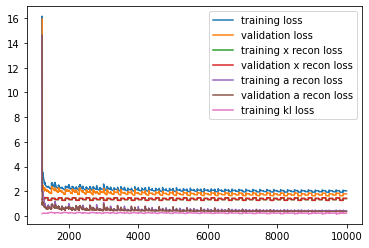

In [12]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_a_ep)
plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,500))
# plt.xlim((0,1000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [11]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.argmin(val_loss_x_ep[:])
# val_loss_a_ep[1040]

8611

In [7]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv:
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv:
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
    
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 1.8583 loss_x_test: 1.4614 loss_a_test: 0.3968
loss_x_genes: 1.4614 loss_x_proteins: 1.0568
control13
test results loss_test: 1.7294 loss_x_test: 1.3514 loss_a_test: 0.3780
loss_x_genes: 1.3514 loss_x_proteins: 0.6624
disease8
test results loss_test: 1.6734 loss_x_test: 1.2853 loss_a_test: 0.3881
loss_x_genes: 1.2853 loss_x_proteins: 0.7375
control8
test results loss_test: 1.7513 loss_x_test: 1.3895 loss_a_test: 0.3618
loss_x_genes: 1.3895 loss_x_proteins: 0.7602


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [13]:
# model.pi.weight[:8,:8]
model_str

'gcn_vae_xa_e2_d1_dca'